### 忽略无关警告

In [1]:
# Ignore irrelevant warnings 
import warnings
warnings.filterwarnings('ignore')

### 导入必要的库

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
import pandas as pd

In [57]:
# 模型训练
from pyod.utils.data import evaluate_print
from pyod.utils.utility import precision_n_scores
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score
 

### 导入检查数据异常值的模型，这些算法都被集成在PYOD工具包下，本次作业主要使用该工具包进行异常点和离群点检测

In [4]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.pca import PCA

## 一、处理 wine_banchmark 数据集

### 1.1读取所有csv文件

In [29]:
# 读取所有csv文件
from os import walk
df=[]
for f,_ ,i in walk("F:/Data Mining/homework4/wine_benchmarks/wine/benchmarks"):
    for j in i:
        temp = pd.read_csv(f+'/'+j)
        df.append(temp)

### 1.2 在每个数据集中执行模型训练和测试

In [148]:
random_state = np.random.RandomState(52)
outliers_fraction = 0.1

classifiers = {
        #'Fast Angle-based Outlier Detector (F_ABOD)': ABOD(contamination=outliers_fraction,method='fast'),
       # 'Original Angle-based Outlier Detector (O_ABOD)': ABOD(contamination=outliers_fraction,method='default'),
#         'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=random_state),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False,random_state=random_state),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction,random_state=random_state),
        'K Nearest Neighbors (KNN)': KNN(n_neighbors=90, method='largest',contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Local Outlier Factor (LOF)':LOF(contamination=outliers_fraction,n_neighbors=90),
        'Connectivity-Based Outlier Factor (COF)':LOF(contamination=outliers_fraction,n_neighbors=90),
        'Principal Component Analysis Outlier Detector (PCA)':PCA(contamination=outliers_fraction,weighted=True,n_components='mle',svd_solver ='full')
}

In [149]:
# 创建保存每个benchmark结果的字典
rocDict = {
       # 'Fast Angle-based Outlier Detector (F_ABOD)': [],
#         'Original Angle-based Outlier Detector (O_ABOD)': [],
#         'Cluster-based Local Outlier Factor (CBLOF)':[],
        'Feature Bagging':[],
        'Histogram-base Outlier Detection (HBOS)':[],
        'Isolation Forest':[],
        'K Nearest Neighbors (KNN)':[],
        'Average KNN': [],
        'Local Outlier Factor (LOF)':[],
        'Connectivity-Based Outlier Factor (COF)':[],
        'Principal Component Analysis Outlier Detector (PCA)':[]
}
prnDict = {
       # 'Fast Angle-based Outlier Detector (F_ABOD)': [],
#         'Original Angle-based Outlier Detector (O_ABOD)': [],
#         'Cluster-based Local Outlier Factor (CBLOF)':[],
        'Feature Bagging':[],
        'Histogram-base Outlier Detection (HBOS)':[],
        'Isolation Forest':[],
        'K Nearest Neighbors (KNN)':[],
        'Average KNN': [],
        'Local Outlier Factor (LOF)':[],
        'Connectivity-Based Outlier Factor (COF)':[],
        'Principal Component Analysis Outlier Detector (PCA)':[]
}

In [30]:
for subDF in df:
    subDF.columns
    # 保留用于训练和测试的数据属性
    subDF.drop(['motherset', 'origin', 'original.label', 'diff.score'],axis=1,inplace=True)
  
    # 构造数据集
    subDF.dropna(inplace = True)
    subDF['ground.truth']=subDF['ground.truth'].map({'nominal': 0,'anomaly':1})

In [145]:
df[0]

point.id  ground.truth  fixed.acidity  volatile.acidity  \
0     wine_point_3594             0      -1.245962         -0.362411   
1     wine_point_5089             1       0.759540          0.973867   
2     wine_point_1912             0      -0.088942         -0.969809   
3     wine_point_4908             1       0.219597          0.973867   
4     wine_point_2246             0       0.219597         -0.180191   
...               ...           ...            ...               ...   
3698  wine_point_2856             0      -0.243211         -0.058711   
3699  wine_point_3776             0      -0.551750         -0.058711   
3700  wine_point_5027             0       0.605270          1.520526   
3701  wine_point_2620             0      -0.474615          0.062769   
3702  wine_point_5748             1      -0.628884          1.763485   

      citric.acid  residual.sugar  chlorides  free.sulfur.dioxide  \
0       -0.265853       -0.261304  -0.343495             1.209882   
1        0.215849       -0.534540   0.598458            -0.536656   
2       -0.403482       -0.870829  -0.429127            -0.592996   
3        0.284664        0.138039   0.427194            -0.762016   
4       -0.541112        0.348220  -0.714567            -0.142276   
...           ...             ...        ...                  ...   
3698    -0.403482       -0.093160  -0.828743             0.871842   
3699    -0.265853        0.138039  -1.085640             0.590143   
3700    -1.091629       -0.765739   0.255930            -1.550775   
3701     0.215849        0.117021   0.198842             0.026743   
3702    -0.747556       -0.807775   0.684090            -1.043715   

      total.sulfur.dioxide   density        pH  sulphates   alcohol  
0                 0.747594 -0.899276  0.817846  -0.613338  0.174560  
1                 0.199134  0.968217  0.071518   0.596292 -0.915394  
2                -0.791633 -0.699187 -1.110168   1.402712 -0.496181  
3                -0.243173  1.034913  0.817846   1.805921  0.006874  
4                 0.446826 -0.242318 -0.363840  -1.016548  0.090717  
...                    ...       ...       ...        ...       ...  
3698              0.482210 -0.765883  0.195906  -0.680540  0.593772  
3699             -0.225480 -1.159391  0.133712  -1.419758  1.432198  
3700             -1.764708  0.501344  1.253204   2.612341  0.006874  
3701              0.606056  0.224555 -0.737004  -0.411733 -0.915394  
3702             -1.481632  0.731446  2.248308   0.865098 -0.580023  

[3703 rows x 13 columns]

In [150]:
for subDF in df:
    
    Y=subDF['ground.truth'].values
    X=subDF.drop(['ground.truth','point.id'],axis=1).values
    
    # 划分训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.35,random_state=0)
    
    #使用上述列表中定义的模型进行训练
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print("使用"+clf_name+" 进行建模：")
        clf.fit(x_train)
        
        # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_ 

        # 用训练好的clf来预测未知数据中的异常值
        # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_pred = clf.predict(x_test) 

        #  返回未知数据上的异常值 (分值越大越异常)
        y_test_scores = clf.decision_function(x_test) 

        y_train_scores = y_train_scores.reshape(-1,1)
        y_test_scores = y_test_scores.reshape(-1,1)

        # Score 值中出现NaN则转换成0
        if np.isnan(y_train_scores).any():
             y_train_scores = np.nan_to_num(y_train_scores)
        if np.isnan(y_test_scores).any():
             y_test_scores = np.nan_to_num(y_test_scores)

        print("在训练数据集中:")
        evaluate_print(clf_name, y_train, y_train_scores)
        print("\n在测试数据集中:")
        evaluate_print(clf_name, y_test, y_test_scores)
        print("=======================")
        
        check_consistent_length(y_test, y_test_scores)
        roc = np.round(roc_auc_score(y_test, y_test_scores), decimals=4)
        prn = np.round(precision_n_scores(y_test, y_test_scores),decimals=4)
        
        rocDict.get(clf_name).append(roc)
        prnDict.get(clf_name).append(prn)
    
    

使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5533, precision @ rank n:0.4023

在测试数据集中:
Feature Bagging ROC:0.5454, precision @ rank n:0.406
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.55, precision @ rank n:0.4116

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5474, precision @ rank n:0.435
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5684, precision @ rank n:0.4289

在测试数据集中:
Isolation Forest ROC:0.5671, precision @ rank n:0.4286
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5876, precision @ rank n:0.4116

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5717, precision @ rank n:0.4051
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5434, precision @ rank n:0.4046

在测试数据集中:
Average KNN ROC:0.5437, precision @ rank n:0.3987
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.533, precision @ rank n:0.3965

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.525, 

在训练数据集中:
Feature Bagging ROC:0.5429, precision @ rank n:0.4215

在测试数据集中:
Feature Bagging ROC:0.5732, precision @ rank n:0.435
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5414, precision @ rank n:0.4149

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5787, precision @ rank n:0.439
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5121, precision @ rank n:0.4018

在测试数据集中:
Isolation Forest ROC:0.5384, precision @ rank n:0.4187
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5604, precision @ rank n:0.438

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.584, precision @ rank n:0.4533
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5388, precision @ rank n:0.4204

在测试数据集中:
Average KNN ROC:0.5577, precision @ rank n:0.4309
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.535, precision @ rank n:0.416

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5589, precision @ rank n:0.424

在训练数据集中:
Feature Bagging ROC:0.5258, precision @ rank n:0.3671

在测试数据集中:
Feature Bagging ROC:0.512, precision @ rank n:0.362
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5464, precision @ rank n:0.3953

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.518, precision @ rank n:0.3753
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5691, precision @ rank n:0.4141

在测试数据集中:
Isolation Forest ROC:0.5362, precision @ rank n:0.3819
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5571, precision @ rank n:0.4071

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5402, precision @ rank n:0.3907
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5445, precision @ rank n:0.3918

在测试数据集中:
Average KNN ROC:0.5318, precision @ rank n:0.3929
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5247, precision @ rank n:0.3682

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.517, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.5273, precision @ rank n:0.3881

在测试数据集中:
Feature Bagging ROC:0.5103, precision @ rank n:0.386
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5296, precision @ rank n:0.3904

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5127, precision @ rank n:0.404
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5359, precision @ rank n:0.4053

在测试数据集中:
Isolation Forest ROC:0.5248, precision @ rank n:0.404
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5314, precision @ rank n:0.3881

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5225, precision @ rank n:0.404
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.526, precision @ rank n:0.3927

在测试数据集中:
Average KNN ROC:0.5193, precision @ rank n:0.402
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5206, precision @ rank n:0.3801

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5107, precision @ rank n:0.384

在训练数据集中:
Feature Bagging ROC:0.5483, precision @ rank n:0.4254

在测试数据集中:
Feature Bagging ROC:0.5847, precision @ rank n:0.4647
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5261, precision @ rank n:0.4002

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5708, precision @ rank n:0.4419
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5116, precision @ rank n:0.4068

在测试数据集中:
Isolation Forest ROC:0.5543, precision @ rank n:0.4564
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5519, precision @ rank n:0.42

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6066, precision @ rank n:0.4585
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5379, precision @ rank n:0.4265

在测试数据集中:
Average KNN ROC:0.5773, precision @ rank n:0.444
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5274, precision @ rank n:0.4156

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.57, precision @ rank n:0.43

在训练数据集中:
Feature Bagging ROC:0.5404, precision @ rank n:0.413

在测试数据集中:
Feature Bagging ROC:0.5429, precision @ rank n:0.4174
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.53, precision @ rank n:0.4119

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5256, precision @ rank n:0.3926
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5267, precision @ rank n:0.413

在测试数据集中:
Isolation Forest ROC:0.535, precision @ rank n:0.3967
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5725, precision @ rank n:0.4262

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5742, precision @ rank n:0.438
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5611, precision @ rank n:0.4405

在测试数据集中:
Average KNN ROC:0.5537, precision @ rank n:0.4091
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5384, precision @ rank n:0.4075

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5378, precision @ rank n:0.411

在训练数据集中:
Feature Bagging ROC:0.5095, precision @ rank n:0.3492

在测试数据集中:
Feature Bagging ROC:0.5205, precision @ rank n:0.3975
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5219, precision @ rank n:0.3783

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5261, precision @ rank n:0.4119
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5442, precision @ rank n:0.3912

在测试数据集中:
Isolation Forest ROC:0.5415, precision @ rank n:0.4139
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5356, precision @ rank n:0.3714

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.547, precision @ rank n:0.4262
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5273, precision @ rank n:0.3679

在测试数据集中:
Average KNN ROC:0.5427, precision @ rank n:0.416
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5122, precision @ rank n:0.3539

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5257, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5185, precision @ rank n:0.3919

在测试数据集中:
Feature Bagging ROC:0.5386, precision @ rank n:0.4024
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5315, precision @ rank n:0.4072

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5498, precision @ rank n:0.4106
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5455, precision @ rank n:0.4345

在测试数据集中:
Isolation Forest ROC:0.5432, precision @ rank n:0.4187
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5329, precision @ rank n:0.4105

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5473, precision @ rank n:0.4268
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5352, precision @ rank n:0.4138

在测试数据集中:
Average KNN ROC:0.5411, precision @ rank n:0.4065
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5204, precision @ rank n:0.3974

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5382, precision @ rank n

在训练数据集中:
Feature Bagging ROC:0.5316, precision @ rank n:0.3728

在测试数据集中:
Feature Bagging ROC:0.5356, precision @ rank n:0.4256
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5366, precision @ rank n:0.3882

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5279, precision @ rank n:0.3946
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5225, precision @ rank n:0.3917

在测试数据集中:
Isolation Forest ROC:0.4969, precision @ rank n:0.3884
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5641, precision @ rank n:0.3922

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5585, precision @ rank n:0.4132
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5353, precision @ rank n:0.3846

在测试数据集中:
Average KNN ROC:0.5448, precision @ rank n:0.4132
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5246, precision @ rank n:0.3704

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5239, precision @ rank n

在训练数据集中:
Feature Bagging ROC:0.523, precision @ rank n:0.3795

在测试数据集中:
Feature Bagging ROC:0.5081, precision @ rank n:0.3573
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5123, precision @ rank n:0.3795

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5249, precision @ rank n:0.3725
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5017, precision @ rank n:0.3739

在测试数据集中:
Isolation Forest ROC:0.5182, precision @ rank n:0.3878
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5458, precision @ rank n:0.3864

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5436, precision @ rank n:0.3769
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.542, precision @ rank n:0.3989

在测试数据集中:
Average KNN ROC:0.5258, precision @ rank n:0.3617
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5209, precision @ rank n:0.3727

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5026, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5145, precision @ rank n:0.3729

在测试数据集中:
Feature Bagging ROC:0.5375, precision @ rank n:0.3468
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.536, precision @ rank n:0.3945

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5462, precision @ rank n:0.3739
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5197, precision @ rank n:0.3865

在测试数据集中:
Isolation Forest ROC:0.5282, precision @ rank n:0.3761
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5382, precision @ rank n:0.3934

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5546, precision @ rank n:0.3851
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5357, precision @ rank n:0.3957

在测试数据集中:
Average KNN ROC:0.5519, precision @ rank n:0.3649
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.513, precision @ rank n:0.3763

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5365, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5081, precision @ rank n:0.3636

在测试数据集中:
Feature Bagging ROC:0.5029, precision @ rank n:0.386
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5069, precision @ rank n:0.3731

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5166, precision @ rank n:0.396
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5187, precision @ rank n:0.3743

在测试数据集中:
Isolation Forest ROC:0.4959, precision @ rank n:0.388
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5208, precision @ rank n:0.3802

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5145, precision @ rank n:0.384
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5193, precision @ rank n:0.3813

在测试数据集中:
Average KNN ROC:0.5095, precision @ rank n:0.38
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5111, precision @ rank n:0.3648

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5037, precision @ rank n:0.374

在训练数据集中:
Feature Bagging ROC:0.576, precision @ rank n:0.4485

在测试数据集中:
Feature Bagging ROC:0.5421, precision @ rank n:0.3874
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5649, precision @ rank n:0.4474

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5176, precision @ rank n:0.4021
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5557, precision @ rank n:0.4255

在测试数据集中:
Isolation Forest ROC:0.501, precision @ rank n:0.3789
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6065, precision @ rank n:0.453

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5633, precision @ rank n:0.4042
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5542, precision @ rank n:0.4206

在测试数据集中:
Average KNN ROC:0.5388, precision @ rank n:0.3979
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.568, precision @ rank n:0.4385

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5234, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.5377, precision @ rank n:0.4055

在测试数据集中:
Feature Bagging ROC:0.5497, precision @ rank n:0.411
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5368, precision @ rank n:0.4275

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5424, precision @ rank n:0.411
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5611, precision @ rank n:0.4374

在测试数据集中:
Isolation Forest ROC:0.567, precision @ rank n:0.4089
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5767, precision @ rank n:0.4352

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5892, precision @ rank n:0.4258
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5573, precision @ rank n:0.4319

在测试数据集中:
Average KNN ROC:0.569, precision @ rank n:0.4174
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5347, precision @ rank n:0.4055

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5425, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.5565, precision @ rank n:0.4112

在测试数据集中:
Feature Bagging ROC:0.5665, precision @ rank n:0.4386
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.555, precision @ rank n:0.418

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5559, precision @ rank n:0.4068
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5597, precision @ rank n:0.418

在测试数据集中:
Isolation Forest ROC:0.5525, precision @ rank n:0.411
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.568, precision @ rank n:0.4123

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5709, precision @ rank n:0.4237
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5629, precision @ rank n:0.4055

在测试数据集中:
Average KNN ROC:0.5708, precision @ rank n:0.4322
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5469, precision @ rank n:0.4009

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5568, precision @ rank n:0.43

在训练数据集中:
Feature Bagging ROC:0.499, precision @ rank n:0.3511

在测试数据集中:
Feature Bagging ROC:0.5425, precision @ rank n:0.4013
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5233, precision @ rank n:0.3818

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5529, precision @ rank n:0.4078
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5267, precision @ rank n:0.3794

在测试数据集中:
Isolation Forest ROC:0.5573, precision @ rank n:0.3926
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5199, precision @ rank n:0.3546

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5747, precision @ rank n:0.4273
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5222, precision @ rank n:0.3641

在测试数据集中:
Average KNN ROC:0.5699, precision @ rank n:0.4165
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5041, precision @ rank n:0.344

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5574, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5734, precision @ rank n:0.4395

在测试数据集中:
Feature Bagging ROC:0.5777, precision @ rank n:0.4369
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5532, precision @ rank n:0.4328

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5616, precision @ rank n:0.4224
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5401, precision @ rank n:0.4203

在测试数据集中:
Isolation Forest ROC:0.5443, precision @ rank n:0.412
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5941, precision @ rank n:0.4475

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5877, precision @ rank n:0.4286
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5686, precision @ rank n:0.4328

在测试数据集中:
Average KNN ROC:0.5483, precision @ rank n:0.4087
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5512, precision @ rank n:0.4226

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.548, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5562, precision @ rank n:0.4077

在测试数据集中:
Feature Bagging ROC:0.5158, precision @ rank n:0.3615
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5575, precision @ rank n:0.4089

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5388, precision @ rank n:0.3975
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5617, precision @ rank n:0.4123

在测试数据集中:
Isolation Forest ROC:0.5222, precision @ rank n:0.389
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5951, precision @ rank n:0.4248

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5483, precision @ rank n:0.3763
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5779, precision @ rank n:0.426

在测试数据集中:
Average KNN ROC:0.5252, precision @ rank n:0.3594
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5477, precision @ rank n:0.4089

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4997, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5465, precision @ rank n:0.4041

在测试数据集中:
Feature Bagging ROC:0.5312, precision @ rank n:0.3949
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5602, precision @ rank n:0.4086

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5401, precision @ rank n:0.3949
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5448, precision @ rank n:0.4075

在测试数据集中:
Isolation Forest ROC:0.5166, precision @ rank n:0.3737
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5782, precision @ rank n:0.4336

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5541, precision @ rank n:0.4013
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5653, precision @ rank n:0.4279

在测试数据集中:
Average KNN ROC:0.5531, precision @ rank n:0.4013
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5432, precision @ rank n:0.3939

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5262, precision @ rank n

在训练数据集中:
Feature Bagging ROC:0.5238, precision @ rank n:0.3961

在测试数据集中:
Feature Bagging ROC:0.5026, precision @ rank n:0.3765
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5056, precision @ rank n:0.3768

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5129, precision @ rank n:0.3889
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5095, precision @ rank n:0.3837

在测试数据集中:
Isolation Forest ROC:0.4927, precision @ rank n:0.3601
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5348, precision @ rank n:0.4075

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5164, precision @ rank n:0.4012
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5202, precision @ rank n:0.3961

在测试数据集中:
Average KNN ROC:0.5206, precision @ rank n:0.3971
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5215, precision @ rank n:0.3905

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5074, precision @ rank n

在训练数据集中:
Feature Bagging ROC:0.5432, precision @ rank n:0.4265

在测试数据集中:
Feature Bagging ROC:0.545, precision @ rank n:0.4177
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5306, precision @ rank n:0.4024

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5299, precision @ rank n:0.384
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5304, precision @ rank n:0.4068

在测试数据集中:
Isolation Forest ROC:0.5317, precision @ rank n:0.3953
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.569, precision @ rank n:0.443

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5623, precision @ rank n:0.4093
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5356, precision @ rank n:0.4112

在测试数据集中:
Average KNN ROC:0.5324, precision @ rank n:0.4051
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5256, precision @ rank n:0.4232

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5272, precision @ rank n:0.4

在训练数据集中:
Feature Bagging ROC:0.5213, precision @ rank n:0.3946

在测试数据集中:
Feature Bagging ROC:0.5118, precision @ rank n:0.3692
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5568, precision @ rank n:0.4229

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.539, precision @ rank n:0.4
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5285, precision @ rank n:0.39

在测试数据集中:
Isolation Forest ROC:0.5332, precision @ rank n:0.3626
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5634, precision @ rank n:0.4093

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.546, precision @ rank n:0.3824
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.545, precision @ rank n:0.4093

在测试数据集中:
Average KNN ROC:0.5199, precision @ rank n:0.3736
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5153, precision @ rank n:0.3912

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5124, precision @ rank n:0.3626


在训练数据集中:
Feature Bagging ROC:0.5355, precision @ rank n:0.3802

在测试数据集中:
Feature Bagging ROC:0.5301, precision @ rank n:0.4219
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5388, precision @ rank n:0.3955

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5002, precision @ rank n:0.3965
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5539, precision @ rank n:0.3872

在测试数据集中:
Isolation Forest ROC:0.527, precision @ rank n:0.416
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5564, precision @ rank n:0.3872

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5362, precision @ rank n:0.418
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5534, precision @ rank n:0.3979

在测试数据集中:
Average KNN ROC:0.5417, precision @ rank n:0.4277
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5307, precision @ rank n:0.3802

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5213, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.4963, precision @ rank n:0.3663

在测试数据集中:
Feature Bagging ROC:0.5344, precision @ rank n:0.3987
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5224, precision @ rank n:0.3843

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5282, precision @ rank n:0.3923
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4947, precision @ rank n:0.3775

在测试数据集中:
Isolation Forest ROC:0.5224, precision @ rank n:0.3689
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5174, precision @ rank n:0.3921

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5462, precision @ rank n:0.3987
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.515, precision @ rank n:0.3798

在测试数据集中:
Average KNN ROC:0.5495, precision @ rank n:0.4051
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5079, precision @ rank n:0.3798

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5391, precision @ rank n:

在训练数据集中:
Feature Bagging ROC:0.5509, precision @ rank n:0.4213

在测试数据集中:
Feature Bagging ROC:0.5321, precision @ rank n:0.4052
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5607, precision @ rank n:0.4301

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5452, precision @ rank n:0.4476
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5551, precision @ rank n:0.4136

在测试数据集中:
Isolation Forest ROC:0.5344, precision @ rank n:0.4153
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.573, precision @ rank n:0.4378

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5556, precision @ rank n:0.4335
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5235, precision @ rank n:0.4015

在测试数据集中:
Average KNN ROC:0.5376, precision @ rank n:0.4173
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5368, precision @ rank n:0.4108

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5181, precision @ rank n:

在训练数据集中:
Feature Bagging ROC:0.5464, precision @ rank n:0.4148

在测试数据集中:
Feature Bagging ROC:0.5295, precision @ rank n:0.3979
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5316, precision @ rank n:0.4192

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5487, precision @ rank n:0.4042
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5292, precision @ rank n:0.4115

在测试数据集中:
Isolation Forest ROC:0.5463, precision @ rank n:0.4147
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5735, precision @ rank n:0.4358

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.568, precision @ rank n:0.4168
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.558, precision @ rank n:0.4181

在测试数据集中:
Average KNN ROC:0.5443, precision @ rank n:0.4147
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5365, precision @ rank n:0.4004

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5264, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5304, precision @ rank n:0.4073

在测试数据集中:
Feature Bagging ROC:0.5076, precision @ rank n:0.3462
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5519, precision @ rank n:0.4321

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5155, precision @ rank n:0.3643
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5515, precision @ rank n:0.4375

在测试数据集中:
Isolation Forest ROC:0.5073, precision @ rank n:0.3258
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.573, precision @ rank n:0.4407

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5613, precision @ rank n:0.3914
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5636, precision @ rank n:0.4321

在测试数据集中:
Average KNN ROC:0.5461, precision @ rank n:0.3688
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5353, precision @ rank n:0.4127

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5225, precision @ rank n:

在训练数据集中:
Feature Bagging ROC:0.5207, precision @ rank n:0.396

在测试数据集中:
Feature Bagging ROC:0.5021, precision @ rank n:0.3753
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.527, precision @ rank n:0.3926

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5124, precision @ rank n:0.392
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5426, precision @ rank n:0.4139

在测试数据集中:
Isolation Forest ROC:0.5205, precision @ rank n:0.3836
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5342, precision @ rank n:0.396

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5191, precision @ rank n:0.3795
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5255, precision @ rank n:0.3859

在测试数据集中:
Average KNN ROC:0.5085, precision @ rank n:0.3774
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5218, precision @ rank n:0.3904

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5069, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.5625, precision @ rank n:0.4235

在测试数据集中:
Feature Bagging ROC:0.5461, precision @ rank n:0.4384
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5518, precision @ rank n:0.4246

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5359, precision @ rank n:0.4343
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5468, precision @ rank n:0.4112

在测试数据集中:
Isolation Forest ROC:0.5357, precision @ rank n:0.4323
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5841, precision @ rank n:0.4351

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5679, precision @ rank n:0.4343
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5491, precision @ rank n:0.4223

在测试数据集中:
Average KNN ROC:0.5527, precision @ rank n:0.4343
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5453, precision @ rank n:0.419

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5496, precision @ rank n:

在训练数据集中:
Feature Bagging ROC:0.5479, precision @ rank n:0.4066

在测试数据集中:
Feature Bagging ROC:0.5607, precision @ rank n:0.4049
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.546, precision @ rank n:0.4124

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5263, precision @ rank n:0.3805
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5412, precision @ rank n:0.4055

在测试数据集中:
Isolation Forest ROC:0.5331, precision @ rank n:0.3805
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.563, precision @ rank n:0.4284

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5729, precision @ rank n:0.4204
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.54, precision @ rank n:0.3986

在测试数据集中:
Average KNN ROC:0.5587, precision @ rank n:0.4027
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5227, precision @ rank n:0.3998

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5409, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.5268, precision @ rank n:0.3916

在测试数据集中:
Feature Bagging ROC:0.5283, precision @ rank n:0.4025
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5279, precision @ rank n:0.403

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5668, precision @ rank n:0.4195
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.539, precision @ rank n:0.4166

在测试数据集中:
Isolation Forest ROC:0.5577, precision @ rank n:0.4195
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5528, precision @ rank n:0.4086

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5719, precision @ rank n:0.4258
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5464, precision @ rank n:0.4018

在测试数据集中:
Average KNN ROC:0.5685, precision @ rank n:0.428
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5275, precision @ rank n:0.3802

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5313, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.5281, precision @ rank n:0.3897

在测试数据集中:
Feature Bagging ROC:0.5125, precision @ rank n:0.37
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5395, precision @ rank n:0.3987

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5206, precision @ rank n:0.3953
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4987, precision @ rank n:0.3707

在测试数据集中:
Isolation Forest ROC:0.4986, precision @ rank n:0.37
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5472, precision @ rank n:0.4043

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5261, precision @ rank n:0.3975
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5472, precision @ rank n:0.4143

在测试数据集中:
Average KNN ROC:0.5276, precision @ rank n:0.3848
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5363, precision @ rank n:0.3953

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5155, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.532, precision @ rank n:0.4067

在测试数据集中:
Feature Bagging ROC:0.5333, precision @ rank n:0.4175
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5199, precision @ rank n:0.3922

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5074, precision @ rank n:0.3862
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5316, precision @ rank n:0.3978

在测试数据集中:
Isolation Forest ROC:0.5053, precision @ rank n:0.38
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5595, precision @ rank n:0.4246

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5487, precision @ rank n:0.4134
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5316, precision @ rank n:0.4034

在测试数据集中:
Average KNN ROC:0.5311, precision @ rank n:0.4113
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5306, precision @ rank n:0.3944

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5293, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.5343, precision @ rank n:0.3995

在测试数据集中:
Feature Bagging ROC:0.5255, precision @ rank n:0.414
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5417, precision @ rank n:0.3914

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.536, precision @ rank n:0.4423
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5113, precision @ rank n:0.3786

在测试数据集中:
Isolation Forest ROC:0.5096, precision @ rank n:0.4197
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5511, precision @ rank n:0.3972

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5455, precision @ rank n:0.4556
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5346, precision @ rank n:0.3717

在测试数据集中:
Average KNN ROC:0.5362, precision @ rank n:0.448
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5228, precision @ rank n:0.3786

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5235, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.511, precision @ rank n:0.3709

在测试数据集中:
Feature Bagging ROC:0.4802, precision @ rank n:0.337
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5153, precision @ rank n:0.3686

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5177, precision @ rank n:0.3652
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5044, precision @ rank n:0.3523

在测试数据集中:
Isolation Forest ROC:0.5143, precision @ rank n:0.3761
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5439, precision @ rank n:0.3767

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.521, precision @ rank n:0.3674
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5378, precision @ rank n:0.3814

在测试数据集中:
Average KNN ROC:0.5089, precision @ rank n:0.3457
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5126, precision @ rank n:0.3593

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4789, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.53, precision @ rank n:0.3922

在测试数据集中:
Feature Bagging ROC:0.4778, precision @ rank n:0.3446
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5434, precision @ rank n:0.4002

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4865, precision @ rank n:0.3636
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5364, precision @ rank n:0.3934

在测试数据集中:
Isolation Forest ROC:0.4874, precision @ rank n:0.37
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5469, precision @ rank n:0.3934

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4884, precision @ rank n:0.3679
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5478, precision @ rank n:0.4048

在测试数据集中:
Average KNN ROC:0.4928, precision @ rank n:0.3615
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5302, precision @ rank n:0.3786

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4762, precision @ rank n:0.3

在训练数据集中:
Feature Bagging ROC:0.4764, precision @ rank n:0.4168

在测试数据集中:
Feature Bagging ROC:0.5205, precision @ rank n:0.4634
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4646, precision @ rank n:0.4124

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5129, precision @ rank n:0.4646
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4762, precision @ rank n:0.4242

在测试数据集中:
Isolation Forest ROC:0.4955, precision @ rank n:0.4476
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4816, precision @ rank n:0.4242

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5112, precision @ rank n:0.466
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4835, precision @ rank n:0.4256

在测试数据集中:
Average KNN ROC:0.5207, precision @ rank n:0.4503
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4789, precision @ rank n:0.4183

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5027, precision @ rank n:

在训练数据集中:
Feature Bagging ROC:0.5035, precision @ rank n:0.4595

在测试数据集中:
Feature Bagging ROC:0.4894, precision @ rank n:0.4384
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.488, precision @ rank n:0.4381

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4647, precision @ rank n:0.389
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5008, precision @ rank n:0.4595

在测试数据集中:
Isolation Forest ROC:0.4691, precision @ rank n:0.4055
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5069, precision @ rank n:0.468

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.496, precision @ rank n:0.4329
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.499, precision @ rank n:0.4481

在测试数据集中:
Average KNN ROC:0.4935, precision @ rank n:0.4219
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4998, precision @ rank n:0.4552

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.496, precision @ rank n:0.449

在训练数据集中:
Feature Bagging ROC:0.4941, precision @ rank n:0.4522

在测试数据集中:
Feature Bagging ROC:0.5162, precision @ rank n:0.4472
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4847, precision @ rank n:0.4649

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5005, precision @ rank n:0.4306
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4896, precision @ rank n:0.4452

在测试数据集中:
Isolation Forest ROC:0.4935, precision @ rank n:0.4444
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4928, precision @ rank n:0.4508

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5205, precision @ rank n:0.45
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4982, precision @ rank n:0.4607

在测试数据集中:
Average KNN ROC:0.5209, precision @ rank n:0.4583
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4904, precision @ rank n:0.4579

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5237, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5088, precision @ rank n:0.4433

在测试数据集中:
Feature Bagging ROC:0.5, precision @ rank n:0.4333
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4908, precision @ rank n:0.4375

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5013, precision @ rank n:0.4472
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.51, precision @ rank n:0.4491

在测试数据集中:
Isolation Forest ROC:0.5132, precision @ rank n:0.4417
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5098, precision @ rank n:0.452

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4969, precision @ rank n:0.4417
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5061, precision @ rank n:0.4433

在测试数据集中:
Average KNN ROC:0.5004, precision @ rank n:0.4472
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5081, precision @ rank n:0.4491

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4995, precision @ rank n:0.438

在训练数据集中:
Feature Bagging ROC:0.5152, precision @ rank n:0.4698

在测试数据集中:
Feature Bagging ROC:0.4916, precision @ rank n:0.4435
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4937, precision @ rank n:0.4459

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5085, precision @ rank n:0.4516
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4904, precision @ rank n:0.4459

在测试数据集中:
Isolation Forest ROC:0.4958, precision @ rank n:0.4516
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5112, precision @ rank n:0.4641

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4841, precision @ rank n:0.4247
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5096, precision @ rank n:0.4627

在测试数据集中:
Average KNN ROC:0.4894, precision @ rank n:0.4328
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5129, precision @ rank n:0.4655

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4699, precision @ rank n

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.501, precision @ rank n:0.4422

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4678, precision @ rank n:0.4453
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4907, precision @ rank n:0.4625

在测试数据集中:
Feature Bagging ROC:0.5349, precision @ rank n:0.4842
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4738, precision @ rank n:0.4173

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5202, precision @ rank n:0.4816
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4802, precision @ rank n:0.4441

在测试数据集中:
Isolation Forest ROC:0.5237, precision @ rank n:0.4816
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4952, precision @ rank n:0.454

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5216, precision @ rank n:0.4737
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4894, precision @ rank n:0.4413

在测试数据集中:
Avera

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5049, precision @ rank n:0.467

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5072, precision @ rank n:0.4688
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5013, precision @ rank n:0.4527

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5056, precision @ rank n:0.4688
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4867, precision @ rank n:0.4279

在测试数据集中:
Feature Bagging ROC:0.4955, precision @ rank n:0.4541
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4822, precision @ rank n:0.4206

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5023, precision @ rank n:0.4751
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4992, precision @ rank n:0.4309

在测试数据集中:
Isolation Forest ROC:0.492, precision @ rank n:0.4593
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4959, precision @ rank n:0.429

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4779, precision @ rank n:0.4638
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4959, precision @ rank n:0.429

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4779, precision @ rank n:0.4638
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4902, precision @ rank n:0.4275

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4719, precision @ rank n:0.4564
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4893, precision @ rank n:0.4395

在测试数据集中:
Feature Bagging ROC:0.4937, precision @ rank n:0.4397
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4888, precision @ rank n:0.4352

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.495, precision @ rank n:0.439

在训练数据集中:
Average KNN ROC:0.4901, precision @ rank n:0.4408

在测试数据集中:
Average KNN ROC:0.5284, precision @ rank n:0.4645
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4733, precision @ rank n:0.4294

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5358, precision @ rank n:0.4727
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4733, precision @ rank n:0.4294

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5358, precision @ rank n:0.4727
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4694, precision @ rank n:0.4251

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5322, precision @ rank n:0.4754
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4905, precision @ rank n:0.4279

在测试数据集中:
Feature Bagging ROC:0.5346, precision @ rank n:0.4881
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogr

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4889, precision @ rank n:0.437

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.497, precision @ rank n:0.4675
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.503, precision @ rank n:0.4486

在测试数据集中:
Average KNN ROC:0.4744, precision @ rank n:0.46
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4871, precision @ rank n:0.4153

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4892, precision @ rank n:0.4525
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4871, precision @ rank n:0.4153

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4892, precision @ rank n:0.4525
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4745, precision @ rank n:0.4284

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4971, precision @ rank n:0.4575
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:

在训练数据集中:
Isolation Forest ROC:0.4845, precision @ rank n:0.4587

在测试数据集中:
Isolation Forest ROC:0.4777, precision @ rank n:0.427
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4954, precision @ rank n:0.4683

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4801, precision @ rank n:0.4189
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5026, precision @ rank n:0.4642

在测试数据集中:
Average KNN ROC:0.4688, precision @ rank n:0.4243
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.492, precision @ rank n:0.4559

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4759, precision @ rank n:0.4108
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.492, precision @ rank n:0.4559

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4759, precision @ rank n:0.4108
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4865, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.4956, precision @ rank n:0.4451

在测试数据集中:
Isolation Forest ROC:0.4714, precision @ rank n:0.429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5015, precision @ rank n:0.4422

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4822, precision @ rank n:0.429
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5052, precision @ rank n:0.4665

在测试数据集中:
Average KNN ROC:0.4818, precision @ rank n:0.4235
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5008, precision @ rank n:0.4351

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4754, precision @ rank n:0.4153
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5008, precision @ rank n:0.4351

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4754, precision @ rank n:0.4153
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4923, precision @ r

在训练数据集中:
Isolation Forest ROC:0.518, precision @ rank n:0.4651

在测试数据集中:
Isolation Forest ROC:0.5075, precision @ rank n:0.4227
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4996, precision @ rank n:0.4419

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4989, precision @ rank n:0.4337
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5077, precision @ rank n:0.4564

在测试数据集中:
Average KNN ROC:0.5106, precision @ rank n:0.4309
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5005, precision @ rank n:0.452

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4999, precision @ rank n:0.4337
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5005, precision @ rank n:0.452

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4999, precision @ rank n:0.4337
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4909, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.4948, precision @ rank n:0.5107

在测试数据集中:
Isolation Forest ROC:0.4974, precision @ rank n:0.479
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4893, precision @ rank n:0.5107

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4972, precision @ rank n:0.4731
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5143, precision @ rank n:0.5307

在测试数据集中:
Average KNN ROC:0.5524, precision @ rank n:0.503
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4921, precision @ rank n:0.5168

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5128, precision @ rank n:0.485
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4921, precision @ rank n:0.5168

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5128, precision @ rank n:0.485
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4954, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5184, precision @ rank n:0.5078

在测试数据集中:
Isolation Forest ROC:0.5019, precision @ rank n:0.5444
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5189, precision @ rank n:0.5109

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4527, precision @ rank n:0.4778
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5462, precision @ rank n:0.5265

在测试数据集中:
Average KNN ROC:0.4762, precision @ rank n:0.4944
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5266, precision @ rank n:0.5202

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4611, precision @ rank n:0.5056
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5266, precision @ rank n:0.5202

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4611, precision @ rank n:0.5056
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4976, precision @

在训练数据集中:
Isolation Forest ROC:0.5275, precision @ rank n:0.5209

在测试数据集中:
Isolation Forest ROC:0.4829, precision @ rank n:0.4643
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5066, precision @ rank n:0.5177

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4621, precision @ rank n:0.4643
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5143, precision @ rank n:0.508

在测试数据集中:
Average KNN ROC:0.4857, precision @ rank n:0.4643
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5065, precision @ rank n:0.5177

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4691, precision @ rank n:0.4702
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5065, precision @ rank n:0.5177

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4691, precision @ rank n:0.4702
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5022, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5041, precision @ rank n:0.4968

在测试数据集中:
Isolation Forest ROC:0.5207, precision @ rank n:0.5632
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5169, precision @ rank n:0.513

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5188, precision @ rank n:0.5895
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5127, precision @ rank n:0.5032

在测试数据集中:
Average KNN ROC:0.5328, precision @ rank n:0.6053
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5134, precision @ rank n:0.5097

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5189, precision @ rank n:0.5895
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5134, precision @ rank n:0.5097

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5189, precision @ rank n:0.5895
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5176, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4822, precision @ rank n:0.4777

在测试数据集中:
Isolation Forest ROC:0.4937, precision @ rank n:0.4494
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4802, precision @ rank n:0.4698

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4911, precision @ rank n:0.4747
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5312, precision @ rank n:0.5111

在测试数据集中:
Average KNN ROC:0.5399, precision @ rank n:0.4968
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4899, precision @ rank n:0.4921

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5064, precision @ rank n:0.4873
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4899, precision @ rank n:0.4921

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5064, precision @ rank n:0.4873
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4721, precision @

在训练数据集中:
Isolation Forest ROC:0.491, precision @ rank n:0.4856

在测试数据集中:
Isolation Forest ROC:0.4538, precision @ rank n:0.4615
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4818, precision @ rank n:0.4696

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4852, precision @ rank n:0.4675
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5077, precision @ rank n:0.492

在测试数据集中:
Average KNN ROC:0.5337, precision @ rank n:0.5089
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4874, precision @ rank n:0.4824

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4824, precision @ rank n:0.4911
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4874, precision @ rank n:0.4824

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4824, precision @ rank n:0.4911
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4804, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5111, precision @ rank n:0.487

在测试数据集中:
Isolation Forest ROC:0.503, precision @ rank n:0.5538
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4983, precision @ rank n:0.474

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4821, precision @ rank n:0.543
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5259, precision @ rank n:0.4838

在测试数据集中:
Average KNN ROC:0.4879, precision @ rank n:0.543
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4991, precision @ rank n:0.487

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4818, precision @ rank n:0.5323
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4991, precision @ rank n:0.487

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4818, precision @ rank n:0.5323
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4925, precision @ rank n

在训练数据集中:
Isolation Forest ROC:0.4726, precision @ rank n:0.4781

在测试数据集中:
Isolation Forest ROC:0.4809, precision @ rank n:0.4912
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4874, precision @ rank n:0.475

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4761, precision @ rank n:0.4737
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4832, precision @ rank n:0.475

在测试数据集中:
Average KNN ROC:0.4917, precision @ rank n:0.4854
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4891, precision @ rank n:0.4812

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4792, precision @ rank n:0.4795
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4891, precision @ rank n:0.4812

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4792, precision @ rank n:0.4795
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4928, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4854, precision @ rank n:0.4888

在测试数据集中:
Isolation Forest ROC:0.4728, precision @ rank n:0.5104
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4882, precision @ rank n:0.4665

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4937, precision @ rank n:0.526
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5534, precision @ rank n:0.5367

在测试数据集中:
Average KNN ROC:0.5297, precision @ rank n:0.5625
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5068, precision @ rank n:0.4984

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4954, precision @ rank n:0.526
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5068, precision @ rank n:0.4984

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4954, precision @ rank n:0.526
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4851, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.4948, precision @ rank n:0.5257

在测试数据集中:
Isolation Forest ROC:0.5012, precision @ rank n:0.4658
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4943, precision @ rank n:0.5227

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4959, precision @ rank n:0.4783
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5338, precision @ rank n:0.5589

在测试数据集中:
Average KNN ROC:0.5022, precision @ rank n:0.4783
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5117, precision @ rank n:0.5378

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4918, precision @ rank n:0.4596
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5117, precision @ rank n:0.5378

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4918, precision @ rank n:0.4596
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4896, precision @

在训练数据集中:
Isolation Forest ROC:0.5095, precision @ rank n:0.5396

在测试数据集中:
Isolation Forest ROC:0.5042, precision @ rank n:0.4753
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5017, precision @ rank n:0.5152

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4987, precision @ rank n:0.4753
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.509, precision @ rank n:0.5183

在测试数据集中:
Average KNN ROC:0.5207, precision @ rank n:0.5
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.507, precision @ rank n:0.5183

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4982, precision @ rank n:0.4568
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.507, precision @ rank n:0.5183

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4982, precision @ rank n:0.4568
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4985, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.4754, precision @ rank n:0.4891

在测试数据集中:
Isolation Forest ROC:0.5409, precision @ rank n:0.5581
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4874, precision @ rank n:0.5016

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5241, precision @ rank n:0.5291
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.489, precision @ rank n:0.5078

在测试数据集中:
Average KNN ROC:0.5325, precision @ rank n:0.5523
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4862, precision @ rank n:0.5078

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5257, precision @ rank n:0.5174
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4862, precision @ rank n:0.5078

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5257, precision @ rank n:0.5174
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4769, precision @ 

在训练数据集中:
Isolation Forest ROC:0.7119, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9483, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6886, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9522, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8053, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9799, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6855, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9877, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6855, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9877, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6279, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.2737, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7637, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3186, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.788, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2668, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7073, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4013, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6853, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4013, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6853, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2197, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5251, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7958, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.628, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.856, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4757, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8699, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4524, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9012, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4524, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9012, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.517, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.6043, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7083, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7792, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4051, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.791, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4182, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7342, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3927, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7342, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3927, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7841, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5862, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8649, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8106, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9405, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5989, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8004, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5711, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8328, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5711, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8328, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6646, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5152, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9317, precision @ rank n:0.3333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4952, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8506, precision @ rank n:0.3333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7059, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6528, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6157, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6103, precision @ rank n:0.3333
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6157, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6103, precision @ rank n:0.3333
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4229, precision @ rank n:0.0

在测

在训练数据集中:
Isolation Forest ROC:0.9114, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6103, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8814, precision @ rank n:0.3333

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7315, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8136, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5509, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.879, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4769, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.879, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4769, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9195, precision @ rank n:0.3333

在测试数据集中:
Prin

在训练数据集中:
Isolation Forest ROC:0.7949, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.983, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.808, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8102, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8286, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7153, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7606, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5949, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7606, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5949, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.828, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.9387, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9301, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9156, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9378, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7693, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7205, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5804, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6459, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5804, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6459, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9684, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5088, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3048, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4644, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1983, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.506, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.1204, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3963, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.0833, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3963, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0833, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5709, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.1886, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3011, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3619, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3879, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4591, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.491, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4595, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4142, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4595, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4142, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.1034, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.2003, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5699, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.1687, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6359, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2758, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6514, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.1841, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6834, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.1841, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6834, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.1409, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8797, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6147, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9102, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7023, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8431, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7216, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8589, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5598, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8589, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5598, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9005, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6435, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6188, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7228, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7863, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.702, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7762, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5633, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4637, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5633, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4637, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7227, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.3909, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.605, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4287, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5309, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3859, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3494, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.457, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3359, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.457, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3359, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3419, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.8857, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4297, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8583, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5293, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.76, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5842, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7668, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.512, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7668, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.512, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8834, precision @ rank n:0.0

在测试数据集中:
Principal Co

在训练数据集中:
Isolation Forest ROC:0.8061, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8834, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9019, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8143, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9505, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7564, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9291, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7757, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9291, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7757, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8074, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.781, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.817, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7072, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8174, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8067, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7602, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7413, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6394, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7413, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6394, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5858, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.8259, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5683, precision @ rank n:0.3333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8322, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6656, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6884, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6625, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6244, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6664, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6244, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6664, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8513, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.7841, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5618, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8256, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.583, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.771, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.651, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.76, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.605, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.76, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.605, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8516, precision @ rank n:0.0

在测试数据集中:
Principal Compone

在训练数据集中:
Isolation Forest ROC:0.6978, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6958, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6315, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6224, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6372, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7371, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4852, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5305, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4852, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5305, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7448, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6062, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.327, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7465, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5734, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7889, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7726, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7261, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.69, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7261, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.69, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5509, precision @ rank n:0.0

在测试数据集中:
Principal Com

在训练数据集中:
Isolation Forest ROC:0.9175, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2068, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8744, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4082, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9087, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.2369, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.887, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4676, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.887, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4676, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8484, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.0046, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5966, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.0108, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5853, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.0395, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6381, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.0212, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5917, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0212, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5917, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.0017, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7053, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8233, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7252, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.827, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6869, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8492, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6862, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7132, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6862, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7132, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6665, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5121, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6265, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5817, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6167, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6914, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6002, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6686, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6225, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6686, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6225, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4415, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.461, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6929, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5363, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7594, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5977, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6774, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5454, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5811, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5454, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5811, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5518, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.8885, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2123, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7176, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.307, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7218, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.2509, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6733, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3116, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6733, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3116, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7562, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5331, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9444, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.623, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8964, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6914, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.936, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5411, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7825, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5411, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7825, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.56, precision @ rank n:0.0

在测试数据集中:
Principal Co

在训练数据集中:
Isolation Forest ROC:0.9251, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2434, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8157, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.2242, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8453, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4282, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5541, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3156, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5541, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3156, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9118, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.9234, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6304, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9242, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6405, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9316, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.697, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.917, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6791, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.917, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6791, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9373, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.7881, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6685, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8064, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5253, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8265, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.562, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8171, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5556, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8171, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5556, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7749, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.8836, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.734, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.825, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7157, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6457, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3122, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6011, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4145, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6011, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4145, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8794, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.9957, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9991, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9965, precision @ rank n:0.3333

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9973, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9954, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9872, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9919, precision @ rank n:0.3333

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9963, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9919, precision @ rank n:0.3333

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9963, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9962, precision @ rank n:0.3333

在测试数据

在训练数据集中:
Isolation Forest ROC:0.719, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7951, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5749, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6017, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5496, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6119, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.526, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6008, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.526, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6008, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6265, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.5502, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3675, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5346, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4909, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5208, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5132, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4833, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4973, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4833, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4973, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5365, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5916, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.573, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6453, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6381, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.747, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.613, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5582, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5114, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5582, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5114, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5899, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.8221, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6477, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7563, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6407, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7245, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6014, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7386, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6622, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7386, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6622, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7033, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.3228, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.62, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3113, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5237, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3429, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5588, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3142, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4905, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3142, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4905, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2626, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.4532, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6426, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4261, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6197, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4364, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.622, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.416, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6262, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.416, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6262, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4, precision @ rank n:0.0

在测试数据集中:
Principal Comp

在训练数据集中:
Isolation Forest ROC:0.7215, precision @ rank n:0.1

在测试数据集中:
Isolation Forest ROC:0.6528, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.682, precision @ rank n:0.1111

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6478, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7341, precision @ rank n:0.1

在测试数据集中:
Average KNN ROC:0.7061, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6941, precision @ rank n:0.1

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5747, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6941, precision @ rank n:0.1

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5747, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7097, precision @ rank n:0.1

在测试数据集中:
Princi

在训练数据集中:
Isolation Forest ROC:0.7045, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6916, precision @ rank n:0.2222
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7003, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6529, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6767, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6322, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.666, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5984, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.666, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5984, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6768, precision @ rank n:0.0

在测试数据集中:
Princip

在训练数据集中:
Isolation Forest ROC:0.5225, precision @ rank n:0.0769

在测试数据集中:
Isolation Forest ROC:0.7158, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5993, precision @ rank n:0.0769

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6838, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.621, precision @ rank n:0.0769

在测试数据集中:
Average KNN ROC:0.651, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.573, precision @ rank n:0.0769

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6676, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.573, precision @ rank n:0.0769

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6676, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5596, precision @ rank n:0.0769

在测试

在训练数据集中:
Isolation Forest ROC:0.6706, precision @ rank n:0.1

在测试数据集中:
Isolation Forest ROC:0.6149, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6387, precision @ rank n:0.1

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5892, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6124, precision @ rank n:0.1

在测试数据集中:
Average KNN ROC:0.6118, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6445, precision @ rank n:0.1

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5743, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6445, precision @ rank n:0.1

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5743, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6431, precision @ rank n:0.1

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.4831, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6122, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5643, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7163, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6078, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7867, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4991, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6687, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4991, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6687, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4008, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6048, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5655, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5527, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6541, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5213, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7325, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5246, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6921, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5246, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6921, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5908, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5656, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5687, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5372, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5844, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5531, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5676, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.501, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5297, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.501, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5297, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5049, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.5613, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.427, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5354, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5001, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5367, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.575, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5197, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5079, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5197, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5079, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5461, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.6732, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7229, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7179, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7002, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7459, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7888, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6678, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4774, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6678, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4774, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6146, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5659, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7622, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5538, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7653, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5641, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6991, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5455, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7305, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5455, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7305, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.536, precision @ rank n:0.0769

在测试数据集中:
Princi

在训练数据集中:
Isolation Forest ROC:0.685, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5589, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6736, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5476, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6572, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4987, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6309, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4729, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6309, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4729, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6505, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5728, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6597, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5833, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5927, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5781, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5874, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5702, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6121, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5702, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6121, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5824, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6699, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5966, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7057, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6009, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6763, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5823, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5359, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5385, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5359, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5385, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.656, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5331, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7164, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5207, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6844, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5303, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6382, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4793, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7149, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4793, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7149, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5354, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5297, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7808, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5431, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7326, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5668, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7701, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4996, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7015, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4996, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7015, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4944, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8392, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5737, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7668, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5243, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7514, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5031, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7517, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4633, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7517, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4633, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7655, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7324, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5661, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7308, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6254, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7631, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6624, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6439, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6304, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6439, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6304, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7259, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5627, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7401, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5417, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6383, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5578, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6032, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5429, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5772, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5429, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5772, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5275, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7014, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6692, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6704, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6863, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.66, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7012, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6197, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6359, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6197, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6359, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6503, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.8834, precision @ rank n:0.1111

在测试数据集中:
Isolation Forest ROC:0.8894, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9711, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9893, precision @ rank n:0.2857
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.941, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9433, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9597, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9831, precision @ rank n:0.2857
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9597, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9831, precision @ rank n:0.2857
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9665, precision @ rank n:0.0

在测试数据集

在训练数据集中:
Isolation Forest ROC:0.6145, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5641, precision @ rank n:0.1667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6892, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5444, precision @ rank n:0.1667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5919, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6996, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6501, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5211, precision @ rank n:0.1667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6501, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5211, precision @ rank n:0.1667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5865, precision @ rank n:0.0

在测试数据

在训练数据集中:
Isolation Forest ROC:0.6898, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7002, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6753, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6759, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6515, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6664, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6971, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.628, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6971, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.628, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6618, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.393, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5845, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3562, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5616, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3353, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.617, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.345, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5695, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.345, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5695, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.363, precision @ rank n:0.0

在测试数据集中:
Principal Com

在训练数据集中:
Isolation Forest ROC:0.3942, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6273, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4397, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5061, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4725, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5374, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4308, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5063, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4308, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5063, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4132, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6321, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5484, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5838, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5335, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6625, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5245, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5141, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4524, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5141, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4524, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.696, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5007, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6443, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5672, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5673, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5284, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.542, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5221, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4197, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5221, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4197, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.511, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.5955, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5884, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5964, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6177, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5902, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5832, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5645, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4966, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5645, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4966, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5894, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6361, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4479, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6296, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4995, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6172, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4807, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6151, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5138, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6151, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5138, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6798, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.501, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7203, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4908, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7624, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4591, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7225, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4416, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6629, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4416, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6629, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5535, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5384, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4925, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5405, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5716, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5912, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6218, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5432, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5457, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5432, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5457, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5371, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5011, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4288, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5052, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4423, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4859, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4711, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5087, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4425, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5087, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4425, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5095, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5691, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4268, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6525, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.453, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6674, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4448, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6478, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.441, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6478, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.441, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6211, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.9912, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9934, precision @ rank n:0.6667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9965, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9978, precision @ rank n:0.6667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9947, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9956, precision @ rank n:0.6667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9947, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9978, precision @ rank n:0.6667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9947, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9978, precision @ rank n:0.6667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9974, precision @ rank n:0.5

在测

在训练数据集中:
Isolation Forest ROC:0.4509, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3786, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3333, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1677, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4062, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.2572, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3597, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2125, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3597, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2125, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3465, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6494, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6475, precision @ rank n:0.1111
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7008, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6246, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6925, precision @ rank n:0.05

在测试数据集中:
Average KNN ROC:0.7047, precision @ rank n:0.0556
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6195, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6178, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6195, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6178, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.659, precision @ rank n:0.0

在测试数据集中:

在训练数据集中:
Isolation Forest ROC:0.6826, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5996, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7048, precision @ rank n:0.0357

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6712, precision @ rank n:0.1
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6768, precision @ rank n:0.0357

在测试数据集中:
Average KNN ROC:0.7186, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6634, precision @ rank n:0.0357

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7137, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6634, precision @ rank n:0.0357

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7137, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6874, precision @ rank n:0.0

在测试数据

在训练数据集中:
Isolation Forest ROC:0.5867, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5686, precision @ rank n:0.0556
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5518, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5345, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5609, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5264, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5051, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5196, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5051, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5196, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5632, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.5136, precision @ rank n:0.0417

在测试数据集中:
Isolation Forest ROC:0.5387, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4755, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5279, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4984, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5111, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4564, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5423, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4564, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5423, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4665, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.7535, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6326, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7423, precision @ rank n:0.0909

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5856, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7355, precision @ rank n:0.0909

在测试数据集中:
Average KNN ROC:0.5515, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7102, precision @ rank n:0.1364

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4344, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7102, precision @ rank n:0.1364

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4344, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6994, precision @ rank n:0.0455

在测

在训练数据集中:
Isolation Forest ROC:0.5477, precision @ rank n:0.0909

在测试数据集中:
Isolation Forest ROC:0.5675, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6218, precision @ rank n:0.0455

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5698, precision @ rank n:0.0625
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6188, precision @ rank n:0.0455

在测试数据集中:
Average KNN ROC:0.5366, precision @ rank n:0.0625
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5627, precision @ rank n:0.0455

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4895, precision @ rank n:0.0625
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5627, precision @ rank n:0.0455

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4895, precision @ rank n:0.0625
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5632, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5759, precision @ rank n:0.0357

在测试数据集中:
Isolation Forest ROC:0.6227, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5734, precision @ rank n:0.0714

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5669, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5593, precision @ rank n:0.0714

在测试数据集中:
Average KNN ROC:0.5182, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5782, precision @ rank n:0.0357

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4624, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5782, precision @ rank n:0.0357

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4624, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5679, precision @ rank n:0.0714


在训练数据集中:
Isolation Forest ROC:0.5698, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6528, precision @ rank n:0.0667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5736, precision @ rank n:0.0435

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6541, precision @ rank n:0.0667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.586, precision @ rank n:0.0435

在测试数据集中:
Average KNN ROC:0.6377, precision @ rank n:0.0667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5778, precision @ rank n:0.0435

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6252, precision @ rank n:0.0667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5778, precision @ rank n:0.0435

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6252, precision @ rank n:0.0667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.58, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.5823, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5351, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5978, precision @ rank n:0.0455

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5335, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6294, precision @ rank n:0.0455

在测试数据集中:
Average KNN ROC:0.6144, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5604, precision @ rank n:0.0455

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.467, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5604, precision @ rank n:0.0455

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.467, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5745, precision @ rank n:0.0

在测试数据集中

在训练数据集中:
Isolation Forest ROC:0.6533, precision @ rank n:0.037

在测试数据集中:
Isolation Forest ROC:0.5657, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6957, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5799, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6925, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5705, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6313, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5701, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6313, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5701, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6553, precision @ rank n:0.0

在测试数据集中:
Princi

在训练数据集中:
Isolation Forest ROC:0.4847, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6183, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5036, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6182, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5235, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.636, precision @ rank n:0.0588
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4989, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6001, precision @ rank n:0.0588
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4989, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6001, precision @ rank n:0.0588
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4561, precision @ rank n:0.0

在测试数据集中:


在训练数据集中:
Isolation Forest ROC:0.5605, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6349, precision @ rank n:0.0909
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5148, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6059, precision @ rank n:0.0909
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5355, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6203, precision @ rank n:0.0909
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5132, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5657, precision @ rank n:0.0909
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5132, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5657, precision @ rank n:0.0909
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5016, precision @ rank n:0.0

在测

在训练数据集中:
Isolation Forest ROC:0.6805, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6912, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7029, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6611, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7447, precision @ rank n:0.0833

在测试数据集中:
Average KNN ROC:0.7247, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6101, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5771, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6101, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5771, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6324, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.62, precision @ rank n:0.0645

在测试数据集中:
Isolation Forest ROC:0.7476, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6345, precision @ rank n:0.0323

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7311, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6722, precision @ rank n:0.0323

在测试数据集中:
Average KNN ROC:0.6942, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.58, precision @ rank n:0.0323

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5895, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.58, precision @ rank n:0.0323

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5895, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6035, precision @ rank n:0.0323

在测试数据

在训练数据集中:
Isolation Forest ROC:0.5231, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4859, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5484, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5084, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5632, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5147, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5511, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4811, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5511, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4811, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5356, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5502, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5051, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5685, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5762, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6078, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5587, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5737, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5597, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5737, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5597, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5375, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5507, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5701, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5597, precision @ rank n:0.0556

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6149, precision @ rank n:0.0526
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6299, precision @ rank n:0.0526

在测试数据集中:
Average KNN ROC:0.6444, precision @ rank n:0.1053
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.566, precision @ rank n:0.0526

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6406, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.566, precision @ rank n:0.0526

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6406, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5253, precision @ rank n:0.0526

在训练数据集中:
Isolation Forest ROC:0.6174, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6575, precision @ rank n:0.0769
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6346, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6286, precision @ rank n:0.0769
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6484, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.611, precision @ rank n:0.0769
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6086, precision @ rank n:0.04

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.442, precision @ rank n:0.0769
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6086, precision @ rank n:0.04

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.442, precision @ rank n:0.0769
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6046, precision @ rank n:0.04

在测

在训练数据集中:
Isolation Forest ROC:0.6547, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5752, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6845, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6056, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6613, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6619, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6208, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6204, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6208, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6204, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6747, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.4586, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6746, precision @ rank n:0.0588
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4892, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6682, precision @ rank n:0.1765
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4624, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6888, precision @ rank n:0.1765
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4699, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6645, precision @ rank n:0.1765
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4699, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6645, precision @ rank n:0.1765
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5102, precision @ rank n:0.0

在测

在训练数据集中:
Isolation Forest ROC:0.6344, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6305, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6212, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6358, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6792, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7505, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5675, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6829, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5675, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6829, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5705, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5985, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5641, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6699, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5625, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7021, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5372, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.61, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4654, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.61, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4654, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5748, precision @ rank n:0.0

在测试数据集中:
Principal Co

在训练数据集中:
Isolation Forest ROC:0.5896, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5079, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6501, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6138, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6344, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6397, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6406, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6412, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6406, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6412, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6031, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.4756, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5765, precision @ rank n:0.0588
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5269, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5312, precision @ rank n:0.0588
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5342, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5022, precision @ rank n:0.0588
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5286, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.511, precision @ rank n:0.0588
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5286, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.511, precision @ rank n:0.0588
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5179, precision @ rank n:0.0476

在

在训练数据集中:
Isolation Forest ROC:0.5921, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5958, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.629, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6223, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6805, precision @ rank n:0.125

在测试数据集中:
Average KNN ROC:0.6642, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6665, precision @ rank n:0.0625

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5541, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6665, precision @ rank n:0.0625

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5541, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5633, precision @ rank n:0.0

在测试数据集中:
P

在训练数据集中:
Isolation Forest ROC:0.5346, precision @ rank n:0.0588

在测试数据集中:
Isolation Forest ROC:0.5111, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6083, precision @ rank n:0.0588

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5095, precision @ rank n:0.0625
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5646, precision @ rank n:0.0588

在测试数据集中:
Average KNN ROC:0.4543, precision @ rank n:0.0625
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5664, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4817, precision @ rank n:0.0625
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5664, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4817, precision @ rank n:0.0625
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5436, precision @ rank n:0

在训练数据集中:
Isolation Forest ROC:0.598, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3972, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5867, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3903, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5765, precision @ rank n:0.0455

在测试数据集中:
Average KNN ROC:0.4159, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.566, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4188, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.566, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4188, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5773, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.4411, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3311, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.503, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3629, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5091, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4036, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4862, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3731, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4862, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3731, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4914, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5203, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5569, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6077, precision @ rank n:0.0556

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5642, precision @ rank n:0.0714
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6495, precision @ rank n:0.0556

在测试数据集中:
Average KNN ROC:0.5686, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5759, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5509, precision @ rank n:0.0714
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5759, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5509, precision @ rank n:0.0714
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5316, precision @ rank n:0.0

在测

在训练数据集中:
Isolation Forest ROC:0.5691, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5848, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.583, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5936, precision @ rank n:0.0833
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.594, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.525, precision @ rank n:0.0833
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5706, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4607, precision @ rank n:0.0833
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5706, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4607, precision @ rank n:0.0833
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5941, precision @ rank n:0.0

在测试数据集中:

在训练数据集中:
Isolation Forest ROC:0.4695, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5582, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5072, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5721, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4837, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5254, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5094, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.475, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5094, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.475, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5037, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.652, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4229, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5874, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3656, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5605, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3316, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5642, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3496, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5642, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3496, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6059, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5929, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5946, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5319, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5526, precision @ rank n:0.0588
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5819, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5328, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5903, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.581, precision @ rank n:0.0588
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5903, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.581, precision @ rank n:0.0588
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5832, precision @ rank n:0.0

在测试数据集中:
P

在训练数据集中:
Isolation Forest ROC:0.5595, precision @ rank n:0.05

在测试数据集中:
Isolation Forest ROC:0.4023, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.565, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4472, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5081, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4703, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4923, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4475, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4923, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4475, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5482, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5747, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5149, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6463, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5575, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6752, precision @ rank n:0.05

在测试数据集中:
Average KNN ROC:0.5998, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6597, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5841, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6597, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5841, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5902, precision @ rank n:0.0

在测试数据集中:
Princip

在训练数据集中:
Isolation Forest ROC:0.5056, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6076, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5738, precision @ rank n:0.05

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6074, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5828, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6187, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5644, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5952, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5644, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5952, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5607, precision @ rank n:0.05

在测试数据集中:
Princi

在训练数据集中:
Isolation Forest ROC:0.6058, precision @ rank n:0.1136

在测试数据集中:
Isolation Forest ROC:0.5782, precision @ rank n:0.0635
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6542, precision @ rank n:0.0985

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6147, precision @ rank n:0.0952
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6936, precision @ rank n:0.1439

在测试数据集中:
Average KNN ROC:0.6008, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.612, precision @ rank n:0.1061

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5304, precision @ rank n:0.0794
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.612, precision @ rank n:0.1061

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5304, precision @ rank n:0.0794
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5787, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5889, precision @ rank n:0.0556

在测试数据集中:
Isolation Forest ROC:0.5948, precision @ rank n:0.058
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.608, precision @ rank n:0.0476

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6367, precision @ rank n:0.0725
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6182, precision @ rank n:0.0556

在测试数据集中:
Average KNN ROC:0.6246, precision @ rank n:0.1159
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.577, precision @ rank n:0.0238

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6203, precision @ rank n:0.087
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.577, precision @ rank n:0.0238

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6203, precision @ rank n:0.087
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5577, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.588, precision @ rank n:0.073

在测试数据集中:
Isolation Forest ROC:0.5898, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5894, precision @ rank n:0.0438

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5789, precision @ rank n:0.0517
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5746, precision @ rank n:0.0438

在测试数据集中:
Average KNN ROC:0.5486, precision @ rank n:0.0345
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.554, precision @ rank n:0.0292

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.523, precision @ rank n:0.0172
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.554, precision @ rank n:0.0292

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.523, precision @ rank n:0.0172
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5823, precision @ rank n:0

在训练数据集中:
Isolation Forest ROC:0.565, precision @ rank n:0.064

在测试数据集中:
Isolation Forest ROC:0.5614, precision @ rank n:0.0714
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5544, precision @ rank n:0.048

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5259, precision @ rank n:0.0714
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5527, precision @ rank n:0.056

在测试数据集中:
Average KNN ROC:0.5104, precision @ rank n:0.0714
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5396, precision @ rank n:0.056

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5076, precision @ rank n:0.0571
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5396, precision @ rank n:0.056

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5076, precision @ rank n:0.0571
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5483, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.6097, precision @ rank n:0.112

在测试数据集中:
Isolation Forest ROC:0.637, precision @ rank n:0.0714
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6288, precision @ rank n:0.12

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6465, precision @ rank n:0.0571
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.663, precision @ rank n:0.144

在测试数据集中:
Average KNN ROC:0.6548, precision @ rank n:0.1143
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5846, precision @ rank n:0.112

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5923, precision @ rank n:0.0429
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5846, precision @ rank n:0.112

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5923, precision @ rank n:0.0429
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5776, precision @ rank n:

在训练数据集中:
Isolation Forest ROC:0.6062, precision @ rank n:0.1085

在测试数据集中:
Isolation Forest ROC:0.5495, precision @ rank n:0.0606
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6259, precision @ rank n:0.1085

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5926, precision @ rank n:0.0606
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6092, precision @ rank n:0.1085

在测试数据集中:
Average KNN ROC:0.5718, precision @ rank n:0.0909
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5759, precision @ rank n:0.124

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5716, precision @ rank n:0.0758
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5759, precision @ rank n:0.124

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5716, precision @ rank n:0.0758
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6151, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5866, precision @ rank n:0.0758

在测试数据集中:
Isolation Forest ROC:0.5991, precision @ rank n:0.1429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5927, precision @ rank n:0.0833

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6381, precision @ rank n:0.127
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5947, precision @ rank n:0.1061

在测试数据集中:
Average KNN ROC:0.6266, precision @ rank n:0.0794
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5631, precision @ rank n:0.0909

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6328, precision @ rank n:0.1111
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5631, precision @ rank n:0.0909

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6328, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5786, precision @ 

在训练数据集中:
Isolation Forest ROC:0.564, precision @ rank n:0.0738

在测试数据集中:
Isolation Forest ROC:0.5498, precision @ rank n:0.0822
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.581, precision @ rank n:0.0492

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5458, precision @ rank n:0.0548
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5661, precision @ rank n:0.0492

在测试数据集中:
Average KNN ROC:0.5489, precision @ rank n:0.0685
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5603, precision @ rank n:0.0574

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5377, precision @ rank n:0.0548
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5603, precision @ rank n:0.0574

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5377, precision @ rank n:0.0548
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.57, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5752, precision @ rank n:0.0846

在测试数据集中:
Isolation Forest ROC:0.5974, precision @ rank n:0.0615
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6035, precision @ rank n:0.0769

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6476, precision @ rank n:0.0769
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6412, precision @ rank n:0.1

在测试数据集中:
Average KNN ROC:0.6854, precision @ rank n:0.0769
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5545, precision @ rank n:0.0692

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6237, precision @ rank n:0.0769
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5545, precision @ rank n:0.0692

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6237, precision @ rank n:0.0769
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5563, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.6261, precision @ rank n:0.072

在测试数据集中:
Isolation Forest ROC:0.6249, precision @ rank n:0.0714
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6317, precision @ rank n:0.08

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6194, precision @ rank n:0.0286
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6405, precision @ rank n:0.08

在测试数据集中:
Average KNN ROC:0.6052, precision @ rank n:0.0571
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6055, precision @ rank n:0.048

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5624, precision @ rank n:0.0429
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6055, precision @ rank n:0.048

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5624, precision @ rank n:0.0429
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5888, precision @ rank n

在训练数据集中:
Isolation Forest ROC:0.949, precision @ rank n:0.5

在测试数据集中:
Isolation Forest ROC:0.9717, precision @ rank n:0.6667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9955, precision @ rank n:0.8

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9, precision @ rank n:0.3

在测试数据集中:
Average KNN ROC:0.816, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9955, precision @ rank n:0.8

在测试数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9955, precision @ rank n:0.8

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9581, precision @ rank n:0.6

在测试数据集中:
Principal Compon

在训练数据集中:
Isolation Forest ROC:0.5564, precision @ rank n:0.0496

在测试数据集中:
Isolation Forest ROC:0.5034, precision @ rank n:0.0541
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5553, precision @ rank n:0.0579

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5192, precision @ rank n:0.0405
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5459, precision @ rank n:0.0496

在测试数据集中:
Average KNN ROC:0.5097, precision @ rank n:0.027
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5385, precision @ rank n:0.0579

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4898, precision @ rank n:0.0405
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5385, precision @ rank n:0.0579

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4898, precision @ rank n:0.0405
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5478, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6352, precision @ rank n:0.1034

在测试数据集中:
Isolation Forest ROC:0.6479, precision @ rank n:0.1519
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6625, precision @ rank n:0.0948

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6566, precision @ rank n:0.1013
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6707, precision @ rank n:0.1121

在测试数据集中:
Average KNN ROC:0.6826, precision @ rank n:0.1519
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5858, precision @ rank n:0.0948

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6075, precision @ rank n:0.1139
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5858, precision @ rank n:0.0948

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6075, precision @ rank n:0.1139
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6272, precision @

在训练数据集中:
Isolation Forest ROC:0.6152, precision @ rank n:0.0887

在测试数据集中:
Isolation Forest ROC:0.6047, precision @ rank n:0.0563
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6253, precision @ rank n:0.1048

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6341, precision @ rank n:0.0704
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6248, precision @ rank n:0.121

在测试数据集中:
Average KNN ROC:0.6385, precision @ rank n:0.1268
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5727, precision @ rank n:0.0887

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5929, precision @ rank n:0.0845
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5727, precision @ rank n:0.0887

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5929, precision @ rank n:0.0845
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5979, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6079, precision @ rank n:0.0781

在测试数据集中:
Isolation Forest ROC:0.534, precision @ rank n:0.0299
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6345, precision @ rank n:0.0781

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5583, precision @ rank n:0.0448
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6308, precision @ rank n:0.0938

在测试数据集中:
Average KNN ROC:0.547, precision @ rank n:0.0746
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5877, precision @ rank n:0.0625

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5117, precision @ rank n:0.0597
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5877, precision @ rank n:0.0625

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5117, precision @ rank n:0.0597
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6205, precision @ r

在训练数据集中:
Isolation Forest ROC:0.504, precision @ rank n:0.0543

在测试数据集中:
Isolation Forest ROC:0.5389, precision @ rank n:0.0152
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5236, precision @ rank n:0.0698

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5651, precision @ rank n:0.0455
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5314, precision @ rank n:0.0698

在测试数据集中:
Average KNN ROC:0.564, precision @ rank n:0.0455
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5147, precision @ rank n:0.0698

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5501, precision @ rank n:0.0303
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5147, precision @ rank n:0.0698

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5501, precision @ rank n:0.0303
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5164, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5827, precision @ rank n:0.0909

在测试数据集中:
Isolation Forest ROC:0.6466, precision @ rank n:0.1486
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6129, precision @ rank n:0.0661

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6779, precision @ rank n:0.1216
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6322, precision @ rank n:0.1083

在测试数据集中:
Average KNN ROC:0.7172, precision @ rank n:0.2027
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5752, precision @ rank n:0.0579

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6317, precision @ rank n:0.1622
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5752, precision @ rank n:0.0579

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6317, precision @ rank n:0.1622
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5634, precision @

在训练数据集中:
Isolation Forest ROC:0.583, precision @ rank n:0.0588

在测试数据集中:
Isolation Forest ROC:0.6064, precision @ rank n:0.0921
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5913, precision @ rank n:0.0672

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6208, precision @ rank n:0.1184
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5805, precision @ rank n:0.1008

在测试数据集中:
Average KNN ROC:0.6191, precision @ rank n:0.1053
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5593, precision @ rank n:0.0756

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5726, precision @ rank n:0.1053
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5593, precision @ rank n:0.0756

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5726, precision @ rank n:0.1053
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5848, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5827, precision @ rank n:0.0833

在测试数据集中:
Isolation Forest ROC:0.605, precision @ rank n:0.1111
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5997, precision @ rank n:0.0758

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6257, precision @ rank n:0.1587
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6102, precision @ rank n:0.0758

在测试数据集中:
Average KNN ROC:0.6104, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5793, precision @ rank n:0.0758

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5875, precision @ rank n:0.127
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5793, precision @ rank n:0.0758

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5875, precision @ rank n:0.127
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5734, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5877, precision @ rank n:0.0726

在测试数据集中:
Isolation Forest ROC:0.544, precision @ rank n:0.0563
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6018, precision @ rank n:0.0484

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5315, precision @ rank n:0.0423
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5928, precision @ rank n:0.0645

在测试数据集中:
Average KNN ROC:0.5213, precision @ rank n:0.0563
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5886, precision @ rank n:0.0565

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5164, precision @ rank n:0.0423
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5886, precision @ rank n:0.0565

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5164, precision @ rank n:0.0423
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5934, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5927, precision @ rank n:0.0574

在测试数据集中:
Isolation Forest ROC:0.6601, precision @ rank n:0.0685
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6243, precision @ rank n:0.0328

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6852, precision @ rank n:0.1096
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6272, precision @ rank n:0.0738

在测试数据集中:
Average KNN ROC:0.685, precision @ rank n:0.1781
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.576, precision @ rank n:0.0492

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5968, precision @ rank n:0.1096
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.576, precision @ rank n:0.0492

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5968, precision @ rank n:0.1096
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5547, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5794, precision @ rank n:0.0752

在测试数据集中:
Isolation Forest ROC:0.6433, precision @ rank n:0.0968
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5983, precision @ rank n:0.0827

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.645, precision @ rank n:0.129
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.608, precision @ rank n:0.1203

在测试数据集中:
Average KNN ROC:0.62, precision @ rank n:0.129
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5544, precision @ rank n:0.0977

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6247, precision @ rank n:0.1129
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5544, precision @ rank n:0.0977

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6247, precision @ rank n:0.1129
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5624, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.5084, precision @ rank n:0.0233

在测试数据集中:
Isolation Forest ROC:0.5459, precision @ rank n:0.0606
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5419, precision @ rank n:0.031

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5954, precision @ rank n:0.0758
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5463, precision @ rank n:0.0155

在测试数据集中:
Average KNN ROC:0.5946, precision @ rank n:0.0758
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5081, precision @ rank n:0.0233

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5845, precision @ rank n:0.0606
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5081, precision @ rank n:0.0233

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5845, precision @ rank n:0.0606
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5339, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5379, precision @ rank n:0.05

在测试数据集中:
Isolation Forest ROC:0.5784, precision @ rank n:0.0933
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5392, precision @ rank n:0.0667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5713, precision @ rank n:0.0667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5354, precision @ rank n:0.0583

在测试数据集中:
Average KNN ROC:0.5866, precision @ rank n:0.0533
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.523, precision @ rank n:0.0583

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5634, precision @ rank n:0.0667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.523, precision @ rank n:0.0583

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5634, precision @ rank n:0.0667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5356, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5415, precision @ rank n:0.0855

在测试数据集中:
Isolation Forest ROC:0.5605, precision @ rank n:0.0862
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5618, precision @ rank n:0.0862

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5866, precision @ rank n:0.0862
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5671, precision @ rank n:0.1026

在测试数据集中:
Average KNN ROC:0.6278, precision @ rank n:0.1552
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4958, precision @ rank n:0.0769

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5175, precision @ rank n:0.0517
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4958, precision @ rank n:0.0769

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5175, precision @ rank n:0.0517
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5471, precision @

在训练数据集中:
Isolation Forest ROC:0.5403, precision @ rank n:0.0696

在测试数据集中:
Isolation Forest ROC:0.5163, precision @ rank n:0.0968
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5587, precision @ rank n:0.113

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5211, precision @ rank n:0.0645
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5383, precision @ rank n:0.0957

在测试数据集中:
Average KNN ROC:0.5134, precision @ rank n:0.0645
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.519, precision @ rank n:0.0783

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4801, precision @ rank n:0.0323
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.519, precision @ rank n:0.0783

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4801, precision @ rank n:0.0323
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5385, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5349, precision @ rank n:0.0833

在测试数据集中:
Isolation Forest ROC:0.5146, precision @ rank n:0.0758
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5547, precision @ rank n:0.0741

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5527, precision @ rank n:0.0303
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5489, precision @ rank n:0.0556

在测试数据集中:
Average KNN ROC:0.5572, precision @ rank n:0.0455
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.519, precision @ rank n:0.0648

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5308, precision @ rank n:0.0303
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.519, precision @ rank n:0.0648

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5308, precision @ rank n:0.0303
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5492, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4666, precision @ rank n:0.0796

在测试数据集中:
Isolation Forest ROC:0.5685, precision @ rank n:0.0635
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4632, precision @ rank n:0.0531

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5778, precision @ rank n:0.0952
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4639, precision @ rank n:0.0619

在测试数据集中:
Average KNN ROC:0.5639, precision @ rank n:0.0952
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4521, precision @ rank n:0.0354

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.564, precision @ rank n:0.0952
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4521, precision @ rank n:0.0354

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.564, precision @ rank n:0.0952
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4606, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6053, precision @ rank n:0.0877

在测试数据集中:
Isolation Forest ROC:0.5831, precision @ rank n:0.0167
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.632, precision @ rank n:0.0702

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.574, precision @ rank n:0.0333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6789, precision @ rank n:0.1228

在测试数据集中:
Average KNN ROC:0.56, precision @ rank n:0.0333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6257, precision @ rank n:0.0877

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4731, precision @ rank n:0.05
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6257, precision @ rank n:0.0877

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4731, precision @ rank n:0.05
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5516, precision @ rank n:

在训练数据集中:
Isolation Forest ROC:0.5879, precision @ rank n:0.0755

在测试数据集中:
Isolation Forest ROC:0.6248, precision @ rank n:0.1304
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5814, precision @ rank n:0.0755

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6355, precision @ rank n:0.087
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5551, precision @ rank n:0.0849

在测试数据集中:
Average KNN ROC:0.6206, precision @ rank n:0.1014
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5421, precision @ rank n:0.0755

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6071, precision @ rank n:0.1014
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5421, precision @ rank n:0.0755

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6071, precision @ rank n:0.1014
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5799, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5085, precision @ rank n:0.0536

在测试数据集中:
Isolation Forest ROC:0.5625, precision @ rank n:0.0952
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5194, precision @ rank n:0.0625

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5831, precision @ rank n:0.0476
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5117, precision @ rank n:0.0625

在测试数据集中:
Average KNN ROC:0.5662, precision @ rank n:0.0635
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4906, precision @ rank n:0.0625

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5479, precision @ rank n:0.0794
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4906, precision @ rank n:0.0625

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5479, precision @ rank n:0.0794
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5216, precision @

在训练数据集中:
Isolation Forest ROC:0.5283, precision @ rank n:0.0492

在测试数据集中:
Isolation Forest ROC:0.5685, precision @ rank n:0.0926
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5093, precision @ rank n:0.041

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6111, precision @ rank n:0.0741
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4966, precision @ rank n:0.0492

在测试数据集中:
Average KNN ROC:0.5945, precision @ rank n:0.0926
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4984, precision @ rank n:0.0328

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6029, precision @ rank n:0.0926
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4984, precision @ rank n:0.0328

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6029, precision @ rank n:0.0926
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5121, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5642, precision @ rank n:0.0631

在测试数据集中:
Isolation Forest ROC:0.5071, precision @ rank n:0.0476
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.58, precision @ rank n:0.045

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5495, precision @ rank n:0.0159
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5945, precision @ rank n:0.0541

在测试数据集中:
Average KNN ROC:0.6071, precision @ rank n:0.0635
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5414, precision @ rank n:0.0541

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5542, precision @ rank n:0.0317
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5414, precision @ rank n:0.0541

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5542, precision @ rank n:0.0317
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5534, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5206, precision @ rank n:0.0388

在测试数据集中:
Isolation Forest ROC:0.5664, precision @ rank n:0.0204
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5412, precision @ rank n:0.062

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5801, precision @ rank n:0.0204
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5269, precision @ rank n:0.0775

在测试数据集中:
Average KNN ROC:0.5597, precision @ rank n:0.0612
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5017, precision @ rank n:0.031

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5502, precision @ rank n:0.0408
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5017, precision @ rank n:0.031

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5502, precision @ rank n:0.0408
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5288, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5939, precision @ rank n:0.0763

在测试数据集中:
Isolation Forest ROC:0.5397, precision @ rank n:0.0702
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5543, precision @ rank n:0.0678

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5219, precision @ rank n:0.0526
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5293, precision @ rank n:0.0508

在测试数据集中:
Average KNN ROC:0.5138, precision @ rank n:0.0526
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5036, precision @ rank n:0.0593

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5161, precision @ rank n:0.0702
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5036, precision @ rank n:0.0593

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5161, precision @ rank n:0.0702
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5674, precision @

在训练数据集中:
Isolation Forest ROC:0.5701, precision @ rank n:0.0804

在测试数据集中:
Isolation Forest ROC:0.5692, precision @ rank n:0.0312
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5464, precision @ rank n:0.0625

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5347, precision @ rank n:0.0625
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5495, precision @ rank n:0.0625

在测试数据集中:
Average KNN ROC:0.5496, precision @ rank n:0.0625
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5376, precision @ rank n:0.0714

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5219, precision @ rank n:0.0625
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5376, precision @ rank n:0.0714

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5219, precision @ rank n:0.0625
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5407, precision @

在训练数据集中:
Isolation Forest ROC:0.6034, precision @ rank n:0.1673

在测试数据集中:
Isolation Forest ROC:0.6012, precision @ rank n:0.1241
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6263, precision @ rank n:0.16

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6435, precision @ rank n:0.1314
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6551, precision @ rank n:0.2109

在测试数据集中:
Average KNN ROC:0.6509, precision @ rank n:0.1825
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5788, precision @ rank n:0.1564

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6183, precision @ rank n:0.1095
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5788, precision @ rank n:0.1564

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6183, precision @ rank n:0.1095
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5898, precision @ r

在训练数据集中:
Isolation Forest ROC:0.588, precision @ rank n:0.1484

在测试数据集中:
Isolation Forest ROC:0.6205, precision @ rank n:0.1987
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.607, precision @ rank n:0.1484

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6263, precision @ rank n:0.1987
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6138, precision @ rank n:0.1602

在测试数据集中:
Average KNN ROC:0.6123, precision @ rank n:0.1859
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5933, precision @ rank n:0.1289

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5801, precision @ rank n:0.2051
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5933, precision @ rank n:0.1289

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5801, precision @ rank n:0.2051
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5713, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5559, precision @ rank n:0.1318

在测试数据集中:
Isolation Forest ROC:0.5731, precision @ rank n:0.1948
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5681, precision @ rank n:0.1434

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5916, precision @ rank n:0.1753
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5627, precision @ rank n:0.155

在测试数据集中:
Average KNN ROC:0.5993, precision @ rank n:0.1753
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5406, precision @ rank n:0.1434

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5676, precision @ rank n:0.1623
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5406, precision @ rank n:0.1434

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5676, precision @ rank n:0.1623
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5567, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5345, precision @ rank n:0.1293

在测试数据集中:
Isolation Forest ROC:0.5387, precision @ rank n:0.1208
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.532, precision @ rank n:0.1293

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5299, precision @ rank n:0.1141
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.528, precision @ rank n:0.1331

在测试数据集中:
Average KNN ROC:0.5312, precision @ rank n:0.1208
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.523, precision @ rank n:0.1141

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5254, precision @ rank n:0.1208
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.523, precision @ rank n:0.1141

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5254, precision @ rank n:0.1208
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5362, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5869, precision @ rank n:0.1479

在测试数据集中:
Isolation Forest ROC:0.6149, precision @ rank n:0.2129
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6101, precision @ rank n:0.1595

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6479, precision @ rank n:0.2065
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6217, precision @ rank n:0.1829

在测试数据集中:
Average KNN ROC:0.6777, precision @ rank n:0.2258
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5589, precision @ rank n:0.1712

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6054, precision @ rank n:0.1935
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5589, precision @ rank n:0.1712

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6054, precision @ rank n:0.1935
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.573, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5711, precision @ rank n:0.1738

在测试数据集中:
Isolation Forest ROC:0.5751, precision @ rank n:0.1077
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6153, precision @ rank n:0.1418

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6157, precision @ rank n:0.1462
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6101, precision @ rank n:0.156

在测试数据集中:
Average KNN ROC:0.582, precision @ rank n:0.1692
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5744, precision @ rank n:0.1383

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5444, precision @ rank n:0.1385
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5744, precision @ rank n:0.1383

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5444, precision @ rank n:0.1385
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5789, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5833, precision @ rank n:0.1788

在测试数据集中:
Isolation Forest ROC:0.5703, precision @ rank n:0.1159
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6009, precision @ rank n:0.146

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5876, precision @ rank n:0.1232
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5899, precision @ rank n:0.1533

在测试数据集中:
Average KNN ROC:0.5866, precision @ rank n:0.1377
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5645, precision @ rank n:0.146

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5469, precision @ rank n:0.1304
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5645, precision @ rank n:0.146

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5469, precision @ rank n:0.1304
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5871, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5474, precision @ rank n:0.1418

在测试数据集中:
Isolation Forest ROC:0.5385, precision @ rank n:0.1181
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5693, precision @ rank n:0.1381

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5383, precision @ rank n:0.0764
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5772, precision @ rank n:0.1493

在测试数据集中:
Average KNN ROC:0.5208, precision @ rank n:0.0833
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5627, precision @ rank n:0.1157

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5221, precision @ rank n:0.0625
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5627, precision @ rank n:0.1157

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5221, precision @ rank n:0.0625
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5642, precision @

在训练数据集中:
Isolation Forest ROC:0.5859, precision @ rank n:0.1172

在测试数据集中:
Isolation Forest ROC:0.5998, precision @ rank n:0.1346
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6218, precision @ rank n:0.1406

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6437, precision @ rank n:0.1603
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6441, precision @ rank n:0.1719

在测试数据集中:
Average KNN ROC:0.682, precision @ rank n:0.2179
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5727, precision @ rank n:0.1406

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.612, precision @ rank n:0.1859
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5727, precision @ rank n:0.1406

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.612, precision @ rank n:0.1859
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5802, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5565, precision @ rank n:0.1313

在测试数据集中:
Isolation Forest ROC:0.5937, precision @ rank n:0.2222
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5737, precision @ rank n:0.1158

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6152, precision @ rank n:0.1569
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5886, precision @ rank n:0.1506

在测试数据集中:
Average KNN ROC:0.6352, precision @ rank n:0.1895
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5444, precision @ rank n:0.112

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5712, precision @ rank n:0.1503
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5444, precision @ rank n:0.112

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5712, precision @ rank n:0.1503
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5539, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5587, precision @ rank n:0.1071

在测试数据集中:
Isolation Forest ROC:0.5534, precision @ rank n:0.1312
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5557, precision @ rank n:0.0913

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5598, precision @ rank n:0.0938
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5529, precision @ rank n:0.0992

在测试数据集中:
Average KNN ROC:0.5486, precision @ rank n:0.0938
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5216, precision @ rank n:0.1151

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5197, precision @ rank n:0.0875
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5216, precision @ rank n:0.1151

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5197, precision @ rank n:0.0875
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5486, precision @

在训练数据集中:
Isolation Forest ROC:0.5454, precision @ rank n:0.1512

在测试数据集中:
Isolation Forest ROC:0.5172, precision @ rank n:0.1104
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5584, precision @ rank n:0.1085

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5081, precision @ rank n:0.0974
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5556, precision @ rank n:0.1279

在测试数据集中:
Average KNN ROC:0.5037, precision @ rank n:0.1039
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5435, precision @ rank n:0.1124

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4958, precision @ rank n:0.0974
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5435, precision @ rank n:0.1124

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4958, precision @ rank n:0.0974
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5511, precision @

在训练数据集中:
Isolation Forest ROC:0.625, precision @ rank n:0.1655

在测试数据集中:
Isolation Forest ROC:0.5934, precision @ rank n:0.1343
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6461, precision @ rank n:0.1655

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6083, precision @ rank n:0.1343
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6847, precision @ rank n:0.2086

在测试数据集中:
Average KNN ROC:0.6238, precision @ rank n:0.1504
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6025, precision @ rank n:0.1439

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5351, precision @ rank n:0.1194
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6025, precision @ rank n:0.1439

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5351, precision @ rank n:0.1194
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5931, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6012, precision @ rank n:0.1502

在测试数据集中:
Isolation Forest ROC:0.6018, precision @ rank n:0.1511
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6111, precision @ rank n:0.1319

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6323, precision @ rank n:0.1223
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5887, precision @ rank n:0.1465

在测试数据集中:
Average KNN ROC:0.6285, precision @ rank n:0.1583
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5525, precision @ rank n:0.1282

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5817, precision @ rank n:0.1942
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5525, precision @ rank n:0.1282

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5817, precision @ rank n:0.1942
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5848, precision @

在训练数据集中:
Isolation Forest ROC:0.5496, precision @ rank n:0.131

在测试数据集中:
Isolation Forest ROC:0.5809, precision @ rank n:0.1557
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5778, precision @ rank n:0.1241

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6145, precision @ rank n:0.0984
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5808, precision @ rank n:0.131

在测试数据集中:
Average KNN ROC:0.5874, precision @ rank n:0.123
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5481, precision @ rank n:0.1379

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5525, precision @ rank n:0.1066
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5481, precision @ rank n:0.1379

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5525, precision @ rank n:0.1066
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.557, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5939, precision @ rank n:0.1775

在测试数据集中:
Isolation Forest ROC:0.5866, precision @ rank n:0.125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6004, precision @ rank n:0.1486

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5714, precision @ rank n:0.1176
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.595, precision @ rank n:0.1558

在测试数据集中:
Average KNN ROC:0.5742, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5798, precision @ rank n:0.1413

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5527, precision @ rank n:0.1324
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5798, precision @ rank n:0.1413

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5527, precision @ rank n:0.1324
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5928, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.6234, precision @ rank n:0.1614

在测试数据集中:
Isolation Forest ROC:0.5621, precision @ rank n:0.1592
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6503, precision @ rank n:0.1608

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6056, precision @ rank n:0.1847
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6495, precision @ rank n:0.1686

在测试数据集中:
Average KNN ROC:0.6424, precision @ rank n:0.2102
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5892, precision @ rank n:0.1176

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5916, precision @ rank n:0.172
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5892, precision @ rank n:0.1176

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5916, precision @ rank n:0.172
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.609, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.6237, precision @ rank n:0.1509

在测试数据集中:
Isolation Forest ROC:0.5941, precision @ rank n:0.1429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6302, precision @ rank n:0.1925

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6074, precision @ rank n:0.1361
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6206, precision @ rank n:0.2189

在测试数据集中:
Average KNN ROC:0.6154, precision @ rank n:0.1565
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5923, precision @ rank n:0.1774

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5707, precision @ rank n:0.1224
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5923, precision @ rank n:0.1774

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5707, precision @ rank n:0.1224
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.604, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5562, precision @ rank n:0.1483

在测试数据集中:
Isolation Forest ROC:0.5825, precision @ rank n:0.1409
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5666, precision @ rank n:0.1255

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6074, precision @ rank n:0.1544
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5618, precision @ rank n:0.1331

在测试数据集中:
Average KNN ROC:0.6046, precision @ rank n:0.1678
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.533, precision @ rank n:0.1217

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5721, precision @ rank n:0.1745
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.533, precision @ rank n:0.1217

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5721, precision @ rank n:0.1745
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5557, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5371, precision @ rank n:0.1481

在测试数据集中:
Isolation Forest ROC:0.5489, precision @ rank n:0.1127
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5742, precision @ rank n:0.1481

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5799, precision @ rank n:0.1338
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5764, precision @ rank n:0.1556

在测试数据集中:
Average KNN ROC:0.5485, precision @ rank n:0.1197
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5627, precision @ rank n:0.1296

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5595, precision @ rank n:0.1127
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5627, precision @ rank n:0.1296

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5595, precision @ rank n:0.1127
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5593, precision @

在训练数据集中:
Isolation Forest ROC:0.6018, precision @ rank n:0.1494

在测试数据集中:
Isolation Forest ROC:0.5628, precision @ rank n:0.12
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6379, precision @ rank n:0.1679

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5853, precision @ rank n:0.1533
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.645, precision @ rank n:0.187

在测试数据集中:
Average KNN ROC:0.6341, precision @ rank n:0.1678
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5906, precision @ rank n:0.1718

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5595, precision @ rank n:0.14
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5906, precision @ rank n:0.1718

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5595, precision @ rank n:0.14
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5852, precision @ rank n:

在训练数据集中:
Isolation Forest ROC:0.5275, precision @ rank n:0.1115

在测试数据集中:
Isolation Forest ROC:0.5245, precision @ rank n:0.1053
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5862, precision @ rank n:0.1154

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5815, precision @ rank n:0.125
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5853, precision @ rank n:0.1423

在测试数据集中:
Average KNN ROC:0.5987, precision @ rank n:0.1645
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5616, precision @ rank n:0.1192

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5619, precision @ rank n:0.1118
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5616, precision @ rank n:0.1192

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5619, precision @ rank n:0.1118
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5546, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5834, precision @ rank n:0.1357

在测试数据集中:
Isolation Forest ROC:0.5894, precision @ rank n:0.1288
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5675, precision @ rank n:0.1179

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5887, precision @ rank n:0.0833
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5558, precision @ rank n:0.125

在测试数据集中:
Average KNN ROC:0.5847, precision @ rank n:0.1136
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5311, precision @ rank n:0.1036

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5619, precision @ rank n:0.0682
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5311, precision @ rank n:0.1036

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5619, precision @ rank n:0.0682
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.554, precision @ r

在训练数据集中:
Isolation Forest ROC:0.523, precision @ rank n:0.063

在测试数据集中:
Isolation Forest ROC:0.4957, precision @ rank n:0.0704
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5193, precision @ rank n:0.0778

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5004, precision @ rank n:0.0775
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5221, precision @ rank n:0.0815

在测试数据集中:
Average KNN ROC:0.4952, precision @ rank n:0.0775
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5069, precision @ rank n:0.0778

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4864, precision @ rank n:0.0986
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5069, precision @ rank n:0.0778

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4864, precision @ rank n:0.0986
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5124, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5773, precision @ rank n:0.1457

在测试数据集中:
Isolation Forest ROC:0.5865, precision @ rank n:0.1295
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5871, precision @ rank n:0.122

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6064, precision @ rank n:0.1871
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6066, precision @ rank n:0.1535

在测试数据集中:
Average KNN ROC:0.6227, precision @ rank n:0.223
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.531, precision @ rank n:0.122

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5804, precision @ rank n:0.1377
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.531, precision @ rank n:0.122

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5804, precision @ rank n:0.1377
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5572, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.5351, precision @ rank n:0.1391

在测试数据集中:
Isolation Forest ROC:0.5419, precision @ rank n:0.1364
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5822, precision @ rank n:0.1429

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5666, precision @ rank n:0.1212
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5854, precision @ rank n:0.1654

在测试数据集中:
Average KNN ROC:0.5407, precision @ rank n:0.1288
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5524, precision @ rank n:0.1654

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.523, precision @ rank n:0.0606
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5524, precision @ rank n:0.1654

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.523, precision @ rank n:0.0606
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5549, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5799, precision @ rank n:0.1619

在测试数据集中:
Isolation Forest ROC:0.544, precision @ rank n:0.137
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5868, precision @ rank n:0.1538

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.542, precision @ rank n:0.1096
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5841, precision @ rank n:0.166

在测试数据集中:
Average KNN ROC:0.5388, precision @ rank n:0.1096
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5721, precision @ rank n:0.1741

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5247, precision @ rank n:0.1096
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5721, precision @ rank n:0.1741

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5247, precision @ rank n:0.1096
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5772, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.4901, precision @ rank n:0.1124

在测试数据集中:
Isolation Forest ROC:0.541, precision @ rank n:0.1471
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5216, precision @ rank n:0.1245

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5326, precision @ rank n:0.1176
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5139, precision @ rank n:0.1285

在测试数据集中:
Average KNN ROC:0.5376, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5063, precision @ rank n:0.1165

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5165, precision @ rank n:0.1103
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5063, precision @ rank n:0.1165

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5165, precision @ rank n:0.1103
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.52, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5626, precision @ rank n:0.1268

在测试数据集中:
Isolation Forest ROC:0.5679, precision @ rank n:0.0796
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5887, precision @ rank n:0.1268

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6287, precision @ rank n:0.0885
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5937, precision @ rank n:0.1703

在测试数据集中:
Average KNN ROC:0.6273, precision @ rank n:0.1239
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5468, precision @ rank n:0.1304

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5828, precision @ rank n:0.0982
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5468, precision @ rank n:0.1304

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5828, precision @ rank n:0.0982
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.563, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5895, precision @ rank n:0.1606

在测试数据集中:
Isolation Forest ROC:0.5542, precision @ rank n:0.1538
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5973, precision @ rank n:0.1406

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5627, precision @ rank n:0.1189
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5783, precision @ rank n:0.1606

在测试数据集中:
Average KNN ROC:0.5527, precision @ rank n:0.1469
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5495, precision @ rank n:0.1406

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5197, precision @ rank n:0.0979
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5495, precision @ rank n:0.1406

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5197, precision @ rank n:0.0979
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5868, precision @

在训练数据集中:
Isolation Forest ROC:0.5539, precision @ rank n:0.1128

在测试数据集中:
Isolation Forest ROC:0.5525, precision @ rank n:0.163
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5543, precision @ rank n:0.1089

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5733, precision @ rank n:0.1037
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5514, precision @ rank n:0.0934

在测试数据集中:
Average KNN ROC:0.5766, precision @ rank n:0.1333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5289, precision @ rank n:0.0739

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5693, precision @ rank n:0.1259
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5289, precision @ rank n:0.0739

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5693, precision @ rank n:0.1259
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5331, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5368, precision @ rank n:0.1303

在测试数据集中:
Isolation Forest ROC:0.5211, precision @ rank n:0.1185
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5377, precision @ rank n:0.1379

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5294, precision @ rank n:0.0963
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5445, precision @ rank n:0.1341

在测试数据集中:
Average KNN ROC:0.5181, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5325, precision @ rank n:0.1303

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.509, precision @ rank n:0.0741
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5325, precision @ rank n:0.1303

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.509, precision @ rank n:0.0741
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5298, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5696, precision @ rank n:0.1347

在测试数据集中:
Isolation Forest ROC:0.5749, precision @ rank n:0.1156
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5962, precision @ rank n:0.1265

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6043, precision @ rank n:0.1149
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5759, precision @ rank n:0.1347

在测试数据集中:
Average KNN ROC:0.6207, precision @ rank n:0.1959
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5451, precision @ rank n:0.1102

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5775, precision @ rank n:0.1216
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5451, precision @ rank n:0.1102

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5775, precision @ rank n:0.1216
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5565, precision @

在训练数据集中:
Isolation Forest ROC:0.5449, precision @ rank n:0.0977

在测试数据集中:
Isolation Forest ROC:0.5602, precision @ rank n:0.1163
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5609, precision @ rank n:0.082

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5708, precision @ rank n:0.124
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5388, precision @ rank n:0.1016

在测试数据集中:
Average KNN ROC:0.5861, precision @ rank n:0.124
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4994, precision @ rank n:0.0703

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5402, precision @ rank n:0.124
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4994, precision @ rank n:0.0703

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5402, precision @ rank n:0.124
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.544, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.535, precision @ rank n:0.1423

在测试数据集中:
Isolation Forest ROC:0.5669, precision @ rank n:0.169
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5492, precision @ rank n:0.1107

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5558, precision @ rank n:0.1761
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5454, precision @ rank n:0.1225

在测试数据集中:
Average KNN ROC:0.5577, precision @ rank n:0.1831
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5314, precision @ rank n:0.1107

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5502, precision @ rank n:0.1761
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5314, precision @ rank n:0.1107

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5502, precision @ rank n:0.1761
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5266, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5425, precision @ rank n:0.0996

在测试数据集中:
Isolation Forest ROC:0.4992, precision @ rank n:0.0786
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5667, precision @ rank n:0.0916

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5321, precision @ rank n:0.1143
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5548, precision @ rank n:0.0996

在测试数据集中:
Average KNN ROC:0.5475, precision @ rank n:0.1214
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5534, precision @ rank n:0.0956

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5221, precision @ rank n:0.1143
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5534, precision @ rank n:0.0956

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5221, precision @ rank n:0.1143
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5584, precision @

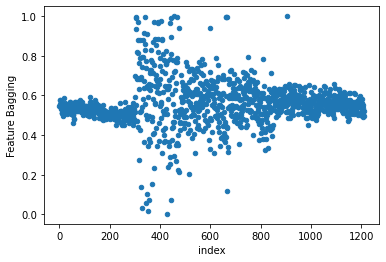

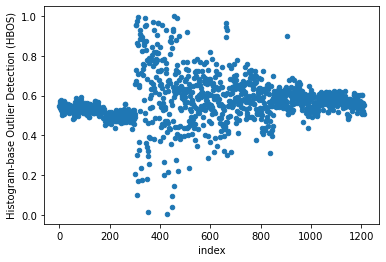

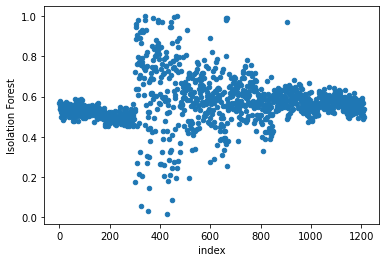

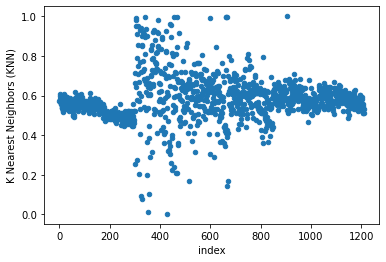

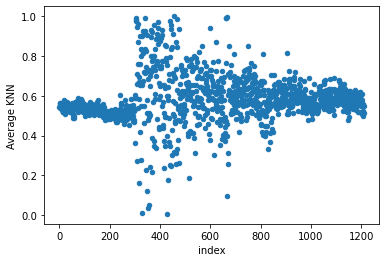

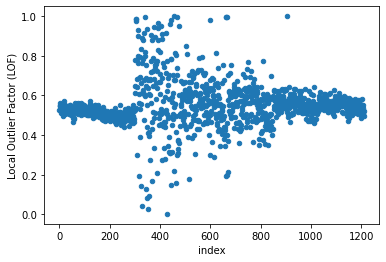

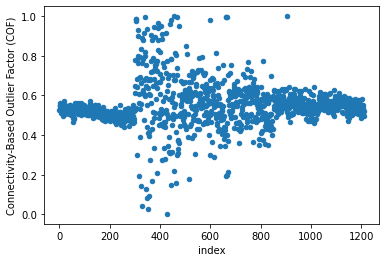

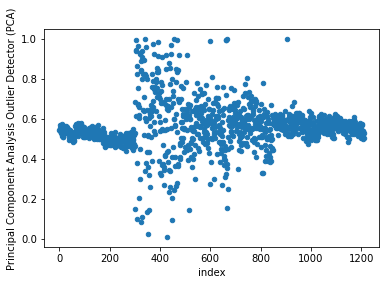

In [153]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in rocDict:
    data = rocDict.get(i)
    tempDF = pd.DataFrame(data,columns=[i])
    tempDF['index']= list(range(1,len(tempDF)+1))
    tempDF.plot(kind="scatter",x='index',y=i)

### 我使用了不同种类的8种方法进行建模，其中单样本检测方法有6种，包括线性模型PCA；基于近邻的方法LOF、COF、KNN、Average KNN、HBOS；以及基于离群值集合的方法Isolation Forest ；和1种离群组合框架方法 Feature Bagging。
### 该问题可以看做二分类问题，由最后的ROC统计散点图可以看出，对于所有的benchmarks文件ROC值普遍在0.5-0.6之间，全部分类方法在第300-500个文件之间，表现出差别较大的性能，可能ROC接近于0，也可能接近于1，总体而言，KNN、average KNN、Isolation Forest以及HBOS的性能较好

## 二、处理 abalone_benchmarks 数据集

### 2.1读取所有csv文件

In [154]:
# 读取所有csv文件
from os import walk
df=[]
for f,_ ,i in walk("F:\\Data Mining\\homework4\\abalone_benchmarks\\abalone\\benchmarks"):
    for j in i:
        temp = pd.read_csv(f+'/'+j)
        df.append(temp)

In [155]:
for subDF in df:
    subDF.columns
    # 保留用于训练和测试的数据属性
    subDF.drop(['motherset', 'origin', 'original.label', 'diff.score'],axis=1,inplace=True)
  
    # 构造数据集
    subDF.dropna(inplace = True)
    subDF['ground.truth']=subDF['ground.truth'].map({'nominal': 0,'anomaly':1})

In [168]:
# 创建保存每个benchmark结果的字典
rocDict = {
       # 'Fast Angle-based Outlier Detector (F_ABOD)': [],
#         'Original Angle-based Outlier Detector (O_ABOD)': [],
#         'Cluster-based Local Outlier Factor (CBLOF)':[],
        'Feature Bagging':[],
        'Histogram-base Outlier Detection (HBOS)':[],
        'Isolation Forest':[],
        'K Nearest Neighbors (KNN)':[],
        'Average KNN': [],
        'Local Outlier Factor (LOF)':[],
        'Connectivity-Based Outlier Factor (COF)':[],
        'Principal Component Analysis Outlier Detector (PCA)':[]
}

In [169]:
for subDF in df:
    
    Y=subDF['ground.truth'].values
    X=subDF.drop(['ground.truth','point.id'],axis=1).values
    
    # 划分训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.35,random_state=0)
    
    #使用上述列表中定义的模型进行训练
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        print("使用"+clf_name+" 进行建模：")
        clf.fit(x_train)
        
        # 返回训练数据x_train上的异常标签和异常分值
        y_train_pred = clf.labels_  
        y_train_scores = clf.decision_scores_ 

        # 用训练好的clf来预测未知数据中的异常值
        # 返回未知数据上的分类标签 (0: 正常值, 1: 异常值)
        y_test_pred = clf.predict(x_test) 

        #  返回未知数据上的异常值 (分值越大越异常)
        y_test_scores = clf.decision_function(x_test) 

        y_train_scores = y_train_scores.reshape(-1,1)
        y_test_scores = y_test_scores.reshape(-1,1)

        # Score 值中出现NaN则转换成0
        if np.isnan(y_train_scores).any():
             y_train_scores = np.nan_to_num(y_train_scores)
        if np.isnan(y_test_scores).any():
             y_test_scores = np.nan_to_num(y_test_scores)

        print("在训练数据集中:")
        try:
            evaluate_print(clf_name, y_train, y_train_scores)
        except:
            print("\nOnly one class present in y_true") 
            
        print("\n在测试数据集中:")
        try:
            evaluate_print(clf_name, y_test, y_test_scores)
        except:
            print("\nOnly one class present in y_true")

        print("=======================")
        
        check_consistent_length(y_test, y_test_scores)                                   
        try:
            roc = np.round(roc_auc_score(y_test, y_test_scores), decimals=4)
        except:
            roc = 0
        prn = np.round(precision_n_scores(y_test, y_test_scores),decimals=4)
        
        rocDict.get(clf_name).append(roc)
        prnDict.get(clf_name).append(prn)
    
    

使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6095, precision @ rank n:0.5709

在测试数据集中:
Feature Bagging ROC:0.59, precision @ rank n:0.5763
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4341, precision @ rank n:0.416

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4702, precision @ rank n:0.4469
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.454, precision @ rank n:0.4307

在测试数据集中:
Isolation Forest ROC:0.4519, precision @ rank n:0.4517
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7025, precision @ rank n:0.6334

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6722, precision @ rank n:0.6293
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7762, precision @ rank n:0.6892

在测试数据集中:
Average KNN ROC:0.7447, precision @ rank n:0.6791
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6023, precision @ rank n:0.5845

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6061

在训练数据集中:
Feature Bagging ROC:0.5454, precision @ rank n:0.5287

在测试数据集中:
Feature Bagging ROC:0.5654, precision @ rank n:0.5788
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4688, precision @ rank n:0.4614

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.501, precision @ rank n:0.5215
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5, precision @ rank n:0.4729

在测试数据集中:
Isolation Forest ROC:0.5213, precision @ rank n:0.5272
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5437, precision @ rank n:0.5222

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5617, precision @ rank n:0.5788
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6487, precision @ rank n:0.6108

在测试数据集中:
Average KNN ROC:0.6532, precision @ rank n:0.6246
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5254, precision @ rank n:0.5025

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5546, precision @ rank n:0.5

在训练数据集中:
Feature Bagging ROC:0.5104, precision @ rank n:0.504

在测试数据集中:
Feature Bagging ROC:0.5075, precision @ rank n:0.4848
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4683, precision @ rank n:0.4588

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.469, precision @ rank n:0.4485
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4723, precision @ rank n:0.4879

在测试数据集中:
Isolation Forest ROC:0.4631, precision @ rank n:0.4636
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4939, precision @ rank n:0.5057

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4912, precision @ rank n:0.4848
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5358, precision @ rank n:0.5315

在测试数据集中:
Average KNN ROC:0.5477, precision @ rank n:0.5364
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5013, precision @ rank n:0.5089

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5028, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5382, precision @ rank n:0.5279

在测试数据集中:
Feature Bagging ROC:0.4851, precision @ rank n:0.4925
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5101, precision @ rank n:0.4951

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4788, precision @ rank n:0.4895
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4885, precision @ rank n:0.4902

在测试数据集中:
Isolation Forest ROC:0.4417, precision @ rank n:0.4505
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5188, precision @ rank n:0.5131

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4713, precision @ rank n:0.4805
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5257, precision @ rank n:0.5262

在测试数据集中:
Average KNN ROC:0.4782, precision @ rank n:0.4715
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.532, precision @ rank n:0.523

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.478, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.6029, precision @ rank n:0.5808

在测试数据集中:
Feature Bagging ROC:0.6059, precision @ rank n:0.591
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5037, precision @ rank n:0.5248

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5321, precision @ rank n:0.5
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5032, precision @ rank n:0.5136

在测试数据集中:
Isolation Forest ROC:0.5335, precision @ rank n:0.5284
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7136, precision @ rank n:0.6704

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7585, precision @ rank n:0.6866
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7739, precision @ rank n:0.7136

在测试数据集中:
Average KNN ROC:0.7782, precision @ rank n:0.7015
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6101, precision @ rank n:0.6112

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6451, precision @ rank n:0.6

在训练数据集中:
Feature Bagging ROC:0.5294, precision @ rank n:0.5439

在测试数据集中:
Feature Bagging ROC:0.5411, precision @ rank n:0.5016
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4978, precision @ rank n:0.5085

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4956, precision @ rank n:0.4598
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4674, precision @ rank n:0.4961

在测试数据集中:
Isolation Forest ROC:0.475, precision @ rank n:0.463
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5631, precision @ rank n:0.5716

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5738, precision @ rank n:0.5434
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6549, precision @ rank n:0.6348

在测试数据集中:
Average KNN ROC:0.6589, precision @ rank n:0.5981
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5232, precision @ rank n:0.5362

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5347, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5202, precision @ rank n:0.4959

在测试数据集中:
Feature Bagging ROC:0.5348, precision @ rank n:0.5138
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5127, precision @ rank n:0.4876

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5256, precision @ rank n:0.5138
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5133, precision @ rank n:0.4992

在测试数据集中:
Isolation Forest ROC:0.5436, precision @ rank n:0.5413
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5408, precision @ rank n:0.5074

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.561, precision @ rank n:0.5382
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5801, precision @ rank n:0.5438

在测试数据集中:
Average KNN ROC:0.5981, precision @ rank n:0.5505
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.523, precision @ rank n:0.4909

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5372, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.5023, precision @ rank n:0.4984

在测试数据集中:
Feature Bagging ROC:0.5383, precision @ rank n:0.5047
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4858, precision @ rank n:0.4936

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5077, precision @ rank n:0.4858
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4753, precision @ rank n:0.4744

在测试数据集中:
Isolation Forest ROC:0.4908, precision @ rank n:0.4606
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4887, precision @ rank n:0.4968

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5189, precision @ rank n:0.4763
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5033, precision @ rank n:0.5032

在测试数据集中:
Average KNN ROC:0.5431, precision @ rank n:0.5237
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4959, precision @ rank n:0.5032

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5198, precision @ rank n

在训练数据集中:
Feature Bagging ROC:0.6003, precision @ rank n:0.5556

在测试数据集中:
Feature Bagging ROC:0.5853, precision @ rank n:0.5762
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4904, precision @ rank n:0.4531

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4748, precision @ rank n:0.4787
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5106, precision @ rank n:0.4618

在测试数据集中:
Isolation Forest ROC:0.5002, precision @ rank n:0.497
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7052, precision @ rank n:0.6389

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6696, precision @ rank n:0.628
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7683, precision @ rank n:0.6771

在测试数据集中:
Average KNN ROC:0.749, precision @ rank n:0.6799
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6109, precision @ rank n:0.5816

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5961, precision @ rank n:0.

Principal Component Analysis Outlier Detector (PCA) ROC:0.4403, precision @ rank n:0.4631
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5717, precision @ rank n:0.5479

在测试数据集中:
Feature Bagging ROC:0.5791, precision @ rank n:0.5432
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4821, precision @ rank n:0.4719

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5077, precision @ rank n:0.4877
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.4951, precision @ rank n:0.4868

在测试数据集中:
Isolation Forest ROC:0.5059, precision @ rank n:0.4938
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5603, precision @ rank n:0.533

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5698, precision @ rank n:0.5432
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6565, precision @ rank n:0.6073

在测试数据集中:
Average KNN ROC:0.6685, precision @ rank n:0.6235
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Facto

在训练数据集中:
Feature Bagging ROC:0.5212, precision @ rank n:0.5199

在测试数据集中:
Feature Bagging ROC:0.535, precision @ rank n:0.5
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4704, precision @ rank n:0.4689

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4727, precision @ rank n:0.4455
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5033, precision @ rank n:0.5104

在测试数据集中:
Isolation Forest ROC:0.5241, precision @ rank n:0.5064
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5152, precision @ rank n:0.5167

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5291, precision @ rank n:0.4968
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5499, precision @ rank n:0.5423

在测试数据集中:
Average KNN ROC:0.5674, precision @ rank n:0.5353
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5237, precision @ rank n:0.5247

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5368, precision @ rank n:0.5

Principal Component Analysis Outlier Detector (PCA) ROC:0.4868, precision @ rank n:0.5096

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4835, precision @ rank n:0.5171
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5307, precision @ rank n:0.5199

在测试数据集中:
Feature Bagging ROC:0.522, precision @ rank n:0.542
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5063, precision @ rank n:0.4834

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.5114, precision @ rank n:0.5275
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5033, precision @ rank n:0.5066

在测试数据集中:
Isolation Forest ROC:0.4858, precision @ rank n:0.5217
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5197, precision @ rank n:0.495

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5078, precision @ rank n:0.5275
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5492, precision @ rank n:0.5232

在测试数据集中:
Average KNN ROC

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5077, precision @ rank n:0.5156

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.524, precision @ rank n:0.5062
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4794, precision @ rank n:0.4953

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.492, precision @ rank n:0.4691
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5371, precision @ rank n:0.5173

在测试数据集中:
Feature Bagging ROC:0.5403, precision @ rank n:0.5341
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8669, precision @ rank n:0.7617

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8834, precision @ rank n:0.803
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.6032, precision @ rank n:0.558

在测试数据集中:
Isolation Forest ROC:0.6072, precision @ rank n:0.5795
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4695, precision @ rank n:0.4846

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5034, precision @ rank n:0.5037
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4992, precision @ rank n:0.5143

在测试数据集中:
Feature Bagging ROC:0.5137, precision @ rank n:0.5093
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7002, precision @ rank n:0.6381

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7035, precision @ rank n:0.6357
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5426, precision @ rank n:0.5486

在测试数据集中:
Isolation Forest ROC:0.5432, precision @ rank n:0.5279
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5923, precision @ rank n:0.5714

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5921, precision @ rank n:0.5613
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6263, precision @ rank n:0.6076

在测试数据集中:
Ave

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5413, precision @ rank n:0.5161

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5726, precision @ rank n:0.5455
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.514, precision @ rank n:0.5141

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5283, precision @ rank n:0.5091
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5111, precision @ rank n:0.504

在测试数据集中:
Feature Bagging ROC:0.5198, precision @ rank n:0.5057
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7238, precision @ rank n:0.6607

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7532, precision @ rank n:0.6882
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.5746, precision @ rank n:0.5456

在测试数据集中:
Isolation Forest ROC:0.5884, precision @ rank n:0.5551
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集

Local Outlier Factor (LOF) ROC:0.52, precision @ rank n:0.4804

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.555, precision @ rank n:0.5315
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.52, precision @ rank n:0.4804

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.555, precision @ rank n:0.5315
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5114, precision @ rank n:0.501

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5356, precision @ rank n:0.4961
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6167, precision @ rank n:0.595

在测试数据集中:
Feature Bagging ROC:0.605, precision @ rank n:0.5725
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8459, precision @ rank n:0.8058

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8171, precision @ rank n:0.7509
使用Isolation F

使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9846, precision @ rank n:0.9522

在测试数据集中:
Average KNN ROC:0.977, precision @ rank n:0.9234
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6137, precision @ rank n:0.6056

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5737, precision @ rank n:0.5556
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6137, precision @ rank n:0.6056

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5737, precision @ rank n:0.5556
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.497, precision @ rank n:0.496

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4711, precision @ rank n:0.4444
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5666, precision @ rank n:0.5753

在测试数据集中:
Feature Bagging ROC:0.5557, precision @ rank n:0.5075
使用Histogram-base Outlier Detection (HBOS) 进行建模：

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6585, precision @ rank n:0.5917

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7213, precision @ rank n:0.6747
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8192, precision @ rank n:0.7396

在测试数据集中:
Average KNN ROC:0.8405, precision @ rank n:0.7808
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5365, precision @ rank n:0.5062

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6132, precision @ rank n:0.6164
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5365, precision @ rank n:0.5062

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6132, precision @ rank n:0.6164
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.531, precision @ rank n:0.4979

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.557, precision @ rank n:0.5788
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging R

在训练数据集中:
Isolation Forest ROC:0.4759, precision @ rank n:0.4873

在测试数据集中:
Isolation Forest ROC:0.4858, precision @ rank n:0.521
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.611, precision @ rank n:0.5832

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6283, precision @ rank n:0.5979
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6404, precision @ rank n:0.5871

在测试数据集中:
Average KNN ROC:0.6505, precision @ rank n:0.6224
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5345, precision @ rank n:0.5382

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5432, precision @ rank n:0.549
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5345, precision @ rank n:0.5382

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5432, precision @ rank n:0.549
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5055, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5007, precision @ rank n:0.507

在测试数据集中:
Isolation Forest ROC:0.4894, precision @ rank n:0.5105
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5473, precision @ rank n:0.5392

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5347, precision @ rank n:0.5315
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5454, precision @ rank n:0.5352

在测试数据集中:
Average KNN ROC:0.5428, precision @ rank n:0.5594
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5131, precision @ rank n:0.5171

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5017, precision @ rank n:0.521
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5131, precision @ rank n:0.5171

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5017, precision @ rank n:0.521
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5097, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5761, precision @ rank n:0.5479

在测试数据集中:
Isolation Forest ROC:0.5637, precision @ rank n:0.5461
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9213, precision @ rank n:0.8729

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9159, precision @ rank n:0.8745
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.978, precision @ rank n:0.9312

在测试数据集中:
Average KNN ROC:0.9751, precision @ rank n:0.9336
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5921, precision @ rank n:0.5708

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6033, precision @ rank n:0.6015
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5921, precision @ rank n:0.5708

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6033, precision @ rank n:0.6015
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5068, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5573, precision @ rank n:0.537

在测试数据集中:
Isolation Forest ROC:0.5535, precision @ rank n:0.5665
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6335, precision @ rank n:0.5891

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6274, precision @ rank n:0.5932
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7885, precision @ rank n:0.7109

在测试数据集中:
Average KNN ROC:0.7931, precision @ rank n:0.7338
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5314, precision @ rank n:0.5065

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5238, precision @ rank n:0.5247
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5314, precision @ rank n:0.5065

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5238, precision @ rank n:0.5247
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5329, precision @ 

在训练数据集中:
Isolation Forest ROC:0.5509, precision @ rank n:0.54

在测试数据集中:
Isolation Forest ROC:0.5493, precision @ rank n:0.5615
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5779, precision @ rank n:0.5594

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5556, precision @ rank n:0.5538
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6088, precision @ rank n:0.5832

在测试数据集中:
Average KNN ROC:0.6017, precision @ rank n:0.5846
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5095, precision @ rank n:0.5054

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4869, precision @ rank n:0.5154
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5095, precision @ rank n:0.5054

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4869, precision @ rank n:0.5154
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5222, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5124, precision @ rank n:0.5161

在测试数据集中:
Isolation Forest ROC:0.4637, precision @ rank n:0.439
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.53, precision @ rank n:0.5225

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4973, precision @ rank n:0.4797
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5312, precision @ rank n:0.5118

在测试数据集中:
Average KNN ROC:0.5328, precision @ rank n:0.5081
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5143, precision @ rank n:0.5032

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4835, precision @ rank n:0.4634
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5143, precision @ rank n:0.5032

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4835, precision @ rank n:0.4634
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5185, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.4956, precision @ rank n:0.4567

在测试数据集中:
Isolation Forest ROC:0.5092, precision @ rank n:0.4534
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.696, precision @ rank n:0.6073

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.672, precision @ rank n:0.5981
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7739, precision @ rank n:0.6799

在测试数据集中:
Average KNN ROC:0.7722, precision @ rank n:0.6752
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6196, precision @ rank n:0.5813

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6295, precision @ rank n:0.5852
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6196, precision @ rank n:0.5813

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6295, precision @ rank n:0.5852
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4818, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4802, precision @ rank n:0.4789

在测试数据集中:
Isolation Forest ROC:0.4467, precision @ rank n:0.4475
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5611, precision @ rank n:0.5422

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.51, precision @ rank n:0.4877
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6521, precision @ rank n:0.6023

在测试数据集中:
Average KNN ROC:0.6197, precision @ rank n:0.5617
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5435, precision @ rank n:0.5357

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4946, precision @ rank n:0.4846
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5435, precision @ rank n:0.5357

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4946, precision @ rank n:0.4846
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4626, precision @ r

在训练数据集中:
Isolation Forest ROC:0.498, precision @ rank n:0.5105

在测试数据集中:
Isolation Forest ROC:0.5046, precision @ rank n:0.4745
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.556, precision @ rank n:0.5251

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5441, precision @ rank n:0.5191
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5982, precision @ rank n:0.5575

在测试数据集中:
Average KNN ROC:0.6003, precision @ rank n:0.5478
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5586, precision @ rank n:0.5397

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5454, precision @ rank n:0.5064
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5586, precision @ rank n:0.5397

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5454, precision @ rank n:0.5064
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4943, precision @ r

在训练数据集中:
Isolation Forest ROC:0.5652, precision @ rank n:0.5208

在测试数据集中:
Isolation Forest ROC:0.5684, precision @ rank n:0.5382
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5374, precision @ rank n:0.4948

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5251, precision @ rank n:0.5138
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5494, precision @ rank n:0.5052

在测试数据集中:
Average KNN ROC:0.5332, precision @ rank n:0.5229
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5302, precision @ rank n:0.4965

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.525, precision @ rank n:0.5138
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5302, precision @ rank n:0.4965

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.525, precision @ rank n:0.5138
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5068, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4999, precision @ rank n:0.496

在测试数据集中:
Isolation Forest ROC:0.5035, precision @ rank n:0.5075
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7233, precision @ rank n:0.6586

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7007, precision @ rank n:0.6366
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7791, precision @ rank n:0.7069

在测试数据集中:
Average KNN ROC:0.778, precision @ rank n:0.7147
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6163, precision @ rank n:0.62

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5982, precision @ rank n:0.6006
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6163, precision @ rank n:0.62

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5982, precision @ rank n:0.6006
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4713, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.4427, precision @ rank n:0.4687

在测试数据集中:
Isolation Forest ROC:0.4517, precision @ rank n:0.482
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5364, precision @ rank n:0.5185

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5491, precision @ rank n:0.5389
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6383, precision @ rank n:0.61

在测试数据集中:
Average KNN ROC:0.6554, precision @ rank n:0.6257
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5328, precision @ rank n:0.5233

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5466, precision @ rank n:0.5419
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5328, precision @ rank n:0.5233

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5466, precision @ rank n:0.5419
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4734, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.4877, precision @ rank n:0.4917

在测试数据集中:
Isolation Forest ROC:0.5099, precision @ rank n:0.5162
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5093, precision @ rank n:0.5033

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5307, precision @ rank n:0.5221
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5523, precision @ rank n:0.5182

在测试数据集中:
Average KNN ROC:0.557, precision @ rank n:0.5487
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4897, precision @ rank n:0.4818

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5037, precision @ rank n:0.5192
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4897, precision @ rank n:0.4818

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5037, precision @ rank n:0.5192
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4708, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4903, precision @ rank n:0.5182

在测试数据集中:
Isolation Forest ROC:0.4961, precision @ rank n:0.4908
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5147, precision @ rank n:0.5261

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.522, precision @ rank n:0.5184
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5248, precision @ rank n:0.5308

在测试数据集中:
Average KNN ROC:0.5372, precision @ rank n:0.5123
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5199, precision @ rank n:0.5324

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5228, precision @ rank n:0.5245
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5199, precision @ rank n:0.5324

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5228, precision @ rank n:0.5245
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4919, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4714, precision @ rank n:0.488

在测试数据集中:
Isolation Forest ROC:0.499, precision @ rank n:0.5029
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6948, precision @ rank n:0.6571

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7282, precision @ rank n:0.7029
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7728, precision @ rank n:0.7018

在测试数据集中:
Average KNN ROC:0.8016, precision @ rank n:0.7429
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6052, precision @ rank n:0.6029

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.645, precision @ rank n:0.6457
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6052, precision @ rank n:0.6029

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.645, precision @ rank n:0.6457
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4823, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5224, precision @ rank n:0.5464

在测试数据集中:
Isolation Forest ROC:0.4586, precision @ rank n:0.4622
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5948, precision @ rank n:0.5759

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.535, precision @ rank n:0.5196
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6886, precision @ rank n:0.6548

在测试数据集中:
Average KNN ROC:0.6417, precision @ rank n:0.5921
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5758, precision @ rank n:0.565

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5134, precision @ rank n:0.5076
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5758, precision @ rank n:0.565

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5134, precision @ rank n:0.5076
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5086, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.4662, precision @ rank n:0.488

在测试数据集中:
Isolation Forest ROC:0.4724, precision @ rank n:0.4956
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5159, precision @ rank n:0.5201

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5178, precision @ rank n:0.5398
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5791, precision @ rank n:0.565

在测试数据集中:
Average KNN ROC:0.5564, precision @ rank n:0.5634
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5475, precision @ rank n:0.557

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5415, precision @ rank n:0.5693
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5475, precision @ rank n:0.557

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5415, precision @ rank n:0.5693
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4745, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5143, precision @ rank n:0.4848

在测试数据集中:
Isolation Forest ROC:0.5869, precision @ rank n:0.5983
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5097, precision @ rank n:0.4899

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5505, precision @ rank n:0.5651
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.524, precision @ rank n:0.5034

在测试数据集中:
Average KNN ROC:0.5416, precision @ rank n:0.5734
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5263, precision @ rank n:0.5

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5522, precision @ rank n:0.5762
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5263, precision @ rank n:0.5

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5522, precision @ rank n:0.5762
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4842, precision @ rank n

在训练数据集中:
Isolation Forest ROC:0.4953, precision @ rank n:0.4902

在测试数据集中:
Isolation Forest ROC:0.4949, precision @ rank n:0.5307
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6548, precision @ rank n:0.623

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6634, precision @ rank n:0.6425
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7219, precision @ rank n:0.6492

在测试数据集中:
Average KNN ROC:0.7329, precision @ rank n:0.7011
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5945, precision @ rank n:0.5918

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6154, precision @ rank n:0.6369
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5945, precision @ rank n:0.5918

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6154, precision @ rank n:0.6369
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4864, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4903, precision @ rank n:0.5032

在测试数据集中:
Isolation Forest ROC:0.4788, precision @ rank n:0.5119
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5444, precision @ rank n:0.5324

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5347, precision @ rank n:0.5357
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6294, precision @ rank n:0.5955

在测试数据集中:
Average KNN ROC:0.6186, precision @ rank n:0.6101
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5476, precision @ rank n:0.5421

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5282, precision @ rank n:0.5238
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5476, precision @ rank n:0.5421

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5282, precision @ rank n:0.5238
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4861, precision @

在训练数据集中:
Isolation Forest ROC:0.4633, precision @ rank n:0.4745

在测试数据集中:
Isolation Forest ROC:0.4632, precision @ rank n:0.4615
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5073, precision @ rank n:0.4893

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5341, precision @ rank n:0.5169
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5344, precision @ rank n:0.5222

在测试数据集中:
Average KNN ROC:0.5755, precision @ rank n:0.5415
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5205, precision @ rank n:0.4992

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5546, precision @ rank n:0.5446
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5205, precision @ rank n:0.4992

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5546, precision @ rank n:0.5446
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4837, precision @

在训练数据集中:
Isolation Forest ROC:0.462, precision @ rank n:0.459

在测试数据集中:
Isolation Forest ROC:0.4872, precision @ rank n:0.4907
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.492, precision @ rank n:0.4918

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4911, precision @ rank n:0.4815
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5085, precision @ rank n:0.5016

在测试数据集中:
Average KNN ROC:0.4977, precision @ rank n:0.4907
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5057, precision @ rank n:0.5131

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5039, precision @ rank n:0.4846
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5057, precision @ rank n:0.5131

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5039, precision @ rank n:0.4846
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.472, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5156, precision @ rank n:0.5491

在测试数据集中:
Isolation Forest ROC:0.4925, precision @ rank n:0.4585
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6601, precision @ rank n:0.6534

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6118, precision @ rank n:0.5692
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7452, precision @ rank n:0.6963

在测试数据集中:
Average KNN ROC:0.6923, precision @ rank n:0.6246
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5923, precision @ rank n:0.6135

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5718, precision @ rank n:0.5662
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5923, precision @ rank n:0.6135

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5718, precision @ rank n:0.5662
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4849, precision @

在训练数据集中:
Isolation Forest ROC:0.5012, precision @ rank n:0.4976

在测试数据集中:
Isolation Forest ROC:0.5212, precision @ rank n:0.5031
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5294, precision @ rank n:0.5361

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.55, precision @ rank n:0.5186
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.611, precision @ rank n:0.5746

在测试数据集中:
Average KNN ROC:0.6283, precision @ rank n:0.5839
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5369, precision @ rank n:0.5441

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5603, precision @ rank n:0.5342
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5369, precision @ rank n:0.5441

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5603, precision @ rank n:0.5342
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4842, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5181, precision @ rank n:0.5074

在测试数据集中:
Isolation Forest ROC:0.4953, precision @ rank n:0.4815
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5121, precision @ rank n:0.5107

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4944, precision @ rank n:0.4969
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.546, precision @ rank n:0.5189

在测试数据集中:
Average KNN ROC:0.5152, precision @ rank n:0.4907
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5158, precision @ rank n:0.5107

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4955, precision @ rank n:0.4877
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5158, precision @ rank n:0.5107

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4955, precision @ rank n:0.4877
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4891, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4878, precision @ rank n:0.5196

在测试数据集中:
Isolation Forest ROC:0.5039, precision @ rank n:0.4906
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5029, precision @ rank n:0.5243

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5084, precision @ rank n:0.4874
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5153, precision @ rank n:0.5243

在测试数据集中:
Average KNN ROC:0.5203, precision @ rank n:0.4811
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5064, precision @ rank n:0.5211

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5065, precision @ rank n:0.4811
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5064, precision @ rank n:0.5211

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5065, precision @ rank n:0.4811
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4827, precision @

在训练数据集中:
Isolation Forest ROC:0.5128, precision @ rank n:0.521

在测试数据集中:
Isolation Forest ROC:0.5075, precision @ rank n:0.532
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6564, precision @ rank n:0.6323

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6551, precision @ rank n:0.6366
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7217, precision @ rank n:0.6661

在测试数据集中:
Average KNN ROC:0.7299, precision @ rank n:0.6919
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5908, precision @ rank n:0.5919

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.602, precision @ rank n:0.6047
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5908, precision @ rank n:0.5919

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.602, precision @ rank n:0.6047
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4825, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5242, precision @ rank n:0.4966

在测试数据集中:
Isolation Forest ROC:0.4656, precision @ rank n:0.4667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.538, precision @ rank n:0.4966

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4769, precision @ rank n:0.4818
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6204, precision @ rank n:0.5721

在测试数据集中:
Average KNN ROC:0.5686, precision @ rank n:0.5576
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5161, precision @ rank n:0.4866

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4564, precision @ rank n:0.4424
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5161, precision @ rank n:0.4866

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4564, precision @ rank n:0.4424
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4923, precision @ 

在训练数据集中:
Isolation Forest ROC:0.474, precision @ rank n:0.4865

在测试数据集中:
Isolation Forest ROC:0.4892, precision @ rank n:0.4954
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5197, precision @ rank n:0.523

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5429, precision @ rank n:0.535
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.567, precision @ rank n:0.5578

在测试数据集中:
Average KNN ROC:0.5753, precision @ rank n:0.5593
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5125, precision @ rank n:0.5182

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5391, precision @ rank n:0.538
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5125, precision @ rank n:0.5182

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5391, precision @ rank n:0.538
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4833, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.4729, precision @ rank n:0.4802

在测试数据集中:
Isolation Forest ROC:0.4375, precision @ rank n:0.4592
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5204, precision @ rank n:0.5132

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4821, precision @ rank n:0.4864
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5291, precision @ rank n:0.5116

在测试数据集中:
Average KNN ROC:0.4878, precision @ rank n:0.4834
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5288, precision @ rank n:0.5231

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4837, precision @ rank n:0.4834
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5288, precision @ rank n:0.5231

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4837, precision @ rank n:0.4834
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5005, precision @

在训练数据集中:
Isolation Forest ROC:0.4362, precision @ rank n:0.2866

在测试数据集中:
Isolation Forest ROC:0.4371, precision @ rank n:0.2754
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3752, precision @ rank n:0.2461

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3895, precision @ rank n:0.2275
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3155, precision @ rank n:0.1776

在测试数据集中:
Average KNN ROC:0.3518, precision @ rank n:0.1856
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3728, precision @ rank n:0.2181

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3893, precision @ rank n:0.2335
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3728, precision @ rank n:0.2181

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3893, precision @ rank n:0.2335
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5146, precision @

在训练数据集中:
Isolation Forest ROC:0.4723, precision @ rank n:0.3133

在测试数据集中:
Isolation Forest ROC:0.4623, precision @ rank n:0.3143
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4815, precision @ rank n:0.3228

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4899, precision @ rank n:0.3143
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4348, precision @ rank n:0.2848

在测试数据集中:
Average KNN ROC:0.4246, precision @ rank n:0.2743
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4803, precision @ rank n:0.3133

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4833, precision @ rank n:0.3086
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4803, precision @ rank n:0.3133

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4833, precision @ rank n:0.3086
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5022, precision @

在训练数据集中:
Isolation Forest ROC:0.4745, precision @ rank n:0.3261

在测试数据集中:
Isolation Forest ROC:0.5179, precision @ rank n:0.35
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4916, precision @ rank n:0.3292

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5076, precision @ rank n:0.35
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4824, precision @ rank n:0.3012

在测试数据集中:
Average KNN ROC:0.4713, precision @ rank n:0.3
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.488, precision @ rank n:0.3199

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5079, precision @ rank n:0.3444
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.488, precision @ rank n:0.3199

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5079, precision @ rank n:0.3444
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4892, precision @ rank n:0

在训练数据集中:
Isolation Forest ROC:0.5048, precision @ rank n:0.3529

在测试数据集中:
Isolation Forest ROC:0.4776, precision @ rank n:0.2909
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5171, precision @ rank n:0.3622

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4886, precision @ rank n:0.3212
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5186, precision @ rank n:0.3622

在测试数据集中:
Average KNN ROC:0.4677, precision @ rank n:0.2909
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5176, precision @ rank n:0.3622

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4876, precision @ rank n:0.3152
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5176, precision @ rank n:0.3622

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4876, precision @ rank n:0.3152
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.522, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4271, precision @ rank n:0.3057

在测试数据集中:
Isolation Forest ROC:0.3891, precision @ rank n:0.2882
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3983, precision @ rank n:0.2643

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3414, precision @ rank n:0.2059
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3296, precision @ rank n:0.1879

在测试数据集中:
Average KNN ROC:0.2628, precision @ rank n:0.1235
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.398, precision @ rank n:0.2484

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3404, precision @ rank n:0.1765
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.398, precision @ rank n:0.2484

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3404, precision @ rank n:0.1765
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5002, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4507, precision @ rank n:0.2809

在测试数据集中:
Isolation Forest ROC:0.4394, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4793, precision @ rank n:0.3241

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4617, precision @ rank n:0.2875
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4264, precision @ rank n:0.2623

在测试数据集中:
Average KNN ROC:0.3876, precision @ rank n:0.2375
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4795, precision @ rank n:0.3272

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4535, precision @ rank n:0.2875
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4795, precision @ rank n:0.3272

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4535, precision @ rank n:0.2875
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4964, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4867, precision @ rank n:0.3323

在测试数据集中:
Isolation Forest ROC:0.4741, precision @ rank n:0.3514
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4798, precision @ rank n:0.3419

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4838, precision @ rank n:0.3622
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4578, precision @ rank n:0.3131

在测试数据集中:
Average KNN ROC:0.4835, precision @ rank n:0.3892
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4785, precision @ rank n:0.3291

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4873, precision @ rank n:0.3622
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4785, precision @ rank n:0.3291

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4873, precision @ rank n:0.3622
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4946, precision @

在训练数据集中:
Isolation Forest ROC:0.4702, precision @ rank n:0.3019

在测试数据集中:
Isolation Forest ROC:0.5123, precision @ rank n:0.3622
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4969, precision @ rank n:0.3149

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5021, precision @ rank n:0.3514
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4943, precision @ rank n:0.3279

在测试数据集中:
Average KNN ROC:0.5098, precision @ rank n:0.373
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5005, precision @ rank n:0.3117

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5027, precision @ rank n:0.3514
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5005, precision @ rank n:0.3117

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5027, precision @ rank n:0.3514
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4986, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4317, precision @ rank n:0.2975

在测试数据集中:
Isolation Forest ROC:0.4497, precision @ rank n:0.2983
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.379, precision @ rank n:0.2532

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3872, precision @ rank n:0.2486
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3098, precision @ rank n:0.1741

在测试数据集中:
Average KNN ROC:0.3374, precision @ rank n:0.1989
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3718, precision @ rank n:0.2247

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3859, precision @ rank n:0.2155
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3718, precision @ rank n:0.2247

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3859, precision @ rank n:0.2155
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4968, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4628, precision @ rank n:0.3062

在测试数据集中:
Isolation Forest ROC:0.494, precision @ rank n:0.3476
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4665, precision @ rank n:0.3062

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4927, precision @ rank n:0.3583
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4302, precision @ rank n:0.2704

在测试数据集中:
Average KNN ROC:0.4313, precision @ rank n:0.3102
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4722, precision @ rank n:0.3094

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4944, precision @ rank n:0.3636
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4722, precision @ rank n:0.3094

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4944, precision @ rank n:0.3636
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4852, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4728, precision @ rank n:0.3072

在测试数据集中:
Isolation Forest ROC:0.5053, precision @ rank n:0.3529
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.481, precision @ rank n:0.326

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5562, precision @ rank n:0.3706
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4535, precision @ rank n:0.3009

在测试数据集中:
Average KNN ROC:0.5273, precision @ rank n:0.3588
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4748, precision @ rank n:0.3072

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5496, precision @ rank n:0.3471
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4748, precision @ rank n:0.3072

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5496, precision @ rank n:0.3471
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5004, precision @ r

在训练数据集中:
Isolation Forest ROC:0.487, precision @ rank n:0.3192

在测试数据集中:
Isolation Forest ROC:0.4793, precision @ rank n:0.3295
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4843, precision @ rank n:0.2997

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5058, precision @ rank n:0.3409
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4711, precision @ rank n:0.3062

在测试数据集中:
Average KNN ROC:0.4946, precision @ rank n:0.3125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4829, precision @ rank n:0.2932

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5075, precision @ rank n:0.3523
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4829, precision @ rank n:0.2932

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5075, precision @ rank n:0.3523
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4942, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6778, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9758, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8303, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9758, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8491, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9076, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9649, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9348, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9649, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9348, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4878, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8858, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4303, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9405, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4318, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8328, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7545, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8475, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3409, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8475, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3409, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9405, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8785, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8152, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9372, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6545, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9747, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4712, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9388, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5864, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9388, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5864, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8915, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8801, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9864, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8091, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6333, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7724, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.447, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7162, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5424, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7162, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5424, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9241, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.9861, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7485, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9918, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8591, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9772, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8333, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9649, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8288, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9649, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8288, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9951, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.455, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9972, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4249, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9025, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3213, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9276, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3123, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8747, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3123, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8747, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.53, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.4747, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9379, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6729, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6288, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6272, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6379, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6223, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6015, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6223, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6015, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3042, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.9935, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.99, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8019, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9518, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6645, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9297, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7251, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9378, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7251, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9378, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9924, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.2569, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3167, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4804, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5561, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7496, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5803, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.2463, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6424, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2463, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6424, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.1175, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8369, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9773, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6533, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9803, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7153, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9788, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5726, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9591, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5726, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9591, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9013, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7896, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.75, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6558, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9152, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5897, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.85, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.646, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9167, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.646, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9167, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7822, precision @ rank n:0.0

在测试数据集中:
Principal Comp

在训练数据集中:
Isolation Forest ROC:0.3801, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9727, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.2626, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9106, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.084, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9212, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.1297, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8621, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.1297, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8621, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3475, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.2447, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7652, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5033, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8621, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7455, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8894, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3622, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7985, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3622, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7985, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2031, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.9307, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7288, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9038, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6773, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8891, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9091, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8165, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7333, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8165, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7333, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.938, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.885, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9197, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7618, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6076, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8377, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5712, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6305, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4985, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6305, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4985, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8785, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.6754, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.947, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6566, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.897, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8424, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8364, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8364, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8736, precision @ rank n:0.0

在测试数据集中:
Principal Com

在训练数据集中:
Isolation Forest ROC:0.9992, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8364, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8742, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9976, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9045, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9967, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8424, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9967, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8424, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Comp

在训练数据集中:
Isolation Forest ROC:0.6069, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9985, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5767, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9985, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8303, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9955, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9924, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9924, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4111, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9957, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9967, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9978, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9978, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Analysis 

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9946, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9955, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9936, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9936, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9991, precision @ rank n:0.0

在测试数据集中:
Principal Component Analys

在训练数据集中:
Isolation Forest ROC:0.9527, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6152, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9535, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.647, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9625, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6773, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8866, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2379, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8866, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2379, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9486, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.9192, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8409, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9445, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.747, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9649, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8379, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8752, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5182, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8752, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5182, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9331, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5889, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6197, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3206, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8061, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4372, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7682, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.2333, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.803, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2333, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.803, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3352, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.9608, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9803, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9209, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.947, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7838, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9348, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8874, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9288, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8874, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9288, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9543, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.6852, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8728, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9502, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9192, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9192, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.429, precision @ rank n:0.0

在测试数据集中:
Principal Component Anal

在训练数据集中:
Isolation Forest ROC:0.969, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5242, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8336, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5394, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6558, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5258, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7162, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5152, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7162, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5152, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9755, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5481, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4727, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6542, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3152, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6827, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3485, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.739, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2667, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.739, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2667, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5294, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.7023, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7636, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4258, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6167, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.407, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6727, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3801, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5864, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3801, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5864, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7928, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.9976, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9152, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9984, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9394, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9992, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9742, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9959, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9758, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9959, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9758, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9984, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7953, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.0872, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6376, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1821, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5768, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0513, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6003, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.1462, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6003, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.1462, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9225, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.2065, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9836, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.556, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8219, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7212, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7863, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5959, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5959, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3687, precision @ rank n:0.0

在测试数据集中:
Principal Compo

在训练数据集中:
Isolation Forest ROC:0.9989, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.904, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9247, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.81, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9107, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.792, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9333, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.77, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9333, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.77, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9989, precision @ rank n:0.0

在测试数据集中:
Principal Compon

在训练数据集中:
Isolation Forest ROC:0.4812, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.1318, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5734, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3121, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8556, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3152, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8148, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.0136, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8148, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0136, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.0701, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8695, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7364, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9217, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8379, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9209, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8818, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9192, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8258, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9192, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8258, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8165, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.9029, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.997, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7708, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9455, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7414, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9227, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6607, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8864, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6607, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8864, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9307, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.4192, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.1621, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.2871, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3015, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.1623, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3242, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.2757, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2818, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2757, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2818, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3401, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8276, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.624, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7572, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6726, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7297, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0051, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6166, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6957, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6166, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6957, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8166, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.4387, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3207, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5463, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1263, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7384, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0051, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6417, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.0808, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6417, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0808, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4441, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.1294, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6212, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.1499, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6667, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2439, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7121, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.2112, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6591, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2112, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6591, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2766, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.1355, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8967, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.0596, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.869, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.1897, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8892, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.0163, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.864, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0163, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.864, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.0691, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.6581, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2682, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7095, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4286, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.0514, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7469, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.406, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.406, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.827, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.7, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.934, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6863, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8274, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.663, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6371, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6507, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7995, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6507, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7995, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8219, precision @ rank n:0.0

在测试数据集中:
Principal Com

在训练数据集中:
Isolation Forest ROC:0.2742, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3519, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.1392, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.2076, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.0941, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0785, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.1255, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2076, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.1255, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2076, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3929, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.2626, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7298, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.2585, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8864, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3211, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8485, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.1605, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8864, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.1605, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8864, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2939, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.0014, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.0152, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.015, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1139, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.0806, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3544, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.0014, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.043, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0014, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.043, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3183, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.5821, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2695, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8019, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4408, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6879, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3224, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8114, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4307, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8114, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4307, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6594, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.2169, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4684, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3124, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3696, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4052, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4228, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3151, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3392, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3151, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3392, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.1378, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.1719, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7772, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4025, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5519, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3192, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3013, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4175, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.557, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4175, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.557, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2988, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.7705, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8595, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.82, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8742, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8404, precision @ rank n:0.1667

在测试数据集中:
Average KNN ROC:0.9023, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7363, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.822, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7363, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.822, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7519, precision @ rank n:0.1667

在测试数据集中:


在训练数据集中:
Isolation Forest ROC:0.8081, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6561, precision @ rank n:0.2
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7726, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5982, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.852, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6561, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7258, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.59, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7258, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.59, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7557, precision @ rank n:0.0

在测试数据集中:
Principal Com

在训练数据集中:
Isolation Forest ROC:0.5456, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.566, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5421, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5539, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5547, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5147, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5328, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5429, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5328, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5429, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5751, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.8952, precision @ rank n:0.25

在测试数据集中:
Isolation Forest ROC:0.8133, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8343, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7373, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7962, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6958, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8143, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7277, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8143, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7277, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.855, precision @ rank n:0.25

在测试数据集中:
Princip

在训练数据集中:
Isolation Forest ROC:0.7031, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.9018, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7655, precision @ rank n:0.125

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9162, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8023, precision @ rank n:0.125

在测试数据集中:
Average KNN ROC:0.8739, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7022, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7696, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7022, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7696, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6079, precision @ rank n:0.125

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.8559, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.7879, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8355, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8337, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8203, precision @ rank n:0.1667

在测试数据集中:
Average KNN ROC:0.8367, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8256, precision @ rank n:0.1667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8299, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8256, precision @ rank n:0.1667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8299, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.749, precision @ rank n:0.1667


在训练数据集中:
Isolation Forest ROC:0.7707, precision @ rank n:0.25

在测试数据集中:
Isolation Forest ROC:0.8172, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7288, precision @ rank n:0.25

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9343, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6886, precision @ rank n:0.125

在测试数据集中:
Average KNN ROC:0.8875, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6839, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9041, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6839, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9041, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7576, precision @ rank n:0.25

在测试数据集中:

在训练数据集中:
Isolation Forest ROC:0.8339, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.7958, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8231, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7659, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7249, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7186, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.814, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7723, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.814, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7723, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8373, precision @ rank n:0.0

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.6427, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7096, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7363, precision @ rank n:0.2

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7854, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7922, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.6792, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6936, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4692, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6936, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4692, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4538, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.4176, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3948, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5104, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4914, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5209, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5211, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5723, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5396, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5723, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5396, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3348, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6057, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4927, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5747, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5401, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5868, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5673, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5551, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5532, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5551, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5532, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6279, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7228, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6924, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4648, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5288, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4201, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5561, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4352, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.497, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4352, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.497, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7395, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Analysis Outlier Dete

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Average KNN ROC:0.9989, precision @ rank n:0.6667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9989, precision @ rank n:0.6667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9989, precision @ rank n:0.6667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Ana

在训练数据集中:
Isolation Forest ROC:0.9605, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7201, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8041, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5855, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7637, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6784, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7758, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5972, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7758, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5972, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9751, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.9704, precision @ rank n:0.75

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9076, precision @ rank n:0.25

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9873, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.893, precision @ rank n:0.25

在测试数据集中:
Average KNN ROC:0.9873, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9094, precision @ rank n:0.25

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.981, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9094, precision @ rank n:0.25

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.981, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.991, precision @ rank n:0.75

在测试数据集中:
Principal

Average KNN ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9807, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9807, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9662, precision @ rank n:0.5
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.8798, precision @ rank n:0.3333

在测试数据集中:
Feature Bagging ROC:0.947, precision @ rank n:0.5
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.95, precision

在训练数据集中:
Average KNN ROC:0.891, precision @ rank n:0.3333

在测试数据集中:
Average KNN ROC:0.9759, precision @ rank n:0.5
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8691, precision @ rank n:0.3333

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9084, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8691, precision @ rank n:0.3333

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9084, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9591, precision @ rank n:0.6667

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.992, precision @ rank n:0.5
使用Feature Bagging 进行建模：
在训练数据集中:

Only one class present in y_true

在测试数据集中:
Feature Bagging ROC:0.8677, precision @ rank n:0.4
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:

Only one class present in y_true

在测试数据集中:


在训练数据集中:
Feature Bagging ROC:0.9983, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.9099, precision @ rank n:0.25
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9959, precision @ rank n:0.75
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:0.9805, precision @ rank n:0.75
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9983, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9099, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9965, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.918, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9983, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.914, precision @ rank n:0.5
使用Connectivity-Based Outlier Fac

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:1.0, precision @ rank n:1.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:1.0, precision @ rank n:1.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:1.0, precision @ rank n:1.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Analysis Outlier Dete

在训练数据集中:
Average KNN ROC:0.9957, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9614, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9948, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9132, precision @ rank n:0.3333
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9948, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9132, precision @ rank n:0.3333
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9925, precision @ rank n:0.3333
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.961, precision @ rank n:0.25

在测试数据集中:
Feature Bagging ROC:0.6234, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detec

在训练数据集中:
Average KNN ROC:0.9983, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9647, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9966, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9495, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9966, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9495, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9968, precision @ rank n:0.75
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.9837, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.7061, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HB

在训练数据集中:
Average KNN ROC:0.6203, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9622, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8316, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9807, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8316, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9807, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9948, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9968, precision @ rank n:0.75
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.9329, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.9926, precision @ rank n:0.3333
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection

在训练数据集中:
Average KNN ROC:0.9072, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9773, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8503, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9672, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8503, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9672, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8533, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9939, precision @ rank n:0.3333
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.9077, precision @ rank n:0.125

在测试数据集中:
Feature Bagging ROC:0.8588, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection

在训练数据集中:
Average KNN ROC:0.7141, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7998, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7307, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7055, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7307, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7055, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6989, precision @ rank n:0.1429

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8628, precision @ rank n:0.3333
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6662, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.8844, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detectio

在训练数据集中:
Average KNN ROC:0.5939, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6492, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5571, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6473, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5571, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6473, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5479, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7045, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5968, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.3947, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBO

在训练数据集中:
Average KNN ROC:0.7873, precision @ rank n:0.25

在测试数据集中:
Average KNN ROC:0.8883, precision @ rank n:0.1667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8139, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8918, precision @ rank n:0.1667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8139, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8918, precision @ rank n:0.1667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8119, precision @ rank n:0.25

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8774, precision @ rank n:0.5
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.7496, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.7229, precision @ rank n:0.1667
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier 

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7007, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.908, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7716, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9303, precision @ rank n:0.5
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6194, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8568, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6194, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8568, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7489, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9277, precision @ rank n:0.5
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.7246, precision @ rank n

在训练数据集中:
Isolation Forest ROC:0.6718, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7064, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6517, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7902, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.663, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8102, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.606, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7508, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.606, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7508, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6779, precision @ rank n:0.0

在测试数据集中:
Princip

在训练数据集中:
Isolation Forest ROC:0.9558, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6672, precision @ rank n:0.1667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9298, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6606, precision @ rank n:0.1667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9078, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6682, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8726, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6575, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8726, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6575, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9536, precision @ rank n:0.0

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.8316, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6455, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8578, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7186, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8987, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7693, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8496, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6936, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8496, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6936, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7667, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7467, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.7, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6411, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6784, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7976, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7731, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5734, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6784, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5734, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6784, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7333, precision @ rank n:0.1667

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.633, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6862, precision @ rank n:0.1429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.569, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6414, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6227, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6595, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4806, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6119, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4806, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6119, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.658, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5163, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.1176, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4858, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.0679, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0603, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4726, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.0347, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4726, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0347, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5028, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.7965, precision @ rank n:0.3333

在测试数据集中:
Isolation Forest ROC:0.4769, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8341, precision @ rank n:0.3333

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.603, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8445, precision @ rank n:0.1667

在测试数据集中:
Average KNN ROC:0.7087, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.735, precision @ rank n:0.1667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5712, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.735, precision @ rank n:0.1667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5712, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7751, precision @ rank n:0.3333

在测

在训练数据集中:
Isolation Forest ROC:0.545, precision @ rank n:0.125

在测试数据集中:
Isolation Forest ROC:0.7893, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5053, precision @ rank n:0.125

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.895, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5575, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9071, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5472, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8648, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5472, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8648, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4374, precision @ rank n:0.125

在测试数据集中:
Prin

在训练数据集中:
Isolation Forest ROC:0.7589, precision @ rank n:0.4

在测试数据集中:
Isolation Forest ROC:0.5918, precision @ rank n:0.2
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7046, precision @ rank n:0.2

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6158, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8461, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.6486, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7055, precision @ rank n:0.2

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5964, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7055, precision @ rank n:0.2

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5964, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7322, precision @ rank n:0.4

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.7607, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2236, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6806, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1828, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.662, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.1631, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6538, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.1835, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6538, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.1835, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7143, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.7471, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7617, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8324, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8144, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8295, precision @ rank n:0.1667

在测试数据集中:
Average KNN ROC:0.8023, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7565, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8883, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7565, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8883, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6958, precision @ rank n:0.0

在测试数据集中:


在训练数据集中:
Isolation Forest ROC:0.6751, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6504, precision @ rank n:0.2
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6867, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6534, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7777, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.6455, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6639, precision @ rank n:0.2

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6531, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6639, precision @ rank n:0.2

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6531, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6489, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.8799, precision @ rank n:0.2

在测试数据集中:
Isolation Forest ROC:0.7011, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.806, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7508, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8108, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7384, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.756, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7272, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.756, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7272, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8686, precision @ rank n:0.2

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.7087, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6723, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6423, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5773, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6119, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5913, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6247, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5875, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6247, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5875, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6638, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.6989, precision @ rank n:0.125

在测试数据集中:
Isolation Forest ROC:0.7137, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8131, precision @ rank n:0.125

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9131, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8174, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.9539, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6541, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9275, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6541, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9275, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7459, precision @ rank n:0.125

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.5529, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5223, precision @ rank n:0.1667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5588, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5973, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7465, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6803, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4933, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6054, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4933, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6054, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4921, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.7266, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.6019, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.647, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6098, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6841, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5625, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6441, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6212, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6441, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6212, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7011, precision @ rank n:0.1667

在测试数据集中:
Pri

在训练数据集中:
Isolation Forest ROC:0.6459, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5747, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5278, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5158, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5432, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6863, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5304, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4691, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5304, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4691, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6049, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.3733, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7662, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4232, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7537, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2073, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0547, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4343, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6269, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4343, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6269, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4146, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5388, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3543, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4539, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4836, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.393, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3694, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4381, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4819, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4381, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4819, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5176, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.0771, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7375, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.0712, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7717, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.0865, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6833, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.0789, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7658, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.0789, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7658, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.0802, precision @ rank n:0.0

在测试数据集中:
Principa

Average KNN ROC:0.6722, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6936, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6165, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6936, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6165, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6163, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5139, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.571, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.2043, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6337, precision @ rank n:0.0

在测试数据集中:
Histogram-base Outl

在训练数据集中:
Average KNN ROC:0.5205, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4025, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.542, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5544, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.542, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5544, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6841, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2684, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.37, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.2921, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) R

在训练数据集中:
Average KNN ROC:0.4879, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4577, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5448, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7005, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5448, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7005, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5721, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8113, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5918, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.8049, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBO

在训练数据集中:
Average KNN ROC:0.4626, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6184, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6582, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6134, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6582, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6134, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7803, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5239, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.3557, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.4267, precision @ rank n:0.3333
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (

Average KNN ROC:0.4774, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6568, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5754, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6568, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5754, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8215, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7889, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6326, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.7882, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.3906, precision @ rank n:0.0

在测试数据集中:
Histogram-base Out

在训练数据集中:
Average KNN ROC:0.1895, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.0638, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4188, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5946, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4188, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5615, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6062, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.1112, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.173, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS

在训练数据集中:
Average KNN ROC:0.2015, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5647, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3457, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5697, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3457, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5697, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.2534, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5088, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4918, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.3518, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBO

在训练数据集中:
Average KNN ROC:0.6148, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3727, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7109, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2797, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7109, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2797, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6477, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3032, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.2554, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.4816, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBO

使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6749, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7583, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6749, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7583, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5032, precision @ rank n:0.0

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.732, precision @ rank n:0.0
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.664, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.3274, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.3297, precision @ rank n:0.0

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.4428, precision @ ran

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7231, precision @ rank n:0.0833

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5864, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7339, precision @ rank n:0.0833

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5581, precision @ rank n:0.25
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6038, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.6697, precision @ rank n:0.125
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6978, precision @ rank n:0.2

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.683, precision @ rank n:0.125
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.66, precision @ rank n:0.3333

在测试数据集中:
Isolation Forest ROC:0.7753, precision @ rank n:0.125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Ne

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6821, precision @ rank n:0.2727

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5663, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7125, precision @ rank n:0.2727

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6281, precision @ rank n:0.1111
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6977, precision @ rank n:0.0833

在测试数据集中:
Feature Bagging ROC:0.617, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7774, precision @ rank n:0.3333

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6258, precision @ rank n:0.0
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7465, precision @ rank n:0.4167

在测试数据集中:
Isolation Forest ROC:0.6487, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nea

Connectivity-Based Outlier Factor (COF) ROC:0.5389, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6729, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6764, precision @ rank n:0.0909

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6832, precision @ rank n:0.2222
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6422, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.4998, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8745, precision @ rank n:0.0

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7209, precision @ rank n:0.1333
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.8435, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6374, precision @ rank n:0.0667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors

在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7134, precision @ rank n:0.0833

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8422, precision @ rank n:0.125
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7134, precision @ rank n:0.0833

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8422, precision @ rank n:0.125
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7811, precision @ rank n:0.3333

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8847, precision @ rank n:0.125
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.4915, precision @ rank n:0.0

在测试数据集中:
Feature Bagging ROC:0.6159, precision @ rank n:0.0
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6648, precision @ rank n:0.0

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8205, precision @ rank n:0.0
使用Isolatio

Average KNN ROC:0.8163, precision @ rank n:0.0833

在测试数据集中:
Average KNN ROC:0.9237, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7165, precision @ rank n:0.0833

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8701, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7165, precision @ rank n:0.0833

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8701, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7618, precision @ rank n:0.3333

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7521, precision @ rank n:0.375
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6569, precision @ rank n:0.2222

在测试数据集中:
Feature Bagging ROC:0.6268, precision @ rank n:0.0909
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier 

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7625, precision @ rank n:0.25

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7917, precision @ rank n:0.125
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8118, precision @ rank n:0.25

在测试数据集中:
Average KNN ROC:0.8479, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7441, precision @ rank n:0.1667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7722, precision @ rank n:0.125
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7441, precision @ rank n:0.1667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7722, precision @ rank n:0.125
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.746, precision @ rank n:0.25

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7869, precision @ rank n:0.375
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5521, 

在训练数据集中:
Isolation Forest ROC:0.5974, precision @ rank n:0.2143

在测试数据集中:
Isolation Forest ROC:0.6788, precision @ rank n:0.3333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6453, precision @ rank n:0.2143

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6445, precision @ rank n:0.3333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6521, precision @ rank n:0.2143

在测试数据集中:
Average KNN ROC:0.6508, precision @ rank n:0.1667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6371, precision @ rank n:0.2143

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6203, precision @ rank n:0.3333
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6371, precision @ rank n:0.2143

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6203, precision @ rank n:0.3333
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5953, precision @

在训练数据集中:
Isolation Forest ROC:0.6334, precision @ rank n:0.2

在测试数据集中:
Isolation Forest ROC:0.851, precision @ rank n:0.4
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.592, precision @ rank n:0.0667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7729, precision @ rank n:0.4
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5665, precision @ rank n:0.0667

在测试数据集中:
Average KNN ROC:0.7342, precision @ rank n:0.2
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5823, precision @ rank n:0.0667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7418, precision @ rank n:0.4
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5823, precision @ rank n:0.0667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7418, precision @ rank n:0.4
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6247, precision @ rank n:0.2

在测试数据集中

在训练数据集中:
Isolation Forest ROC:0.8655, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.927, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9123, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9395, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.867, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8906, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8081, precision @ rank n:0.0833
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8081, precision @ rank n:0.0833
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8693, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.7329, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5528, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6765, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5239, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7707, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6339, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5778, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4686, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5778, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4686, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7189, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.4182, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5619, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3698, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6258, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4394, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.625, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3733, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6328, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3733, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6328, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3866, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.7643, precision @ rank n:0.2308

在测试数据集中:
Isolation Forest ROC:0.6561, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6803, precision @ rank n:0.1538

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.676, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.63, precision @ rank n:0.1538

在测试数据集中:
Average KNN ROC:0.6812, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6775, precision @ rank n:0.1538

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6551, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6775, precision @ rank n:0.1538

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6551, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7376, precision @ rank n:0.1538

在测

在训练数据集中:
Isolation Forest ROC:0.9987, precision @ rank n:0.75

在测试数据集中:
Isolation Forest ROC:0.9719, precision @ rank n:0.6
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9974, precision @ rank n:0.75

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9686, precision @ rank n:0.6
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9987, precision @ rank n:0.75

在测试数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9969, precision @ rank n:0.75

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9745, precision @ rank n:0.6
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9969, precision @ rank n:0.75

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9745, precision @ rank n:0.6
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9969, precision @ rank n:0.75

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.978, precision @ rank n:0.5

在测试数据集中:
Isolation Forest ROC:0.992, precision @ rank n:0.5
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9245, precision @ rank n:0.5

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9873, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9688, precision @ rank n:0.5

在测试数据集中:
Average KNN ROC:0.9896, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9122, precision @ rank n:0.5

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9809, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9122, precision @ rank n:0.5

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9809, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9797, precision @ rank n:0.5

在测试数据集中:
Princi

在训练数据集中:
Isolation Forest ROC:0.9976, precision @ rank n:0.8

在测试数据集中:
Isolation Forest ROC:0.9476, precision @ rank n:0.5
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9789, precision @ rank n:0.4

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9008, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9802, precision @ rank n:0.4

在测试数据集中:
Average KNN ROC:0.9048, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9785, precision @ rank n:0.4

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8984, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9785, precision @ rank n:0.4

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8984, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9986, precision @ rank n:0.8

在测试数据集中:
Princip

在训练数据集中:
Isolation Forest ROC:0.9972, precision @ rank n:0.8

在测试数据集中:
Isolation Forest ROC:0.956, precision @ rank n:0.75
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9633, precision @ rank n:0.4

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8746, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9451, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.8265, precision @ rank n:0.5
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9545, precision @ rank n:0.2

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.886, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9545, precision @ rank n:0.2

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.886, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.999, precision @ rank n:0.8

在测试数据集中:
Principal C

使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.99, precision @ rank n:0.6667

在测试数据集中:
Isolation Forest ROC:0.9768, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9817, precision @ rank n:0.6667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9553, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9989, precision @ rank n:0.8333

在测试数据集中:
Average KNN ROC:0.9992, precision @ rank n:0.75
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9742, precision @ rank n:0.6667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9497, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9742, precision @ rank n:0.6667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9497, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9782

在训练数据集中:
Isolation Forest ROC:0.9943, precision @ rank n:0.75

在测试数据集中:
Isolation Forest ROC:0.8932, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9654, precision @ rank n:0.5

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7508, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9806, precision @ rank n:0.625

在测试数据集中:
Average KNN ROC:0.7896, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9486, precision @ rank n:0.5

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6796, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9486, precision @ rank n:0.5

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6796, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9945, precision @ rank n:0.875

在测试数据集中:
Pri

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:0.9603, precision @ rank n:0.6
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9956, precision @ rank n:0.75

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8664, precision @ rank n:0.4
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9917, precision @ rank n:0.75

在测试数据集中:
Average KNN ROC:0.8573, precision @ rank n:0.2
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9926, precision @ rank n:0.75

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8782, precision @ rank n:0.4
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9926, precision @ rank n:0.75

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8782, precision @ rank n:0.4
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.9794, precision @ rank n:0.8

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9587, precision @ rank n:0.6

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.987, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9357, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.974, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9476, precision @ rank n:0.4

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9846, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9476, precision @ rank n:0.4

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9846, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9881, precision @ rank n:0.8

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.997, precision @ rank n:0.8571

在测试数据集中:
Isolation Forest ROC:0.9984, precision @ rank n:0.5
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9948, precision @ rank n:0.8571

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9984, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Average KNN ROC:0.9984, precision @ rank n:0.5
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9935, precision @ rank n:0.8571

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9984, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9935, precision @ rank n:0.8571

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9984, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9958, precision @ rank n:0.7143

在测试数据集

在训练数据集中:
Isolation Forest ROC:0.9897, precision @ rank n:0.75

在测试数据集中:
Isolation Forest ROC:0.9802, precision @ rank n:0.6667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9691, precision @ rank n:0.75

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8848, precision @ rank n:0.3333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.964, precision @ rank n:0.75

在测试数据集中:
Average KNN ROC:0.9357, precision @ rank n:0.5
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9687, precision @ rank n:0.75

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.88, precision @ rank n:0.1667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9687, precision @ rank n:0.75

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.88, precision @ rank n:0.1667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9889, precision @ rank n:0.75

在测试数

在训练数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0

在测试数据集中:
Isolation Forest ROC:0.9947, precision @ rank n:0.6667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9957, precision @ rank n:0.6667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9327, precision @ rank n:0.3333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9905, precision @ rank n:0.5

在测试数据集中:
Average KNN ROC:0.9359, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9936, precision @ rank n:0.5

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9209, precision @ rank n:0.3333
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9936, precision @ rank n:0.5

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9209, precision @ rank n:0.3333
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:1.0, precision @ rank n:1.0

在测试数据

在训练数据集中:
Isolation Forest ROC:0.9993, precision @ rank n:0.8

在测试数据集中:
Isolation Forest ROC:1.0, precision @ rank n:1.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.955, precision @ rank n:0.2

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9647, precision @ rank n:0.4
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9474, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.9346, precision @ rank n:0.4
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9595, precision @ rank n:0.2

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9628, precision @ rank n:0.4
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9595, precision @ rank n:0.2

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9628, precision @ rank n:0.4
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.999, precision @ rank n:0.8

在测试数据集中:
Principal Com

在训练数据集中:
Isolation Forest ROC:0.699, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.8019, precision @ rank n:0.125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7879, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8568, precision @ rank n:0.125
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8263, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8485, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7159, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7752, precision @ rank n:0.125
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7159, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7752, precision @ rank n:0.125
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6204, precision @ rank n:0.0

在测试数据集中:

在训练数据集中:
Isolation Forest ROC:0.6995, precision @ rank n:0.1538

在测试数据集中:
Isolation Forest ROC:0.6616, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.626, precision @ rank n:0.1538

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7474, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7608, precision @ rank n:0.1538

在测试数据集中:
Average KNN ROC:0.7484, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5633, precision @ rank n:0.1538

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.756, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5633, precision @ rank n:0.1538

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.756, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6175, precision @ rank n:0.1538

在测

在训练数据集中:
Isolation Forest ROC:0.7717, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6441, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7073, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6033, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7396, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5957, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6619, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6193, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6619, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6193, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7114, precision @ rank n:0.0

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.7081, precision @ rank n:0.2143

在测试数据集中:
Isolation Forest ROC:0.8595, precision @ rank n:0.1667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6616, precision @ rank n:0.0714

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8051, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6879, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7636, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6377, precision @ rank n:0.0714

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7915, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6377, precision @ rank n:0.0714

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7915, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7055, precision @ rank n:0.1429


在训练数据集中:
Isolation Forest ROC:0.7558, precision @ rank n:0.2667

在测试数据集中:
Isolation Forest ROC:0.6724, precision @ rank n:0.2
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8149, precision @ rank n:0.2667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8281, precision @ rank n:0.2
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8377, precision @ rank n:0.2

在测试数据集中:
Average KNN ROC:0.8962, precision @ rank n:0.4
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7297, precision @ rank n:0.1333

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9237, precision @ rank n:0.2
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7297, precision @ rank n:0.1333

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9237, precision @ rank n:0.2
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6891, precision @ rank n:0.2667

在测

在训练数据集中:
Isolation Forest ROC:0.6695, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.8962, precision @ rank n:0.125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6562, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8833, precision @ rank n:0.125
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7021, precision @ rank n:0.1667

在测试数据集中:
Average KNN ROC:0.8775, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6368, precision @ rank n:0.0833

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8027, precision @ rank n:0.125
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6368, precision @ rank n:0.0833

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8027, precision @ rank n:0.125
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.644, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.7202, precision @ rank n:0.1333

在测试数据集中:
Isolation Forest ROC:0.5198, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6974, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5363, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7141, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5053, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6551, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5095, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6551, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5095, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7184, precision @ rank n:0.1333

在测试数据集中:
Pr

在训练数据集中:
Isolation Forest ROC:0.7353, precision @ rank n:0.0909

在测试数据集中:
Isolation Forest ROC:0.852, precision @ rank n:0.3333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6585, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8137, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6403, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.74, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6318, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7901, precision @ rank n:0.1111
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6318, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7901, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6933, precision @ rank n:0.1818


在训练数据集中:
Isolation Forest ROC:0.7898, precision @ rank n:0.1333

在测试数据集中:
Isolation Forest ROC:0.6908, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8363, precision @ rank n:0.1333

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7828, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8318, precision @ rank n:0.1333

在测试数据集中:
Average KNN ROC:0.7822, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7682, precision @ rank n:0.0667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6166, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7682, precision @ rank n:0.0667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6166, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7378, precision @ rank n:0.2

在测

在训练数据集中:
Isolation Forest ROC:0.8365, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7156, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7877, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5887, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8841, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7193, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7144, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.464, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7144, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.464, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7946, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.7579, precision @ rank n:0.2308

在测试数据集中:
Isolation Forest ROC:0.6045, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7439, precision @ rank n:0.0769

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5937, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7406, precision @ rank n:0.0769

在测试数据集中:
Average KNN ROC:0.5835, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6968, precision @ rank n:0.0769

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5863, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6968, precision @ rank n:0.0769

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5863, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7503, precision @ rank n:0.2308


在训练数据集中:
Isolation Forest ROC:0.6457, precision @ rank n:0.0833

在测试数据集中:
Isolation Forest ROC:0.7176, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5402, precision @ rank n:0.0833

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.557, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5198, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5761, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5423, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5193, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5423, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5193, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5912, precision @ rank n:0.0833

在测试数据集中:


在训练数据集中:
Isolation Forest ROC:0.7982, precision @ rank n:0.125

在测试数据集中:
Isolation Forest ROC:0.6203, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8077, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7074, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8013, precision @ rank n:0.125

在测试数据集中:
Average KNN ROC:0.7194, precision @ rank n:0.0833
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8015, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6357, precision @ rank n:0.1667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8015, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6357, precision @ rank n:0.1667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8152, precision @ rank n:0.0

在测

在训练数据集中:
Isolation Forest ROC:0.7522, precision @ rank n:0.0833

在测试数据集中:
Isolation Forest ROC:0.8311, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7565, precision @ rank n:0.0833

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8481, precision @ rank n:0.125
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7185, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8275, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6875, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8311, precision @ rank n:0.125
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6875, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8311, precision @ rank n:0.125
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7291, precision @ rank n:0.0833


在训练数据集中:
Isolation Forest ROC:0.7114, precision @ rank n:0.0909

在测试数据集中:
Isolation Forest ROC:0.6584, precision @ rank n:0.2222
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6636, precision @ rank n:0.0909

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5593, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6136, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5699, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6238, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5191, precision @ rank n:0.1111
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6238, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5191, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6902, precision @ rank n:0.09

在训练数据集中:
Isolation Forest ROC:0.7747, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6134, precision @ rank n:0.1111
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.666, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6053, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6183, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5577, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6103, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5817, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6103, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5817, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7526, precision @ rank n:0.0

在测试数据集中:
Pri

在训练数据集中:
Isolation Forest ROC:0.6772, precision @ rank n:0.0714

在测试数据集中:
Isolation Forest ROC:0.719, precision @ rank n:0.1667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7373, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6458, precision @ rank n:0.1667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7598, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.7203, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6771, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6261, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6771, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6261, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6287, precision @ rank n:0.1429

在测试数据集

在训练数据集中:
Isolation Forest ROC:0.7382, precision @ rank n:0.1429

在测试数据集中:
Isolation Forest ROC:0.5977, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6848, precision @ rank n:0.0714

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6148, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7197, precision @ rank n:0.0714

在测试数据集中:
Average KNN ROC:0.6551, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6164, precision @ rank n:0.0714

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5642, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6164, precision @ rank n:0.0714

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5642, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.676, precision @ rank n:0.2143



在训练数据集中:
Isolation Forest ROC:0.601, precision @ rank n:0.0769

在测试数据集中:
Isolation Forest ROC:0.8919, precision @ rank n:0.2857
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6197, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8833, precision @ rank n:0.2857
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6575, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.8453, precision @ rank n:0.1429
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6215, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8418, precision @ rank n:0.2857
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6215, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8418, precision @ rank n:0.2857
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.578, precision @ rank n:0.1538

在训练数据集中:
Isolation Forest ROC:0.6554, precision @ rank n:0.0909

在测试数据集中:
Isolation Forest ROC:0.8042, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6006, precision @ rank n:0.0909

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7543, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.57, precision @ rank n:0.1818

在测试数据集中:
Average KNN ROC:0.7363, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5958, precision @ rank n:0.0909

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7299, precision @ rank n:0.1111
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5958, precision @ rank n:0.0909

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7299, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6113, precision @ rank

在训练数据集中:
Isolation Forest ROC:0.7352, precision @ rank n:0.0714

在测试数据集中:
Isolation Forest ROC:0.5136, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8358, precision @ rank n:0.1429

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6798, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8431, precision @ rank n:0.1429

在测试数据集中:
Average KNN ROC:0.716, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7231, precision @ rank n:0.0714

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6433, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7231, precision @ rank n:0.0714

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6433, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6796, precision @ rank n:0.1429



在训练数据集中:
Isolation Forest ROC:0.6305, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.7604, precision @ rank n:0.125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6294, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.767, precision @ rank n:0.125
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7268, precision @ rank n:0.1667

在测试数据集中:
Average KNN ROC:0.7992, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5787, precision @ rank n:0.0833

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6894, precision @ rank n:0.125
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5787, precision @ rank n:0.0833

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6894, precision @ rank n:0.125
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6064, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.818, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.654, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6661, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5682, precision @ rank n:0.1111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6444, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5313, precision @ rank n:0.1111
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6458, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5465, precision @ rank n:0.1111
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6458, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5465, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7711, precision @ rank n:0.0

在测试数据集中

在训练数据集中:
Isolation Forest ROC:0.6317, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4288, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6023, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3169, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.1996, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.2925, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5807, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3481, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5807, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3481, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7306, precision @ rank n:0.0

在测试数据集中:
Principa

在训练数据集中:
Isolation Forest ROC:0.5316, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5729, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5264, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5038, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4803, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.2073, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5358, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5503, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5358, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5503, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.525, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5338, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.7302, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5725, precision @ rank n:0.1111

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7185, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5649, precision @ rank n:0.1111

在测试数据集中:
Average KNN ROC:0.6533, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5605, precision @ rank n:0.1111

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6867, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5605, precision @ rank n:0.1111

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6867, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5388, precision @ rank n:0.0

在测试数据

在训练数据集中:
Isolation Forest ROC:0.5072, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.611, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4822, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6409, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4556, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5723, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4901, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6646, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4901, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6646, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5115, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.7204, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.725, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6519, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6942, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5932, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3769, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6454, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6764, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6454, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6764, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7116, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.6549, precision @ rank n:0.125

在测试数据集中:
Isolation Forest ROC:0.4181, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7014, precision @ rank n:0.125

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4713, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5309, precision @ rank n:0.125

在测试数据集中:
Average KNN ROC:0.4469, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7019, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5031, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7019, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5031, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6794, precision @ rank n:0.125

在测试数据

在训练数据集中:
Isolation Forest ROC:0.6685, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.692, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7364, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.676, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6704, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.6415, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7202, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6475, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7202, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6475, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7506, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.5796, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.6207, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4902, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5557, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4229, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4536, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4903, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.534, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4903, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.534, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6218, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.4466, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.2645, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3038, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.1775, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2594, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.162, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.2913, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.2375, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2913, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.2375, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5351, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.5598, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3801, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6513, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5143, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6156, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4457, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6572, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5244, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6572, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5244, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.53, precision @ rank n:0.0

在测试数据集中:
Principal 

在训练数据集中:
Isolation Forest ROC:0.3499, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.542, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4134, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5017, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4385, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.5424, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.441, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4779, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.441, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4779, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.3306, precision @ rank n:0.0

在测试数据集中:
Principal C

在训练数据集中:
Isolation Forest ROC:0.6392, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.3075, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6009, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3175, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.559, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3133, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6174, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3375, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6174, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3375, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6027, precision @ rank n:0.0

在测试数据集中:
Principal

在训练数据集中:
Isolation Forest ROC:0.7234, precision @ rank n:0.2281

在测试数据集中:
Isolation Forest ROC:0.7588, precision @ rank n:0.2791
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8216, precision @ rank n:0.2632

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8341, precision @ rank n:0.3488
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8462, precision @ rank n:0.2807

在测试数据集中:
Average KNN ROC:0.8494, precision @ rank n:0.3488
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.733, precision @ rank n:0.1579

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7646, precision @ rank n:0.2558
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.733, precision @ rank n:0.1579

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7646, precision @ rank n:0.2558
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6872, precision @ r

在训练数据集中:
Isolation Forest ROC:0.686, precision @ rank n:0.1864

在测试数据集中:
Isolation Forest ROC:0.7103, precision @ rank n:0.2439
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7152, precision @ rank n:0.2203

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6894, precision @ rank n:0.2195
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7822, precision @ rank n:0.1864

在测试数据集中:
Average KNN ROC:0.7764, precision @ rank n:0.2439
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6817, precision @ rank n:0.1695

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6254, precision @ rank n:0.122
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6817, precision @ rank n:0.1695

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6254, precision @ rank n:0.122
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.635, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.6377, precision @ rank n:0.2414

在测试数据集中:
Isolation Forest ROC:0.7129, precision @ rank n:0.2857
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5868, precision @ rank n:0.1552

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6795, precision @ rank n:0.2619
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5784, precision @ rank n:0.1207

在测试数据集中:
Average KNN ROC:0.6689, precision @ rank n:0.2143
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5643, precision @ rank n:0.1379

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6587, precision @ rank n:0.2381
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5643, precision @ rank n:0.1379

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6587, precision @ rank n:0.2381
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6209, precision @

在训练数据集中:
Isolation Forest ROC:0.6331, precision @ rank n:0.1846

在测试数据集中:
Isolation Forest ROC:0.5779, precision @ rank n:0.1429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6283, precision @ rank n:0.1692

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5458, precision @ rank n:0.1429
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6181, precision @ rank n:0.1385

在测试数据集中:
Average KNN ROC:0.5796, precision @ rank n:0.1143
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6105, precision @ rank n:0.1231

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5249, precision @ rank n:0.0857
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6105, precision @ rank n:0.1231

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5249, precision @ rank n:0.0857
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6444, precision @

在训练数据集中:
Isolation Forest ROC:0.6266, precision @ rank n:0.1846

在测试数据集中:
Isolation Forest ROC:0.7883, precision @ rank n:0.3429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.728, precision @ rank n:0.2154

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8384, precision @ rank n:0.2857
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7645, precision @ rank n:0.1231

在测试数据集中:
Average KNN ROC:0.8415, precision @ rank n:0.2571
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6544, precision @ rank n:0.0923

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7114, precision @ rank n:0.1429
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6544, precision @ rank n:0.0923

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7114, precision @ rank n:0.1429
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5815, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6782, precision @ rank n:0.1875

在测试数据集中:
Isolation Forest ROC:0.7401, precision @ rank n:0.2778
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6578, precision @ rank n:0.1875

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7477, precision @ rank n:0.1944
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6947, precision @ rank n:0.1719

在测试数据集中:
Average KNN ROC:0.7713, precision @ rank n:0.1944
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6119, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6996, precision @ rank n:0.1667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6119, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6996, precision @ rank n:0.1667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6549, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6835, precision @ rank n:0.1667

在测试数据集中:
Isolation Forest ROC:0.6092, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6654, precision @ rank n:0.0833

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6475, precision @ rank n:0.225
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6712, precision @ rank n:0.1167

在测试数据集中:
Average KNN ROC:0.6549, precision @ rank n:0.225
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6231, precision @ rank n:0.0667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6112, precision @ rank n:0.175
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6231, precision @ rank n:0.0667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6112, precision @ rank n:0.175
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6888, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.6331, precision @ rank n:0.1875

在测试数据集中:
Isolation Forest ROC:0.529, precision @ rank n:0.1389
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6189, precision @ rank n:0.125

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5229, precision @ rank n:0.0556
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6053, precision @ rank n:0.0938

在测试数据集中:
Average KNN ROC:0.5081, precision @ rank n:0.0556
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5928, precision @ rank n:0.1094

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4872, precision @ rank n:0.0556
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5928, precision @ rank n:0.1094

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4872, precision @ rank n:0.0556
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6462, precision @ r

在训练数据集中:
Isolation Forest ROC:0.7149, precision @ rank n:0.2174

在测试数据集中:
Isolation Forest ROC:0.7318, precision @ rank n:0.1935
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8105, precision @ rank n:0.2609

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8089, precision @ rank n:0.2258
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8413, precision @ rank n:0.2609

在测试数据集中:
Average KNN ROC:0.8383, precision @ rank n:0.2903
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7245, precision @ rank n:0.1594

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7181, precision @ rank n:0.0968
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7245, precision @ rank n:0.1594

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7181, precision @ rank n:0.0968
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6986, precision @

在训练数据集中:
Isolation Forest ROC:0.697, precision @ rank n:0.1356

在测试数据集中:
Isolation Forest ROC:0.7128, precision @ rank n:0.2195
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6654, precision @ rank n:0.0508

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7035, precision @ rank n:0.1951
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7263, precision @ rank n:0.0678

在测试数据集中:
Average KNN ROC:0.7912, precision @ rank n:0.1707
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5894, precision @ rank n:0.0678

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6384, precision @ rank n:0.1707
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5894, precision @ rank n:0.0678

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6384, precision @ rank n:0.1707
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6789, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6305, precision @ rank n:0.1429

在测试数据集中:
Isolation Forest ROC:0.5851, precision @ rank n:0.1622
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6158, precision @ rank n:0.1111

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5369, precision @ rank n:0.1081
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6486, precision @ rank n:0.1111

在测试数据集中:
Average KNN ROC:0.5515, precision @ rank n:0.0541
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5927, precision @ rank n:0.0794

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5131, precision @ rank n:0.1081
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5927, precision @ rank n:0.0794

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5131, precision @ rank n:0.1081
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6053, precision @

在训练数据集中:
Isolation Forest ROC:0.6596, precision @ rank n:0.3065

在测试数据集中:
Isolation Forest ROC:0.654, precision @ rank n:0.2895
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.642, precision @ rank n:0.1613

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6263, precision @ rank n:0.1316
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6095, precision @ rank n:0.129

在测试数据集中:
Average KNN ROC:0.6285, precision @ rank n:0.1579
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6168, precision @ rank n:0.0968

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6117, precision @ rank n:0.1316
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6168, precision @ rank n:0.0968

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6117, precision @ rank n:0.1316
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6607, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.9778, precision @ rank n:0.6897

在测试数据集中:
Isolation Forest ROC:0.9734, precision @ rank n:0.6667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9823, precision @ rank n:0.7241

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.975, precision @ rank n:0.6667
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9965, precision @ rank n:0.8276

在测试数据集中:
Average KNN ROC:0.9962, precision @ rank n:0.8889
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.978, precision @ rank n:0.7241

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9667, precision @ rank n:0.6667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.978, precision @ rank n:0.7241

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9667, precision @ rank n:0.6667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9743, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.9529, precision @ rank n:0.5556

在测试数据集中:
Isolation Forest ROC:0.9665, precision @ rank n:0.619
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9032, precision @ rank n:0.4815

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9359, precision @ rank n:0.5714
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9334, precision @ rank n:0.4815

在测试数据集中:
Average KNN ROC:0.9545, precision @ rank n:0.619
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8742, precision @ rank n:0.4074

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9118, precision @ rank n:0.5714
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8742, precision @ rank n:0.4074

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9118, precision @ rank n:0.5714
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9477, precision @ r

在训练数据集中:
Isolation Forest ROC:0.9426, precision @ rank n:0.64

在测试数据集中:
Isolation Forest ROC:0.9626, precision @ rank n:0.6818
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8971, precision @ rank n:0.52

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8917, precision @ rank n:0.5455
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9141, precision @ rank n:0.48

在测试数据集中:
Average KNN ROC:0.8689, precision @ rank n:0.3636
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8894, precision @ rank n:0.48

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8808, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8894, precision @ rank n:0.48

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8808, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9526, precision @ rank n:0.6

在测试

在训练数据集中:
Isolation Forest ROC:0.9066, precision @ rank n:0.5714

在测试数据集中:
Isolation Forest ROC:0.9737, precision @ rank n:0.7368
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7829, precision @ rank n:0.3214

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.861, precision @ rank n:0.4211
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7242, precision @ rank n:0.2857

在测试数据集中:
Average KNN ROC:0.784, precision @ rank n:0.2632
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7799, precision @ rank n:0.2857

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8518, precision @ rank n:0.3684
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7799, precision @ rank n:0.2857

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8518, precision @ rank n:0.3684
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8832, precision @ r

Histogram-base Outlier Detection (HBOS) ROC:0.9856, precision @ rank n:0.7097

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9691, precision @ rank n:0.75
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9765, precision @ rank n:0.6452

在测试数据集中:
Isolation Forest ROC:0.978, precision @ rank n:0.75
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.981, precision @ rank n:0.7097

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9828, precision @ rank n:0.75
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9997, precision @ rank n:0.9355

在测试数据集中:
Average KNN ROC:0.9994, precision @ rank n:0.9375
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9759, precision @ rank n:0.6452

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.983, precision @ rank n:0.75
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9759, precision @ rank n:0.6452

在测试数据集中:
Connectivity-Based Outlier Factor (COF) RO

在训练数据集中:
Feature Bagging ROC:0.9499, precision @ rank n:0.5714

在测试数据集中:
Feature Bagging ROC:0.9727, precision @ rank n:0.65
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9842, precision @ rank n:0.6429

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9848, precision @ rank n:0.75
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9708, precision @ rank n:0.6071

在测试数据集中:
Isolation Forest ROC:0.9813, precision @ rank n:0.65
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9252, precision @ rank n:0.5926

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9532, precision @ rank n:0.65
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.943, precision @ rank n:0.4643

在测试数据集中:
Average KNN ROC:0.9711, precision @ rank n:0.6
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9108, precision @ rank n:0.5357

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9442, precision @ rank n:0.6
使用Conne

在训练数据集中:
Feature Bagging ROC:0.9158, precision @ rank n:0.4074

在测试数据集中:
Feature Bagging ROC:0.9063, precision @ rank n:0.5714
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9735, precision @ rank n:0.7407

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9861, precision @ rank n:0.7619
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9523, precision @ rank n:0.7407

在测试数据集中:
Isolation Forest ROC:0.9704, precision @ rank n:0.7619
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9125, precision @ rank n:0.4815

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9225, precision @ rank n:0.5714
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.893, precision @ rank n:0.2963

在测试数据集中:
Average KNN ROC:0.8791, precision @ rank n:0.381
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9052, precision @ rank n:0.4074

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9147, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.8281, precision @ rank n:0.3667

在测试数据集中:
Feature Bagging ROC:0.8456, precision @ rank n:0.2941
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.975, precision @ rank n:0.6667

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9894, precision @ rank n:0.7059
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9457, precision @ rank n:0.6

在测试数据集中:
Isolation Forest ROC:0.9646, precision @ rank n:0.7059
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8513, precision @ rank n:0.4667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8731, precision @ rank n:0.4706
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8042, precision @ rank n:0.2667

在测试数据集中:
Average KNN ROC:0.8058, precision @ rank n:0.2941
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8398, precision @ rank n:0.4

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8612, precision @ rank n:0.2941

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9149, precision @ rank n:0.6552

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9459, precision @ rank n:0.5556
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.9868, precision @ rank n:0.5667

在测试数据集中:
Feature Bagging ROC:0.9869, precision @ rank n:0.7222
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.989, precision @ rank n:0.7333

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9858, precision @ rank n:0.7059
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9892, precision @ rank n:0.7667

在测试数据集中:
Isolation Forest ROC:0.9812, precision @ rank n:0.6111
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9903, precision @ rank n:0.8

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.985, precision @ rank n:0.6111
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9994, precision @ rank n:0.9667

在测试数据集中:
Average 

在训练数据集中:
Feature Bagging ROC:0.9121, precision @ rank n:0.4

在测试数据集中:
Feature Bagging ROC:0.9278, precision @ rank n:0.5
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9719, precision @ rank n:0.5667

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.987, precision @ rank n:0.7222
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9426, precision @ rank n:0.5333

在测试数据集中:
Isolation Forest ROC:0.9602, precision @ rank n:0.6111
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9122, precision @ rank n:0.5333

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9466, precision @ rank n:0.5556
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9421, precision @ rank n:0.4667

在测试数据集中:
Average KNN ROC:0.9452, precision @ rank n:0.4444
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8792, precision @ rank n:0.4

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9136, precision @ rank n:0.4444
使用

在训练数据集中:
Feature Bagging ROC:0.8804, precision @ rank n:0.5161

在测试数据集中:
Feature Bagging ROC:0.9014, precision @ rank n:0.3125
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9911, precision @ rank n:0.7419

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.991, precision @ rank n:0.875
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9752, precision @ rank n:0.7419

在测试数据集中:
Isolation Forest ROC:0.989, precision @ rank n:0.875
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9104, precision @ rank n:0.5806

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9285, precision @ rank n:0.4375
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8491, precision @ rank n:0.3871

在测试数据集中:
Average KNN ROC:0.8972, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9025, precision @ rank n:0.5161

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9179, precision @ rank n:0.312

在训练数据集中:
Feature Bagging ROC:0.8401, precision @ rank n:0.375

在测试数据集中:
Feature Bagging ROC:0.8562, precision @ rank n:0.3333
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9586, precision @ rank n:0.625

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.9923, precision @ rank n:0.7333
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.9335, precision @ rank n:0.5625

在测试数据集中:
Isolation Forest ROC:0.98, precision @ rank n:0.7333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8585, precision @ rank n:0.4688

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8831, precision @ rank n:0.4
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8237, precision @ rank n:0.375

在测试数据集中:
Average KNN ROC:0.8241, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8523, precision @ rank n:0.4062

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8748, precision @ rank n:0.4
使用C

在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9512, precision @ rank n:0.6333

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9704, precision @ rank n:0.7647
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.7225, precision @ rank n:0.1017

在测试数据集中:
Feature Bagging ROC:0.7836, precision @ rank n:0.2683
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.749, precision @ rank n:0.2857

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8429, precision @ rank n:0.439
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.6925, precision @ rank n:0.1864

在测试数据集中:
Isolation Forest ROC:0.8348, precision @ rank n:0.3902
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7917, precision @ rank n:0.2034

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8673, precision @ rank n:0.4146
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8322, precision @ rank n:0.1525

在测试数据集中:
Avera

在训练数据集中:
Feature Bagging ROC:0.6693, precision @ rank n:0.1364

在测试数据集中:
Feature Bagging ROC:0.7033, precision @ rank n:0.1765
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7843, precision @ rank n:0.3636

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8002, precision @ rank n:0.2059
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7401, precision @ rank n:0.2727

在测试数据集中:
Isolation Forest ROC:0.7181, precision @ rank n:0.1176
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.72, precision @ rank n:0.2121

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6936, precision @ rank n:0.1471
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7458, precision @ rank n:0.1818

在测试数据集中:
Average KNN ROC:0.7606, precision @ rank n:0.1471
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6528, precision @ rank n:0.1818

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6208, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.6047, precision @ rank n:0.1774

在测试数据集中:
Feature Bagging ROC:0.7483, precision @ rank n:0.2368
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7064, precision @ rank n:0.2742

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.801, precision @ rank n:0.4211
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.6688, precision @ rank n:0.2097

在测试数据集中:
Isolation Forest ROC:0.7848, precision @ rank n:0.3684
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6199, precision @ rank n:0.1613

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7397, precision @ rank n:0.1842
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.607, precision @ rank n:0.1774

在测试数据集中:
Average KNN ROC:0.7659, precision @ rank n:0.2632
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.61, precision @ rank n:0.1452

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7345, precision @ rank n:0.1

在训练数据集中:
Feature Bagging ROC:0.6144, precision @ rank n:0.1212

在测试数据集中:
Feature Bagging ROC:0.5836, precision @ rank n:0.0294
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7501, precision @ rank n:0.3636

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7151, precision @ rank n:0.2647
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.686, precision @ rank n:0.2727

在测试数据集中:
Isolation Forest ROC:0.6491, precision @ rank n:0.1471
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6663, precision @ rank n:0.1667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6303, precision @ rank n:0.0882
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6262, precision @ rank n:0.1515

在测试数据集中:
Average KNN ROC:0.616, precision @ rank n:0.0294
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6382, precision @ rank n:0.1212

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6079, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.7368, precision @ rank n:0.1607

在测试数据集中:
Feature Bagging ROC:0.7521, precision @ rank n:0.25
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8132, precision @ rank n:0.4364

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8091, precision @ rank n:0.3864
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7972, precision @ rank n:0.3571

在测试数据集中:
Isolation Forest ROC:0.7858, precision @ rank n:0.3864
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8172, precision @ rank n:0.3393

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8255, precision @ rank n:0.3636
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8357, precision @ rank n:0.3036

在测试数据集中:
Average KNN ROC:0.8492, precision @ rank n:0.3409
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7498, precision @ rank n:0.2321

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.759, precision @ rank n:0.

在训练数据集中:
Feature Bagging ROC:0.6793, precision @ rank n:0.1356

在测试数据集中:
Feature Bagging ROC:0.6367, precision @ rank n:0.1463
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8156, precision @ rank n:0.339

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7233, precision @ rank n:0.2683
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7248, precision @ rank n:0.2712

在测试数据集中:
Isolation Forest ROC:0.639, precision @ rank n:0.2439
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7202, precision @ rank n:0.2203

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6497, precision @ rank n:0.1951
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7461, precision @ rank n:0.1695

在测试数据集中:
Average KNN ROC:0.6879, precision @ rank n:0.1463
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6483, precision @ rank n:0.1356

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5997, precision @ rank n:0

在训练数据集中:
Feature Bagging ROC:0.648, precision @ rank n:0.1449

在测试数据集中:
Feature Bagging ROC:0.6198, precision @ rank n:0.129
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7482, precision @ rank n:0.3188

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8095, precision @ rank n:0.2581
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7164, precision @ rank n:0.2464

在测试数据集中:
Isolation Forest ROC:0.77, precision @ rank n:0.2581
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6589, precision @ rank n:0.1884

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6608, precision @ rank n:0.1613
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6679, precision @ rank n:0.1884

在测试数据集中:
Average KNN ROC:0.6347, precision @ rank n:0.129
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6376, precision @ rank n:0.1304

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6134, precision @ rank n:0.12

在训练数据集中:
Feature Bagging ROC:0.686, precision @ rank n:0.1846

在测试数据集中:
Feature Bagging ROC:0.6132, precision @ rank n:0.1429
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7357, precision @ rank n:0.3077

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.6755, precision @ rank n:0.2857
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7159, precision @ rank n:0.2308

在测试数据集中:
Isolation Forest ROC:0.6285, precision @ rank n:0.2
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6899, precision @ rank n:0.1692

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6182, precision @ rank n:0.1429
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.663, precision @ rank n:0.1385

在测试数据集中:
Average KNN ROC:0.6075, precision @ rank n:0.1429
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6881, precision @ rank n:0.1538

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6038, precision @ rank n:0.08

在训练数据集中:
Feature Bagging ROC:0.724, precision @ rank n:0.2

在测试数据集中:
Feature Bagging ROC:0.8048, precision @ rank n:0.2571
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7411, precision @ rank n:0.2923

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.8366, precision @ rank n:0.4
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7286, precision @ rank n:0.2308

在测试数据集中:
Isolation Forest ROC:0.7951, precision @ rank n:0.3429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8089, precision @ rank n:0.2615

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8722, precision @ rank n:0.3429
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8448, precision @ rank n:0.2769

在测试数据集中:
Average KNN ROC:0.8928, precision @ rank n:0.3714
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7436, precision @ rank n:0.1692

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8, precision @ rank n:0.2286
使用

Principal Component Analysis Outlier Detector (PCA) ROC:0.7538, precision @ rank n:0.2295

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7154, precision @ rank n:0.2564
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6424, precision @ rank n:0.15

在测试数据集中:
Feature Bagging ROC:0.5967, precision @ rank n:0.125
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7644, precision @ rank n:0.3167

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7649, precision @ rank n:0.25
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7141, precision @ rank n:0.2833

在测试数据集中:
Isolation Forest ROC:0.6932, precision @ rank n:0.125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7006, precision @ rank n:0.2167

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6689, precision @ rank n:0.15
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7502, precision @ rank n:0.1833

在测试数据集中:
Average KNN ROC:0.72

在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6717, precision @ rank n:0.1846

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5943, precision @ rank n:0.1429
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7353, precision @ rank n:0.2923

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6027, precision @ rank n:0.2
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6784, precision @ rank n:0.1636

在测试数据集中:
Feature Bagging ROC:0.678, precision @ rank n:0.1556
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7268, precision @ rank n:0.2727

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.763, precision @ rank n:0.2889
使用Isolation Forest 进行建模：
在训练数据集中:
Isolation Forest ROC:0.7064, precision @ rank n:0.2364

在测试数据集中:
Isolation Forest ROC:0.759, precision @ rank n:0.3333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K

Local Outlier Factor (LOF) ROC:0.6245, precision @ rank n:0.129

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6158, precision @ rank n:0.0526
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6245, precision @ rank n:0.129

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6158, precision @ rank n:0.0526
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7288, precision @ rank n:0.3065

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7015, precision @ rank n:0.3158
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.5952, precision @ rank n:0.0938

在测试数据集中:
Feature Bagging ROC:0.5982, precision @ rank n:0.0556
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.7652, precision @ rank n:0.2969

在测试数据集中:
Histogram-base Outlier Detection (HBOS) ROC:0.752, precision @ rank n:0.2778
使用Isola

在训练数据集中:
Average KNN ROC:0.6495, precision @ rank n:0.1471

在测试数据集中:
Average KNN ROC:0.7252, precision @ rank n:0.125
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6527, precision @ rank n:0.1471

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7083, precision @ rank n:0.0625
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6527, precision @ rank n:0.1471

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7083, precision @ rank n:0.0625
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.724, precision @ rank n:0.3088

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.771, precision @ rank n:0.3125
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:0.6903, precision @ rank n:0.1471

在测试数据集中:
Feature Bagging ROC:0.6983, precision @ rank n:0.1562
使用Histogram-base Outlier Detection (HBOS) 进行建模：
在训练数据集中:
Histogram-

在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7503, precision @ rank n:0.1719

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8494, precision @ rank n:0.2778
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.795, precision @ rank n:0.1719

在测试数据集中:
Average KNN ROC:0.8691, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7267, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.771, precision @ rank n:0.2222
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7267, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.771, precision @ rank n:0.2222
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5793, precision @ rank n:0.1406

在测试数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7094, precision @ rank n:0.3056
使用Feature Bagging 进行建模：
在训练数据集中:
Feature Bagging ROC:

在训练数据集中:
Isolation Forest ROC:0.6779, precision @ rank n:0.1746

在测试数据集中:
Isolation Forest ROC:0.6552, precision @ rank n:0.1351
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6708, precision @ rank n:0.1746

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6129, precision @ rank n:0.1081
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7175, precision @ rank n:0.2063

在测试数据集中:
Average KNN ROC:0.6783, precision @ rank n:0.1081
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5953, precision @ rank n:0.1587

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5514, precision @ rank n:0.0541
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5953, precision @ rank n:0.1587

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5514, precision @ rank n:0.0541
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6661, precision @

在训练数据集中:
Isolation Forest ROC:0.688, precision @ rank n:0.1515

在测试数据集中:
Isolation Forest ROC:0.619, precision @ rank n:0.2353
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6436, precision @ rank n:0.0758

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6101, precision @ rank n:0.2353
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6408, precision @ rank n:0.0909

在测试数据集中:
Average KNN ROC:0.6098, precision @ rank n:0.2059
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6056, precision @ rank n:0.0606

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5967, precision @ rank n:0.2059
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6056, precision @ rank n:0.0606

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5967, precision @ rank n:0.2059
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6467, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6585, precision @ rank n:0.1346

在测试数据集中:
Isolation Forest ROC:0.7403, precision @ rank n:0.3125
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.575, precision @ rank n:0.1346

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6807, precision @ rank n:0.2083
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.564, precision @ rank n:0.1346

在测试数据集中:
Average KNN ROC:0.6687, precision @ rank n:0.1667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5617, precision @ rank n:0.1154

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6678, precision @ rank n:0.1875
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5617, precision @ rank n:0.1154

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6678, precision @ rank n:0.1875
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.648, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.7342, precision @ rank n:0.2857

在测试数据集中:
Isolation Forest ROC:0.7125, precision @ rank n:0.1
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8289, precision @ rank n:0.3286

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7552, precision @ rank n:0.2333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8527, precision @ rank n:0.3571

在测试数据集中:
Average KNN ROC:0.7775, precision @ rank n:0.2667
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7684, precision @ rank n:0.1857

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6889, precision @ rank n:0.0667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7684, precision @ rank n:0.1857

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6889, precision @ rank n:0.0667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6766, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.6366, precision @ rank n:0.2188

在测试数据集中:
Isolation Forest ROC:0.6462, precision @ rank n:0.0556
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6285, precision @ rank n:0.2188

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6684, precision @ rank n:0.0833
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6926, precision @ rank n:0.2344

在测试数据集中:
Average KNN ROC:0.6648, precision @ rank n:0.1389
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6043, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6501, precision @ rank n:0.0833
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6043, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6501, precision @ rank n:0.0833
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6192, precision @ r

在训练数据集中:
Isolation Forest ROC:0.7326, precision @ rank n:0.2373

在测试数据集中:
Isolation Forest ROC:0.6511, precision @ rank n:0.1707
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7229, precision @ rank n:0.1864

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6155, precision @ rank n:0.1707
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7138, precision @ rank n:0.1186

在测试数据集中:
Average KNN ROC:0.6404, precision @ rank n:0.1463
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6868, precision @ rank n:0.1186

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6038, precision @ rank n:0.1463
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6868, precision @ rank n:0.1186

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6038, precision @ rank n:0.1463
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7521, precision @

在训练数据集中:
Isolation Forest ROC:0.5403, precision @ rank n:0.1695

在测试数据集中:
Isolation Forest ROC:0.6149, precision @ rank n:0.1951
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5484, precision @ rank n:0.1525

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6105, precision @ rank n:0.1463
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5467, precision @ rank n:0.1186

在测试数据集中:
Average KNN ROC:0.5841, precision @ rank n:0.1951
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5481, precision @ rank n:0.1186

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5979, precision @ rank n:0.1707
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5481, precision @ rank n:0.1186

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5979, precision @ rank n:0.1707
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5414, precision @

在训练数据集中:
Isolation Forest ROC:0.7075, precision @ rank n:0.1429

在测试数据集中:
Isolation Forest ROC:0.7715, precision @ rank n:0.2955
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7481, precision @ rank n:0.1429

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.773, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7888, precision @ rank n:0.1964

在测试数据集中:
Average KNN ROC:0.79, precision @ rank n:0.2273
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6667, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7277, precision @ rank n:0.1136
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6667, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7277, precision @ rank n:0.1136
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6317, precision @ rank n

在训练数据集中:
Isolation Forest ROC:0.67, precision @ rank n:0.2258

在测试数据集中:
Isolation Forest ROC:0.7078, precision @ rank n:0.1579
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6909, precision @ rank n:0.2097

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7144, precision @ rank n:0.1316
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7539, precision @ rank n:0.1452

在测试数据集中:
Average KNN ROC:0.7166, precision @ rank n:0.2632
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6323, precision @ rank n:0.1129

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6514, precision @ rank n:0.1053
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6323, precision @ rank n:0.1129

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6514, precision @ rank n:0.1053
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6612, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6696, precision @ rank n:0.1719

在测试数据集中:
Isolation Forest ROC:0.5987, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6497, precision @ rank n:0.1094

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.576, precision @ rank n:0.1389
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6606, precision @ rank n:0.0938

在测试数据集中:
Average KNN ROC:0.5614, precision @ rank n:0.1389
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5871, precision @ rank n:0.0625

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5335, precision @ rank n:0.1111
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5871, precision @ rank n:0.0625

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5335, precision @ rank n:0.1111
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6638, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.6842, precision @ rank n:0.2576

在测试数据集中:
Isolation Forest ROC:0.6979, precision @ rank n:0.2353
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6187, precision @ rank n:0.1515

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6226, precision @ rank n:0.2059
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6089, precision @ rank n:0.1061

在测试数据集中:
Average KNN ROC:0.6159, precision @ rank n:0.1765
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5953, precision @ rank n:0.1212

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6051, precision @ rank n:0.1176
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5953, precision @ rank n:0.1212

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6051, precision @ rank n:0.1176
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.665, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4249, precision @ rank n:0.0233

在测试数据集中:
Isolation Forest ROC:0.4374, precision @ rank n:0.0526
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.403, precision @ rank n:0.0233

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3582, precision @ rank n:0.0526
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2717, precision @ rank n:0.0233

在测试数据集中:
Average KNN ROC:0.2131, precision @ rank n:0.0526
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3987, precision @ rank n:0.0233

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3902, precision @ rank n:0.0526
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3987, precision @ rank n:0.0233

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3902, precision @ rank n:0.0526
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5234, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4724, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4265, precision @ rank n:0.0435
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.494, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4273, precision @ rank n:0.0435
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3956, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.3286, precision @ rank n:0.087
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4775, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4088, precision @ rank n:0.0435
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4775, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4088, precision @ rank n:0.0435
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5158, precision @ rank n:0.0

在测试数

在训练数据集中:
Isolation Forest ROC:0.5317, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4883, precision @ rank n:0.087
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.551, precision @ rank n:0.0526

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4923, precision @ rank n:0.0435
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5156, precision @ rank n:0.0526

在测试数据集中:
Average KNN ROC:0.4698, precision @ rank n:0.0435
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5549, precision @ rank n:0.0526

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5044, precision @ rank n:0.0435
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5549, precision @ rank n:0.0526

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5044, precision @ rank n:0.0435
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5287, precision @ rank

在训练数据集中:
Isolation Forest ROC:0.4819, precision @ rank n:0.0571

在测试数据集中:
Isolation Forest ROC:0.4746, precision @ rank n:0.04
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4999, precision @ rank n:0.0286

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5072, precision @ rank n:0.08
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4982, precision @ rank n:0.0571

在测试数据集中:
Average KNN ROC:0.4906, precision @ rank n:0.04
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4999, precision @ rank n:0.0286

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4882, precision @ rank n:0.08
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4999, precision @ rank n:0.0286

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4882, precision @ rank n:0.08
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4924, precision @ rank n:0.

在训练数据集中:
Isolation Forest ROC:0.4193, precision @ rank n:0.0682

在测试数据集中:
Isolation Forest ROC:0.3649, precision @ rank n:0.0588
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3761, precision @ rank n:0.0682

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3427, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2754, precision @ rank n:0.1136

在测试数据集中:
Average KNN ROC:0.3142, precision @ rank n:0.1176
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3752, precision @ rank n:0.0682

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3489, precision @ rank n:0.0588
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3752, precision @ rank n:0.0682

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3489, precision @ rank n:0.0588
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5219, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5556, precision @ rank n:0.0213

在测试数据集中:
Isolation Forest ROC:0.5524, precision @ rank n:0.0667
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5559, precision @ rank n:0.0426

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5817, precision @ rank n:0.1333
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.393, precision @ rank n:0.0426

在测试数据集中:
Average KNN ROC:0.5012, precision @ rank n:0.1333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5165, precision @ rank n:0.0426

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5685, precision @ rank n:0.1333
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5165, precision @ rank n:0.0426

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5685, precision @ rank n:0.1333
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.639, precision @ r

在训练数据集中:
Isolation Forest ROC:0.479, precision @ rank n:0.1081

在测试数据集中:
Isolation Forest ROC:0.4541, precision @ rank n:0.0417
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4897, precision @ rank n:0.0811

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4214, precision @ rank n:0.0417
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4615, precision @ rank n:0.0541

在测试数据集中:
Average KNN ROC:0.4062, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4926, precision @ rank n:0.0811

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4279, precision @ rank n:0.0417
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4926, precision @ rank n:0.0811

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4279, precision @ rank n:0.0417
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4974, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5227, precision @ rank n:0.0286

在测试数据集中:
Isolation Forest ROC:0.6332, precision @ rank n:0.0741
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5086, precision @ rank n:0.0571

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5824, precision @ rank n:0.0741
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4551, precision @ rank n:0.0571

在测试数据集中:
Average KNN ROC:0.558, precision @ rank n:0.0741
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5066, precision @ rank n:0.0571

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5835, precision @ rank n:0.0741
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5066, precision @ rank n:0.0571

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5835, precision @ rank n:0.0741
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5601, precision @ 

在训练数据集中:
Isolation Forest ROC:0.4473, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4235, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3753, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3505, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2779, precision @ rank n:0.0263

在测试数据集中:
Average KNN ROC:0.2138, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3705, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3145, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3705, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3145, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4936, precision @ rank n:0.0

在测试数据集中:
Princ

在训练数据集中:
Isolation Forest ROC:0.4252, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.5762, precision @ rank n:0.08
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4561, precision @ rank n:0.0

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6008, precision @ rank n:0.04
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4363, precision @ rank n:0.0

在测试数据集中:
Average KNN ROC:0.4512, precision @ rank n:0.04
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4528, precision @ rank n:0.0

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6007, precision @ rank n:0.04
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4528, precision @ rank n:0.0

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6007, precision @ rank n:0.04
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4736, precision @ rank n:0.0

在测试数据集中:
Pri

在训练数据集中:
Isolation Forest ROC:0.5108, precision @ rank n:0.0

在测试数据集中:
Isolation Forest ROC:0.4812, precision @ rank n:0.0
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4914, precision @ rank n:0.0222

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5034, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5127, precision @ rank n:0.0222

在测试数据集中:
Average KNN ROC:0.4846, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4926, precision @ rank n:0.0889

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5042, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4926, precision @ rank n:0.0889

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5042, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5014, precision @ rank n:0.0222

在测

在训练数据集中:
Isolation Forest ROC:0.5191, precision @ rank n:0.05

在测试数据集中:
Isolation Forest ROC:0.5805, precision @ rank n:0.0952
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5442, precision @ rank n:0.075

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6088, precision @ rank n:0.0952
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5068, precision @ rank n:0.05

在测试数据集中:
Average KNN ROC:0.6053, precision @ rank n:0.1429
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5406, precision @ rank n:0.05

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5986, precision @ rank n:0.0952
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5406, precision @ rank n:0.05

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5986, precision @ rank n:0.0952
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5396, precision @ rank n:0

在训练数据集中:
Isolation Forest ROC:0.6715, precision @ rank n:0.2681

在测试数据集中:
Isolation Forest ROC:0.661, precision @ rank n:0.3194
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7659, precision @ rank n:0.3623

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8, precision @ rank n:0.3472
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7961, precision @ rank n:0.4058

在测试数据集中:
Average KNN ROC:0.8173, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6822, precision @ rank n:0.3116

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7161, precision @ rank n:0.1667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6822, precision @ rank n:0.3116

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7161, precision @ rank n:0.1667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6575, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.6839, precision @ rank n:0.2707

在测试数据集中:
Isolation Forest ROC:0.6325, precision @ rank n:0.2078
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6999, precision @ rank n:0.2707

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6333, precision @ rank n:0.2208
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7278, precision @ rank n:0.3083

在测试数据集中:
Average KNN ROC:0.6994, precision @ rank n:0.2597
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6319, precision @ rank n:0.2331

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5662, precision @ rank n:0.1818
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6319, precision @ rank n:0.2331

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5662, precision @ rank n:0.1818
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6515, precision @

在训练数据集中:
Isolation Forest ROC:0.6505, precision @ rank n:0.2555

在测试数据集中:
Isolation Forest ROC:0.6646, precision @ rank n:0.3288
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.624, precision @ rank n:0.1825

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6336, precision @ rank n:0.2329
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6323, precision @ rank n:0.1971

在测试数据集中:
Average KNN ROC:0.621, precision @ rank n:0.2055
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5869, precision @ rank n:0.1387

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6047, precision @ rank n:0.2055
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5869, precision @ rank n:0.1387

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6047, precision @ rank n:0.2055
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.636, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.6283, precision @ rank n:0.2344

在测试数据集中:
Isolation Forest ROC:0.6599, precision @ rank n:0.2561
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6089, precision @ rank n:0.1484

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6268, precision @ rank n:0.2805
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5967, precision @ rank n:0.1172

在测试数据集中:
Average KNN ROC:0.5978, precision @ rank n:0.2439
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5826, precision @ rank n:0.125

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5939, precision @ rank n:0.2195
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5826, precision @ rank n:0.125

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5939, precision @ rank n:0.2195
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6256, precision @ r

在训练数据集中:
Isolation Forest ROC:0.7034, precision @ rank n:0.3383

在测试数据集中:
Isolation Forest ROC:0.6765, precision @ rank n:0.2078
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7853, precision @ rank n:0.3684

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7786, precision @ rank n:0.2987
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7932, precision @ rank n:0.391

在测试数据集中:
Average KNN ROC:0.8003, precision @ rank n:0.3377
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7019, precision @ rank n:0.2707

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7415, precision @ rank n:0.3117
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7019, precision @ rank n:0.2707

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7415, precision @ rank n:0.3117
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6905, precision @ 

在训练数据集中:
Isolation Forest ROC:0.689, precision @ rank n:0.3239

在测试数据集中:
Isolation Forest ROC:0.6612, precision @ rank n:0.2206
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6869, precision @ rank n:0.2887

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6623, precision @ rank n:0.1912
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7373, precision @ rank n:0.3239

在测试数据集中:
Average KNN ROC:0.7046, precision @ rank n:0.2941
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6419, precision @ rank n:0.2535

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6078, precision @ rank n:0.1912
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6419, precision @ rank n:0.2535

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6078, precision @ rank n:0.1912
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6674, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6708, precision @ rank n:0.2769

在测试数据集中:
Isolation Forest ROC:0.7517, precision @ rank n:0.4
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6466, precision @ rank n:0.1923

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7068, precision @ rank n:0.325
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6547, precision @ rank n:0.2231

在测试数据集中:
Average KNN ROC:0.7024, precision @ rank n:0.325
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6283, precision @ rank n:0.1538

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6858, precision @ rank n:0.3
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6283, precision @ rank n:0.1538

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6858, precision @ rank n:0.3
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6531, precision @ rank n:0.2

在训练数据集中:
Isolation Forest ROC:0.6584, precision @ rank n:0.292

在测试数据集中:
Isolation Forest ROC:0.6702, precision @ rank n:0.3562
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6185, precision @ rank n:0.219

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6396, precision @ rank n:0.3151
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5961, precision @ rank n:0.1898

在测试数据集中:
Average KNN ROC:0.6299, precision @ rank n:0.2466
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5924, precision @ rank n:0.1679

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6266, precision @ rank n:0.274
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5924, precision @ rank n:0.1679

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6266, precision @ rank n:0.274
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6338, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.6628, precision @ rank n:0.2517

在测试数据集中:
Isolation Forest ROC:0.7076, precision @ rank n:0.2985
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7856, precision @ rank n:0.3077

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8171, precision @ rank n:0.3582
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8118, precision @ rank n:0.3776

在测试数据集中:
Average KNN ROC:0.8458, precision @ rank n:0.4328
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7008, precision @ rank n:0.2448

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.708, precision @ rank n:0.2687
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7008, precision @ rank n:0.2448

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.708, precision @ rank n:0.2687
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6341, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6753, precision @ rank n:0.2847

在测试数据集中:
Isolation Forest ROC:0.6261, precision @ rank n:0.274
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6765, precision @ rank n:0.2847

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6327, precision @ rank n:0.2466
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7455, precision @ rank n:0.3285

在测试数据集中:
Average KNN ROC:0.7091, precision @ rank n:0.274
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6495, precision @ rank n:0.2336

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6084, precision @ rank n:0.2055
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6495, precision @ rank n:0.2336

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6084, precision @ rank n:0.2055
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6501, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6699, precision @ rank n:0.2556

在测试数据集中:
Isolation Forest ROC:0.7133, precision @ rank n:0.2727
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6133, precision @ rank n:0.218

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.637, precision @ rank n:0.1818
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6349, precision @ rank n:0.2481

在测试数据集中:
Average KNN ROC:0.6306, precision @ rank n:0.1688
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5892, precision @ rank n:0.1805

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6085, precision @ rank n:0.1818
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5892, precision @ rank n:0.1805

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6085, precision @ rank n:0.1818
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6212, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6313, precision @ rank n:0.2077

在测试数据集中:
Isolation Forest ROC:0.6479, precision @ rank n:0.25
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5885, precision @ rank n:0.1615

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5943, precision @ rank n:0.1875
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5885, precision @ rank n:0.1692

在测试数据集中:
Average KNN ROC:0.5735, precision @ rank n:0.175
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5724, precision @ rank n:0.1538

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5743, precision @ rank n:0.175
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5724, precision @ rank n:0.1538

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5743, precision @ rank n:0.175
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6018, precision @ rank

在训练数据集中:
Isolation Forest ROC:0.9744, precision @ rank n:0.7719

在测试数据集中:
Isolation Forest ROC:0.9583, precision @ rank n:0.6429
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9792, precision @ rank n:0.807

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9709, precision @ rank n:0.6905
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9942, precision @ rank n:0.9123

在测试数据集中:
Average KNN ROC:0.9955, precision @ rank n:0.9286
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9709, precision @ rank n:0.7719

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9619, precision @ rank n:0.6905
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9709, precision @ rank n:0.7719

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9619, precision @ rank n:0.6905
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.948, precision @ r

在训练数据集中:
Isolation Forest ROC:0.9661, precision @ rank n:0.6842

在测试数据集中:
Isolation Forest ROC:0.974, precision @ rank n:0.7381
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9452, precision @ rank n:0.6667

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9473, precision @ rank n:0.7381
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9405, precision @ rank n:0.5263

在测试数据集中:
Average KNN ROC:0.9304, precision @ rank n:0.5714
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9151, precision @ rank n:0.5439

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9086, precision @ rank n:0.619
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9151, precision @ rank n:0.5439

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9086, precision @ rank n:0.619
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9515, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.923, precision @ rank n:0.6491

在测试数据集中:
Isolation Forest ROC:0.9365, precision @ rank n:0.6905
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8735, precision @ rank n:0.5263

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8804, precision @ rank n:0.5714
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8092, precision @ rank n:0.2982

在测试数据集中:
Average KNN ROC:0.8387, precision @ rank n:0.4286
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8491, precision @ rank n:0.386

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8615, precision @ rank n:0.4524
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8491, precision @ rank n:0.386

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8615, precision @ rank n:0.4524
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9123, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.9025, precision @ rank n:0.5797

在测试数据集中:
Isolation Forest ROC:0.9182, precision @ rank n:0.7097
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8275, precision @ rank n:0.4493

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8357, precision @ rank n:0.4516
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7858, precision @ rank n:0.3768

在测试数据集中:
Average KNN ROC:0.783, precision @ rank n:0.3226
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8153, precision @ rank n:0.3768

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8184, precision @ rank n:0.2903
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8153, precision @ rank n:0.3768

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8184, precision @ rank n:0.2903
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.8876, precision @ 

在训练数据集中:
Isolation Forest ROC:0.9668, precision @ rank n:0.6897

在测试数据集中:
Isolation Forest ROC:0.9808, precision @ rank n:0.75
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9814, precision @ rank n:0.7759

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9885, precision @ rank n:0.825
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9945, precision @ rank n:0.8621

在测试数据集中:
Average KNN ROC:0.9994, precision @ rank n:0.95
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9743, precision @ rank n:0.7241

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9816, precision @ rank n:0.75
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9743, precision @ rank n:0.7241

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9816, precision @ rank n:0.75
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9449, precision @ rank n:0

在训练数据集中:
Isolation Forest ROC:0.9656, precision @ rank n:0.7321

在测试数据集中:
Isolation Forest ROC:0.9656, precision @ rank n:0.7857
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9431, precision @ rank n:0.6786

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9506, precision @ rank n:0.7381
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9444, precision @ rank n:0.5893

在测试数据集中:
Average KNN ROC:0.9384, precision @ rank n:0.5952
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.9075, precision @ rank n:0.5714

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9219, precision @ rank n:0.6667
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9075, precision @ rank n:0.5714

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9219, precision @ rank n:0.6667
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9594, precision @

在训练数据集中:
Isolation Forest ROC:0.9506, precision @ rank n:0.6825

在测试数据集中:
Isolation Forest ROC:0.9275, precision @ rank n:0.5714
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8993, precision @ rank n:0.5873

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8626, precision @ rank n:0.5429
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8472, precision @ rank n:0.4286

在测试数据集中:
Average KNN ROC:0.831, precision @ rank n:0.4571
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8671, precision @ rank n:0.4127

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8287, precision @ rank n:0.3143
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8671, precision @ rank n:0.4127

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8287, precision @ rank n:0.3143
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9295, precision @ 

在训练数据集中:
Isolation Forest ROC:0.9337, precision @ rank n:0.6727

在测试数据集中:
Isolation Forest ROC:0.9555, precision @ rank n:0.7045
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8905, precision @ rank n:0.4909

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8945, precision @ rank n:0.5455
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8357, precision @ rank n:0.4182

在测试数据集中:
Average KNN ROC:0.8384, precision @ rank n:0.3636
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8772, precision @ rank n:0.3818

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8678, precision @ rank n:0.4545
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8772, precision @ rank n:0.3818

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8678, precision @ rank n:0.4545
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9423, precision @

在训练数据集中:
Isolation Forest ROC:0.9634, precision @ rank n:0.6349

在测试数据集中:
Isolation Forest ROC:0.9726, precision @ rank n:0.7027
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9731, precision @ rank n:0.6508

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9843, precision @ rank n:0.7297
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9968, precision @ rank n:0.9048

在测试数据集中:
Average KNN ROC:0.9976, precision @ rank n:0.9189
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.956, precision @ rank n:0.5873

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9708, precision @ rank n:0.7297
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.956, precision @ rank n:0.5873

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9708, precision @ rank n:0.7297
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9456, precision @ r

在训练数据集中:
Isolation Forest ROC:0.9692, precision @ rank n:0.7246

在测试数据集中:
Isolation Forest ROC:0.9758, precision @ rank n:0.7586
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9517, precision @ rank n:0.7246

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9385, precision @ rank n:0.5862
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.9326, precision @ rank n:0.5507

在测试数据集中:
Average KNN ROC:0.9134, precision @ rank n:0.4828
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8925, precision @ rank n:0.4058

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8539, precision @ rank n:0.3103
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8925, precision @ rank n:0.4058

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8539, precision @ rank n:0.3103
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9527, precision @

在训练数据集中:
Isolation Forest ROC:0.9595, precision @ rank n:0.7069

在测试数据集中:
Isolation Forest ROC:0.9849, precision @ rank n:0.8333
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.9263, precision @ rank n:0.6552

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.9616, precision @ rank n:0.7619
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8662, precision @ rank n:0.3793

在测试数据集中:
Average KNN ROC:0.9066, precision @ rank n:0.5238
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8978, precision @ rank n:0.5

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.9311, precision @ rank n:0.5
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8978, precision @ rank n:0.5

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.9311, precision @ rank n:0.5
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9607, precision @ rank n:0.75

在训练数据集中:
Isolation Forest ROC:0.9542, precision @ rank n:0.6308

在测试数据集中:
Isolation Forest ROC:0.9279, precision @ rank n:0.6765
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8678, precision @ rank n:0.4769

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8345, precision @ rank n:0.5
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7806, precision @ rank n:0.2923

在测试数据集中:
Average KNN ROC:0.7855, precision @ rank n:0.3235
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.8327, precision @ rank n:0.3538

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.8147, precision @ rank n:0.4118
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8327, precision @ rank n:0.3538

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.8147, precision @ rank n:0.4118
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.9458, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.7319, precision @ rank n:0.2754

在测试数据集中:
Isolation Forest ROC:0.6991, precision @ rank n:0.3056
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8141, precision @ rank n:0.3261

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7751, precision @ rank n:0.3472
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8446, precision @ rank n:0.3913

在测试数据集中:
Average KNN ROC:0.8077, precision @ rank n:0.3611
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7524, precision @ rank n:0.2536

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7342, precision @ rank n:0.25
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7524, precision @ rank n:0.2536

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7342, precision @ rank n:0.25
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6691, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.7031, precision @ rank n:0.3037

在测试数据集中:
Isolation Forest ROC:0.7528, precision @ rank n:0.32
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6891, precision @ rank n:0.2815

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7038, precision @ rank n:0.28
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7344, precision @ rank n:0.2889

在测试数据集中:
Average KNN ROC:0.753, precision @ rank n:0.2933
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6232, precision @ rank n:0.1926

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6006, precision @ rank n:0.16
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6232, precision @ rank n:0.1926

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6006, precision @ rank n:0.16
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6552, precision @ rank n:0

在训练数据集中:
Isolation Forest ROC:0.7042, precision @ rank n:0.295

在测试数据集中:
Isolation Forest ROC:0.7146, precision @ rank n:0.3521
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6676, precision @ rank n:0.2374

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6567, precision @ rank n:0.2817
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6796, precision @ rank n:0.2374

在测试数据集中:
Average KNN ROC:0.6605, precision @ rank n:0.2676
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6224, precision @ rank n:0.1871

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5938, precision @ rank n:0.1831
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6224, precision @ rank n:0.1871

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5938, precision @ rank n:0.1831
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6747, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6027, precision @ rank n:0.2388

在测试数据集中:
Isolation Forest ROC:0.5975, precision @ rank n:0.2237
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5517, precision @ rank n:0.194

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6034, precision @ rank n:0.1579
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5502, precision @ rank n:0.1567

在测试数据集中:
Average KNN ROC:0.6007, precision @ rank n:0.1579
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5331, precision @ rank n:0.1343

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5894, precision @ rank n:0.1184
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5331, precision @ rank n:0.1343

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5894, precision @ rank n:0.1184
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5988, precision @ 

在训练数据集中:
Isolation Forest ROC:0.7525, precision @ rank n:0.3462

在测试数据集中:
Isolation Forest ROC:0.7344, precision @ rank n:0.3375
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8218, precision @ rank n:0.3769

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7957, precision @ rank n:0.375
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8378, precision @ rank n:0.3846

在测试数据集中:
Average KNN ROC:0.816, precision @ rank n:0.425
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7181, precision @ rank n:0.2385

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.708, precision @ rank n:0.3
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7181, precision @ rank n:0.2385

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.708, precision @ rank n:0.3
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.7072, precision @ rank n:0.3

在训练数据集中:
Isolation Forest ROC:0.6769, precision @ rank n:0.2778

在测试数据集中:
Isolation Forest ROC:0.7093, precision @ rank n:0.3095
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6755, precision @ rank n:0.2778

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7247, precision @ rank n:0.3095
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7368, precision @ rank n:0.3175

在测试数据集中:
Average KNN ROC:0.7836, precision @ rank n:0.3333
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.621, precision @ rank n:0.2222

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6793, precision @ rank n:0.2857
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.621, precision @ rank n:0.2222

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6793, precision @ rank n:0.2857
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6584, precision @ r

在训练数据集中:
Isolation Forest ROC:0.675, precision @ rank n:0.2897

在测试数据集中:
Isolation Forest ROC:0.6708, precision @ rank n:0.2923
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6303, precision @ rank n:0.2483

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6461, precision @ rank n:0.2615
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6223, precision @ rank n:0.2483

在测试数据集中:
Average KNN ROC:0.6723, precision @ rank n:0.2615
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5891, precision @ rank n:0.2

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6068, precision @ rank n:0.2
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5891, precision @ rank n:0.2

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6068, precision @ rank n:0.2
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.647, precision @ rank n:0.2966

在训练数据集中:
Isolation Forest ROC:0.6418, precision @ rank n:0.2536

在测试数据集中:
Isolation Forest ROC:0.6534, precision @ rank n:0.3611
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5952, precision @ rank n:0.2029

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5832, precision @ rank n:0.2222
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5822, precision @ rank n:0.1884

在测试数据集中:
Average KNN ROC:0.5744, precision @ rank n:0.2083
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5747, precision @ rank n:0.1667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5653, precision @ rank n:0.1806
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5747, precision @ rank n:0.1667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5653, precision @ rank n:0.1806
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6475, precision @

在训练数据集中:
Isolation Forest ROC:0.7399, precision @ rank n:0.3254

在测试数据集中:
Isolation Forest ROC:0.7335, precision @ rank n:0.3095
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.8267, precision @ rank n:0.3492

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.809, precision @ rank n:0.3571
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8335, precision @ rank n:0.3889

在测试数据集中:
Average KNN ROC:0.8242, precision @ rank n:0.4167
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7154, precision @ rank n:0.2302

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7395, precision @ rank n:0.2738
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7154, precision @ rank n:0.2302

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7395, precision @ rank n:0.2738
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.711, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6987, precision @ rank n:0.3139

在测试数据集中:
Isolation Forest ROC:0.6859, precision @ rank n:0.2877
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6901, precision @ rank n:0.2555

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6227, precision @ rank n:0.2466
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7236, precision @ rank n:0.2774

在测试数据集中:
Average KNN ROC:0.697, precision @ rank n:0.2877
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6464, precision @ rank n:0.1971

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5627, precision @ rank n:0.1918
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6464, precision @ rank n:0.1971

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5627, precision @ rank n:0.1918
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.654, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6592, precision @ rank n:0.3309

在测试数据集中:
Isolation Forest ROC:0.6232, precision @ rank n:0.2703
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6216, precision @ rank n:0.2059

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5886, precision @ rank n:0.2027
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6341, precision @ rank n:0.1985

在测试数据集中:
Average KNN ROC:0.6112, precision @ rank n:0.1757
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5958, precision @ rank n:0.1691

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5675, precision @ rank n:0.1622
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5958, precision @ rank n:0.1691

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5675, precision @ rank n:0.1622
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6441, precision @

在训练数据集中:
Isolation Forest ROC:0.6627, precision @ rank n:0.2917

在测试数据集中:
Isolation Forest ROC:0.7373, precision @ rank n:0.2727
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6058, precision @ rank n:0.2014

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6775, precision @ rank n:0.2273
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6032, precision @ rank n:0.1736

在测试数据集中:
Average KNN ROC:0.6472, precision @ rank n:0.197
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5822, precision @ rank n:0.1736

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6485, precision @ rank n:0.197
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5822, precision @ rank n:0.1736

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6485, precision @ rank n:0.197
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6311, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.7096, precision @ rank n:0.2971

在测试数据集中:
Isolation Forest ROC:0.6992, precision @ rank n:0.2361
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7793, precision @ rank n:0.3333

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7839, precision @ rank n:0.3056
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8044, precision @ rank n:0.3623

在测试数据集中:
Average KNN ROC:0.7997, precision @ rank n:0.3889
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6985, precision @ rank n:0.1812

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6671, precision @ rank n:0.2083
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6985, precision @ rank n:0.1812

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6671, precision @ rank n:0.2083
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6443, precision @

在训练数据集中:
Isolation Forest ROC:0.6492, precision @ rank n:0.2652

在测试数据集中:
Isolation Forest ROC:0.6514, precision @ rank n:0.2692
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6483, precision @ rank n:0.2348

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6459, precision @ rank n:0.2308
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6901, precision @ rank n:0.2803

在测试数据集中:
Average KNN ROC:0.6906, precision @ rank n:0.2692
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6014, precision @ rank n:0.2121

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5977, precision @ rank n:0.1795
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6014, precision @ rank n:0.2121

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5977, precision @ rank n:0.1795
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6472, precision @

在训练数据集中:
Isolation Forest ROC:0.6679, precision @ rank n:0.2868

在测试数据集中:
Isolation Forest ROC:0.6926, precision @ rank n:0.2346
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6246, precision @ rank n:0.2093

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6029, precision @ rank n:0.2222
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6361, precision @ rank n:0.2248

在测试数据集中:
Average KNN ROC:0.6287, precision @ rank n:0.2222
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5868, precision @ rank n:0.1783

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5519, precision @ rank n:0.1481
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5868, precision @ rank n:0.1783

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5519, precision @ rank n:0.1481
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6514, precision @

在训练数据集中:
Isolation Forest ROC:0.623, precision @ rank n:0.2314

在测试数据集中:
Isolation Forest ROC:0.6548, precision @ rank n:0.2472
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6039, precision @ rank n:0.1653

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5936, precision @ rank n:0.1798
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5979, precision @ rank n:0.1322

在测试数据集中:
Average KNN ROC:0.5913, precision @ rank n:0.236
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5873, precision @ rank n:0.1488

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5708, precision @ rank n:0.1798
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5873, precision @ rank n:0.1488

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5708, precision @ rank n:0.1798
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6138, precision @ r

在训练数据集中:
Isolation Forest ROC:0.6998, precision @ rank n:0.3015

在测试数据集中:
Isolation Forest ROC:0.7283, precision @ rank n:0.3243
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7693, precision @ rank n:0.3382

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.7994, precision @ rank n:0.3919
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7948, precision @ rank n:0.3309

在测试数据集中:
Average KNN ROC:0.8047, precision @ rank n:0.3514
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.7, precision @ rank n:0.25

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6638, precision @ rank n:0.2432
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7, precision @ rank n:0.25

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6638, precision @ rank n:0.2432
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6263, precision @ rank n:0.

在训练数据集中:
Isolation Forest ROC:0.705, precision @ rank n:0.3158

在测试数据集中:
Isolation Forest ROC:0.6281, precision @ rank n:0.2597
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6876, precision @ rank n:0.2331

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6163, precision @ rank n:0.2208
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7534, precision @ rank n:0.2632

在测试数据集中:
Average KNN ROC:0.6948, precision @ rank n:0.2468
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.633, precision @ rank n:0.1955

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5702, precision @ rank n:0.1818
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.633, precision @ rank n:0.1955

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5702, precision @ rank n:0.1818
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6788, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.7005, precision @ rank n:0.3919

在测试数据集中:
Isolation Forest ROC:0.6371, precision @ rank n:0.1935
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6854, precision @ rank n:0.3176

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5879, precision @ rank n:0.1613
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6969, precision @ rank n:0.2905

在测试数据集中:
Average KNN ROC:0.576, precision @ rank n:0.1774
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6537, precision @ rank n:0.25

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5353, precision @ rank n:0.1129
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6537, precision @ rank n:0.25

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5353, precision @ rank n:0.1129
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6674, precision @ rank

在训练数据集中:
Isolation Forest ROC:0.6314, precision @ rank n:0.2239

在测试数据集中:
Isolation Forest ROC:0.7088, precision @ rank n:0.3158
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5693, precision @ rank n:0.1567

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6425, precision @ rank n:0.25
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5644, precision @ rank n:0.1493

在测试数据集中:
Average KNN ROC:0.6288, precision @ rank n:0.25
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5505, precision @ rank n:0.1493

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6301, precision @ rank n:0.2237
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5505, precision @ rank n:0.1493

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6301, precision @ rank n:0.2237
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.611, precision @ rank

在训练数据集中:
Isolation Forest ROC:0.6957, precision @ rank n:0.2868

在测试数据集中:
Isolation Forest ROC:0.763, precision @ rank n:0.3827
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.7852, precision @ rank n:0.3566

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.8161, precision @ rank n:0.358
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.8072, precision @ rank n:0.3643

在测试数据集中:
Average KNN ROC:0.8304, precision @ rank n:0.3951
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6885, precision @ rank n:0.2248

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.7791, precision @ rank n:0.284
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6885, precision @ rank n:0.2248

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.7791, precision @ rank n:0.284
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.65, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.7129, precision @ rank n:0.3206

在测试数据集中:
Isolation Forest ROC:0.603, precision @ rank n:0.1899
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6953, precision @ rank n:0.2595

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5895, precision @ rank n:0.2025
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.7819, precision @ rank n:0.3588

在测试数据集中:
Average KNN ROC:0.6585, precision @ rank n:0.2025
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.6509, precision @ rank n:0.2137

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5364, precision @ rank n:0.1519
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6509, precision @ rank n:0.2137

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5364, precision @ rank n:0.1519
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6776, precision @ 

在训练数据集中:
Isolation Forest ROC:0.6885, precision @ rank n:0.3289

在测试数据集中:
Isolation Forest ROC:0.7012, precision @ rank n:0.3276
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.6353, precision @ rank n:0.2303

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.6865, precision @ rank n:0.2241
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.6292, precision @ rank n:0.25

在测试数据集中:
Average KNN ROC:0.6715, precision @ rank n:0.1897
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5755, precision @ rank n:0.1776

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.6374, precision @ rank n:0.1379
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5755, precision @ rank n:0.1776

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.6374, precision @ rank n:0.1379
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6627, precision @ r

在训练数据集中:
Isolation Forest ROC:0.589, precision @ rank n:0.2286

在测试数据集中:
Isolation Forest ROC:0.6007, precision @ rank n:0.1714
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5592, precision @ rank n:0.1857

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5244, precision @ rank n:0.1429
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5587, precision @ rank n:0.1714

在测试数据集中:
Average KNN ROC:0.5147, precision @ rank n:0.1286
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5469, precision @ rank n:0.15

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5165, precision @ rank n:0.1286
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5469, precision @ rank n:0.15

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5165, precision @ rank n:0.1286
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.587, precision @ rank 

在训练数据集中:
Isolation Forest ROC:0.4805, precision @ rank n:0.1

在测试数据集中:
Isolation Forest ROC:0.4082, precision @ rank n:0.0238
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3998, precision @ rank n:0.0778

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.2633, precision @ rank n:0.0238
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2459, precision @ rank n:0.0667

在测试数据集中:
Average KNN ROC:0.2144, precision @ rank n:0.0476
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3923, precision @ rank n:0.0667

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3052, precision @ rank n:0.0238
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3923, precision @ rank n:0.0667

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3052, precision @ rank n:0.0238
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5371, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5028, precision @ rank n:0.1139

在测试数据集中:
Isolation Forest ROC:0.5067, precision @ rank n:0.1
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5019, precision @ rank n:0.1392

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5383, precision @ rank n:0.06
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4409, precision @ rank n:0.1392

在测试数据集中:
Average KNN ROC:0.4828, precision @ rank n:0.06
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5077, precision @ rank n:0.1392

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5362, precision @ rank n:0.06
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5077, precision @ rank n:0.1392

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5362, precision @ rank n:0.06
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5368, precision @ rank n:0.1

在训练数据集中:
Isolation Forest ROC:0.4675, precision @ rank n:0.0602

在测试数据集中:
Isolation Forest ROC:0.4335, precision @ rank n:0.0222
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.458, precision @ rank n:0.0723

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4157, precision @ rank n:0.0
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4586, precision @ rank n:0.1084

在测试数据集中:
Average KNN ROC:0.4099, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4491, precision @ rank n:0.0843

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4146, precision @ rank n:0.0
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4491, precision @ rank n:0.0843

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4146, precision @ rank n:0.0
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4669, precision @ rank n:0.048

在训练数据集中:
Isolation Forest ROC:0.5642, precision @ rank n:0.1067

在测试数据集中:
Isolation Forest ROC:0.4736, precision @ rank n:0.0714
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5499, precision @ rank n:0.16

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4519, precision @ rank n:0.1071
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5445, precision @ rank n:0.16

在测试数据集中:
Average KNN ROC:0.4622, precision @ rank n:0.0893
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5495, precision @ rank n:0.16

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.454, precision @ rank n:0.0893
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5495, precision @ rank n:0.16

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.454, precision @ rank n:0.0893
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5724, precision @ rank n:0.

在训练数据集中:
Isolation Forest ROC:0.5504, precision @ rank n:0.1124

在测试数据集中:
Isolation Forest ROC:0.4633, precision @ rank n:0.1
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4166, precision @ rank n:0.0899

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3703, precision @ rank n:0.1
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2524, precision @ rank n:0.0674

在测试数据集中:
Average KNN ROC:0.2908, precision @ rank n:0.05
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4039, precision @ rank n:0.0787

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3928, precision @ rank n:0.1
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4039, precision @ rank n:0.0787

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3928, precision @ rank n:0.1
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6042, precision @ rank n:0.1685

在训练数据集中:
Isolation Forest ROC:0.4387, precision @ rank n:0.0964

在测试数据集中:
Isolation Forest ROC:0.5694, precision @ rank n:0.1556
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.4661, precision @ rank n:0.0602

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5672, precision @ rank n:0.1778
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.3868, precision @ rank n:0.0482

在测试数据集中:
Average KNN ROC:0.5036, precision @ rank n:0.1556
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.4627, precision @ rank n:0.0482

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5655, precision @ rank n:0.1556
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4627, precision @ rank n:0.0482

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5655, precision @ rank n:0.1556
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4897, precision @

在训练数据集中:
Isolation Forest ROC:0.5477, precision @ rank n:0.191

在测试数据集中:
Isolation Forest ROC:0.5291, precision @ rank n:0.0769
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.546, precision @ rank n:0.1461

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4941, precision @ rank n:0.0513
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.526, precision @ rank n:0.1348

在测试数据集中:
Average KNN ROC:0.4874, precision @ rank n:0.0513
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5446, precision @ rank n:0.1348

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4916, precision @ rank n:0.0513
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5446, precision @ rank n:0.1348

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4916, precision @ rank n:0.0513
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5663, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.5274, precision @ rank n:0.0795

在测试数据集中:
Isolation Forest ROC:0.6068, precision @ rank n:0.119
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5011, precision @ rank n:0.0795

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5622, precision @ rank n:0.0952
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.4898, precision @ rank n:0.0795

在测试数据集中:
Average KNN ROC:0.5176, precision @ rank n:0.0714
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5051, precision @ rank n:0.0795

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5586, precision @ rank n:0.119
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5051, precision @ rank n:0.0795

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5586, precision @ rank n:0.119
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5099, precision @ ra

在训练数据集中:
Isolation Forest ROC:0.3908, precision @ rank n:0.0964

在测试数据集中:
Isolation Forest ROC:0.3614, precision @ rank n:0.0625
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.3517, precision @ rank n:0.0723

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.3073, precision @ rank n:0.0208
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.2441, precision @ rank n:0.0602

在测试数据集中:
Average KNN ROC:0.206, precision @ rank n:0.0
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.3559, precision @ rank n:0.0482

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3459, precision @ rank n:0.0417
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3559, precision @ rank n:0.0482

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3459, precision @ rank n:0.0417
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5249, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5737, precision @ rank n:0.1205

在测试数据集中:
Isolation Forest ROC:0.4441, precision @ rank n:0.0652
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5775, precision @ rank n:0.1687

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4058, precision @ rank n:0.087
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5007, precision @ rank n:0.0843

在测试数据集中:
Average KNN ROC:0.3334, precision @ rank n:0.087
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.557, precision @ rank n:0.1084

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.3785, precision @ rank n:0.0652
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.557, precision @ rank n:0.1084

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.3785, precision @ rank n:0.0652
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.6095, precision @ ran

在训练数据集中:
Isolation Forest ROC:0.5108, precision @ rank n:0.0698

在测试数据集中:
Isolation Forest ROC:0.4733, precision @ rank n:0.0435
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5028, precision @ rank n:0.0698

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.4589, precision @ rank n:0.0435
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.469, precision @ rank n:0.093

在测试数据集中:
Average KNN ROC:0.4214, precision @ rank n:0.0435
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5037, precision @ rank n:0.0814

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.4736, precision @ rank n:0.0652
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5037, precision @ rank n:0.0814

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.4736, precision @ rank n:0.0652
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.5259, precision @ r

在训练数据集中:
Isolation Forest ROC:0.4873, precision @ rank n:0.0519

在测试数据集中:
Isolation Forest ROC:0.4467, precision @ rank n:0.0769
使用K Nearest Neighbors (KNN) 进行建模：
在训练数据集中:
K Nearest Neighbors (KNN) ROC:0.5153, precision @ rank n:0.0519

在测试数据集中:
K Nearest Neighbors (KNN) ROC:0.5107, precision @ rank n:0.0962
使用Average KNN 进行建模：
在训练数据集中:
Average KNN ROC:0.5174, precision @ rank n:0.0909

在测试数据集中:
Average KNN ROC:0.4879, precision @ rank n:0.1154
使用Local Outlier Factor (LOF) 进行建模：
在训练数据集中:
Local Outlier Factor (LOF) ROC:0.5141, precision @ rank n:0.0779

在测试数据集中:
Local Outlier Factor (LOF) ROC:0.5107, precision @ rank n:0.0962
使用Connectivity-Based Outlier Factor (COF) 进行建模：
在训练数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5141, precision @ rank n:0.0779

在测试数据集中:
Connectivity-Based Outlier Factor (COF) ROC:0.5107, precision @ rank n:0.0962
使用Principal Component Analysis Outlier Detector (PCA) 进行建模：
在训练数据集中:
Principal Component Analysis Outlier Detector (PCA) ROC:0.4955, precision @

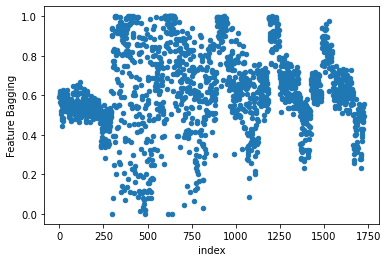

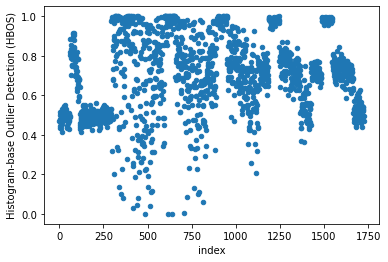

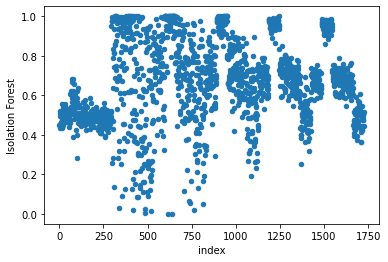

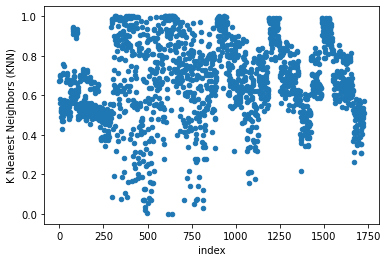

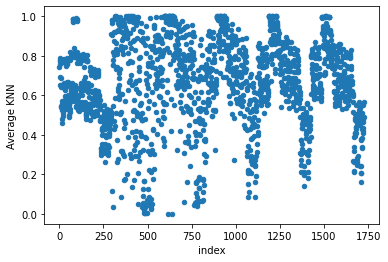

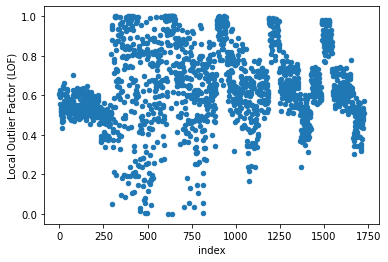

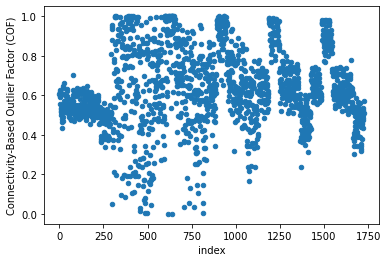

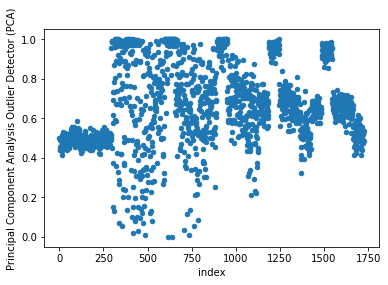

In [170]:
for i in rocDict:
    data = rocDict.get(i)
    tempDF = pd.DataFrame(data,columns=[i])
    tempDF['index']= list(range(1,len(tempDF)+1))
    tempDF.plot(kind="scatter",x='index',y=i)

### 该问题可以看做二分类问题，由最后的ROC统计散点图可以看出，对于所有的benchmarks文件ROC值普遍在0.5-0.6之间，从250个左右的文件开始，各个模型表现出差别较大的性能，可能ROC接近于0，也可能接近于1，总体而言，KNN、average KNN平均在0.7左右、LOF以及HBOS平均在0.6左右，这四个模型性能较好